In [ ]:
#####################################################################
#   PROJET 5 - Catégorisez automatiquement des questions            #
#-------------------------------------------------------------------#
#   NOTEBOOK D'EXPLORATION :                                        #
#      ---> analyse univariée,                                      #
#      ---> analyse multivariée,                                    #
#      ---> réduction dimensionnelle                                #
#      ---> différentes questions de recherche associées.           #
#####################################################################

In [ ]:
#####################################################################
#   GITHUB                                                          #
#-------------------------------------------------------------------#
# GitHub              : https://github.com/irribarre                #
# Repository projet 5 : https://github.com/irribarre/Texte_1        #
# Notebook 1          : 1_notebook_exploration.ipynb                #
#####################################################################

In [ ]:
#############################################################################
# PLAN CODE :                                                               #
#############################################################################
# 1. RECUPERATION DU CORPUS DE TEXTE
# 
# 2. EDA (EXPLORATORY DATA ANALYSIS)
#    2.1. AFFICHAGE
#    2.2. STRUCTURE
#    2.3. VALEURS MANQUANTES
#    2.4. VALEURS DUPLIQUEES
#    2.5. DATA INSPECTION
# 
# 3. PRETRAITEMENT DU TEXTE / TEXT PROCESSING
#    3.1. BALISES DE TAGS = TARGET Y
#         3.1.1. TAGS : CORPUS & TOKENS
#         3.1.2. REDUCTION DU NOMBRE DE TAGS
#    3.2. BALISES HTML
#    3.3. NETTOYAGE : TOKENISATION, SUPPRESSIONS (STOP WORDS, NOMBRES...)
# 
# 4. COMPLEMENT PRETRAITEMENT DU TEXTE / TEXT PROCESSING
#    4.1. CALCUL RARE TOKENS
#    4.2. CALCUL DOUBLONS
#    4.3. COMPLEMENT NETTOYAGE : RARE WORDS, DOUBLONS, NORMALISATION (LEMMATISATION & STEMMING)
# 
# 5. COMPLEMENT PRETRAITEMENT DU TEXTE / TEXT PROCESSING – DONNEES NORMALISEES
#    5.1. CALCUL RARE TOKENS - DONNEES NORMALISEES
#    5.2. COMPLEMENT NETTOYAGE : RARE WORDS DONNEES NORMALISEES (LEMMATISATION & STEMMING)
# 
# 6. VARIABLES POUR ANALYSES UNIVARIEE, BIVARIEE, MULTIVARIEE
#    6.1. VARIABLES TAG
#         6.1.1. TAG 1
#         6.1.2. TAG 2
#         6.1.3. TAGS LES PLUS REPRESENTES
#    6.2. VARIABLES TEXTE
#         6.2.1. CORPUS TEXTE
#         6.2.2. TOKENS TEXTE
# 
# 7. ANALYSE UNIVARIEE
#    7.1. ANALYSE UNIVARIEE TAGS
#         7.1.1. ETUDE DES TAGS LES PLUS REPRESENTES (VARIABLE CATEGORIELLE)
#         7.1.2. ETUDE DE LA FREQUENCE DES TAGS (VARIABLE CATEGORIELLE)
#         7.1.3. ETUDE DE LA TAILLE DES NOMS DE TAG (VARIABLE QUANTITATIVE)
#    7.2. ANALYSE UNIVARIEE TEXTE
#         7.2.1. ETUDE DE LA FREQUENCE DES MOTS (VARIABLE QUANTITATIVE)
#         7.2.2. ETUDE DE LA LONGUEUR DES DOCUMENTS (VARIABLE QUANTITATIVE)
#    7.3. FREQUENCE DISTRIBUTION (VARIABLE CATEGORIELLE)
#         7.3.1. FREQUENCE DISTRIBUTION COLONNE _STEMMER_CLEAN POUR 1-GRAM
#         7.3.2. FREQUENCE DISTRIBUTION COLONNE _STEMMER_CLEAN POUR 2-GRAM
#         7.3.3. FREQUENCE DISTRIBUTION COLONNE _LEMMA_CLEAN POUR 3-GRAM
#    7.4. WORD CLOUD (VARIABLE CATEGORIELLE)
#    7.5. ANALYSE UNIVARIEE VARIABLES NUMERIQUES
# 
# 8. ANALYSE BIVARIEE
#    8.1. ETUDE DE LA TAILLE DES DOCUMENTS PAR RPPORT AUX TAGS (VARIABLE QUANTITATIVE ET VARIABLE CATEGORIELLE)
# 
# 9. ANALYSE MULTIVARIEE
#    9.1. ANALYSE DE 3 VARIABLES NUMERIQUES
#    9.2. MATRICE DE CORRELATION
# 
# 10. SAUVEGARDE DANS FICHIERS

In [1]:
# Constantes
# Exécution sur google colab ou pas
C_EXECUTION_SUR_GOOGLE_COLAB = False  # False --> PC
                                      # True --> Google colab : https://colab.research.google.com/

In [ ]:
if (C_EXECUTION_SUR_GOOGLE_COLAB):
    !pip install emoji
   #!pip install seaborn --upgrade

In [2]:
# built-in (librairie par défaut avec python)
import os
import time # https://realpython.com/python-timer/

# Data
import pandas as pd
import numpy as np
from zipfile import ZipFile
import seaborn as sns

# NLP
from string import punctuation
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.util import ngrams
import emoji
from nltk.corpus import words   # liste des mots dans une langue
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.probability import FreqDist

# Visualisation
import matplotlib.pyplot as plt
from wordcloud import WordCloud


# ------------------------------- Pour google colab -------------------------------
if (C_EXECUTION_SUR_GOOGLE_COLAB):
    from google.colab import drive

# 1. RECUPERATION DU CORPUS DE TEXTE

In [ ]:
# Montage disques réseau avec google drive + demande autorisation connexion)
# Google drive : https://drive.google.com/drive/my-drive
if (C_EXECUTION_SUR_GOOGLE_COLAB):
    drive.mount('/content/drive', force_remount = True)
    # vérification fichier
    !ls /content/drive/MyDrive/Colab_Notebooks/data_P5

In [3]:
# Constantes
# Google colab
if (C_EXECUTION_SUR_GOOGLE_COLAB):
    C_DATASET_SOURCE  = '/content/drive/MyDrive/Colab_Notebooks/data_P5/source/'        
    C_DATASET_CLEANED = '/content/drive/MyDrive/Colab_Notebooks/data_P5/cleaned/'
    C_APP_MODELE      = '/content/drive/MyDrive/Colab_Notebooks/app_models/'       # modèles pré-entraînés pour
                                                                                   # l'application
    C_APP_PREPARATION = '/content/drive/MyDrive/Colab_Notebooks/app_preparation/'  # fichiers de préparation pour 
                                                                                   # l'application    
# PC
else:
    C_DATASET_SOURCE  = './data/source/'
    C_DATASET_CLEANED = './data/cleaned/'
    C_APP_MODELE      = './app_models/'       # modèles pré-entraînés pour l'application
    C_APP_PREPARATION = './app_preparation/'  # fichiers de préparation pour l'application

In [ ]:
# Création d’un fichier csv / année (2008 --> 2023) avec la commande SQL, puis zip :
#------------------------------------------------------------------------------------------------------------------#
#  SELECT TOP 500000 PostTypeId, CreationDate, Title, Body, Tags, Id, Score, ViewCount, FavoriteCount, AnswerCount #
#  FROM Posts                                                                                                      #
#  WHERE CreationDate >= '20080101' AND CreationDate <= '20081231'                                                 #
#  AND ViewCount > 10                                                                                              #
#  AND Score > 5 AND AnswerCount > 0 AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5                               #
#------------------------------------------------------------------------------------------------------------------#

In [4]:
# Liste des fichiers fournis
os.listdir(C_DATASET_SOURCE)

['QueryResults_2008_to_2023.zip']

In [ ]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @ A FAIRE UNE SEULE FOIS :                                                                         @
# @ Transformation du zip contenant n fichiers en un seul (exploitable si travail sur google colab). @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# https://stacklima.com/facons-dimporter-des-fichiers-csv-dans-google-colab/
if (not C_EXECUTION_SUR_GOOGLE_COLAB):
    df_zip = pd.concat([pd.read_csv(ZipFile(C_DATASET_SOURCE + 'QueryResults_2008_to_2023.zip').open(i)) 
                        for i in ZipFile(C_DATASET_SOURCE + 'QueryResults_2008_to_2023.zip').namelist()],
                       ignore_index = True)

    df_zip.shape
    df_zip.to_csv(C_DATASET_SOURCE + 'QueryResults_2008_to_2023.csv', 
                  sep = '\t', header = True, index = False)

In [5]:
# Lecture fichier
# https://ichi.pro/fr/tutoriel-google-colab-101-avec-python-conseils-astuces-et-faq-130333958546612
# Google Colab fournit également des fonctionnalités pour lire les données de Google Drive.
if (C_EXECUTION_SUR_GOOGLE_COLAB):
    df = pd.read_csv(C_DATASET_SOURCE + 'QueryResults_2008_to_2023.csv', sep = '\t')

else:
    df = pd.concat([pd.read_csv(ZipFile(C_DATASET_SOURCE + 'QueryResults_2008_to_2023.zip').open(i)) 
                    for i in ZipFile(C_DATASET_SOURCE + 'QueryResults_2008_to_2023.zip').namelist()],
                   ignore_index = True)
    
print(df)

        PostTypeId         CreationDate  \
0                1  2008-08-09 04:13:02   
1                1  2008-08-06 19:26:30   
2                1  2008-08-07 02:29:58   
3                1  2008-08-09 21:16:29   
4                1  2008-08-09 06:50:22   
...            ...                  ...   
223334           1  2023-02-06 14:29:31   
223335           1  2023-02-06 22:06:47   
223336           1  2023-02-07 10:56:09   
223337           1  2023-02-07 18:11:01   
223338           1  2023-02-08 15:39:44   

                                                    Title  \
0       Registry vs. INI file for storing user configu...   
1       IllegalArgumentException or NullPointerExcepti...   
2       What is the best way to create a sparse array ...   
3       Thread safe lazy construction of a singleton i...   
4               Web Services -- WCF vs. ASMX ("Standard")   
...                                                   ...   
223334  How can I get the url pathname on a server com..

# 2. EDA (EXPLORATORY DATA ANALYSIS) 

In [6]:
# Informations sur le dataframe : shape, nombre de lignes, indice du dernier élément.
def df_info(df_in):
    print('df shape\t\t=', df_in.shape)
    print('nb lignes\t\t=', len(df_in.index))
    print('indice dernier élément \t=', df_in.index[-1])

# 2.1. AFFICHAGE

In [7]:
# Affichage des 5 premières lignes
df.head(5)

,PostTypeId,CreationDate,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,1,2008-08-09 04:13:02,Registry vs. INI file for storing user configu...,<p>I'm a new Windows programmer and I'm not su...,<windows><registry><settings><configuration-fi...,6607,55,25485,0.0,13
1,1,2008-08-06 19:26:30,IllegalArgumentException or NullPointerExcepti...,<p>I have a simple setter method for a propert...,<java><exception><null><nullpointerexception><...,3881,570,196562,0.0,26
2,1,2008-08-07 02:29:58,What is the best way to create a sparse array ...,<p>I am working on a project that requires the...,<c++><oop><data-structures><hash><maps>,4306,62,58381,0.0,11
3,1,2008-08-09 21:16:29,Thread safe lazy construction of a singleton i...,<p>Is there a way to implement a singleton obj...,<c++><multithreading><singleton><construction>...,6915,38,27413,0.0,9
4,1,2008-08-09 06:50:22,"Web Services -- WCF vs. ASMX (""Standard"")",<p>I am working on a new project. Is there any...,<.net><wcf><web-services><visual-studio><asmx>,6666,34,11745,0.0,7


In [8]:
# affichage des 5 dernières lignes
df.tail(5)

,PostTypeId,CreationDate,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
223334,1,2023-02-06 14:29:31,How can I get the url pathname on a server com...,<p>So basically I have a server component in a...,<javascript><next.js><path><router><react-serv...,75362636,10,4351,NaN,2
223335,1,2023-02-06 22:06:47,DeprecationWarning: headless property is depre...,<p>I am trying to execute a basic program usin...,<python><selenium><selenium-webdriver><seleniu...,75367068,8,8015,NaN,2
223336,1,2023-02-07 10:56:09,std::move and lifetime of temporary objects,<p>Can someone explain the execution order of ...,<c++><move><destructor><move-semantics><lifetime>,75372382,19,1085,NaN,2
223337,1,2023-02-07 18:11:01,"f = std::forward in lambda capture, what does ...",<p>I have the following code which is used to ...,<c++><lambda><metaprogramming><perfect-forward...,75377353,6,139,NaN,2
223338,1,2023-02-08 15:39:44,"""Error: require() of ES Module"" using Visx wit...",<p>I am using the Visx library to build charts...,<javascript><reactjs><next.js><es6-modules><visx>,75388177,8,614,NaN,2


In [9]:
# affichage de 5 lignes au hasard
df.sample(5)

,PostTypeId,CreationDate,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
211112,1,2020-09-15 12:28:58,Why shouldn't I use IdToken as bearer token in...,<p>I am using an IDP platform (here AWS Cognit...,<authentication><jwt><amazon-cognito><openid-c...,63901860,6,1540,0.0,1
50517,1,2011-09-18 18:32:01,"Why do we have map, fmap and liftM?",<pre><code>map :: (a -&gt; b) -&gt; [a] -&gt; ...,<list><haskell><monads><redundancy><functor>,7463500,107,10656,0.0,1
119498,1,2014-05-23 08:59:48,Is there any array-like data structure that ca...,<p>I'm a student working on a small project fo...,<c++><arrays><memory-management><data-structur...,23824986,7,1369,0.0,4
141960,1,2015-06-25 18:51:55,Spark 1.4 increase maxResultSize memory,<p>I am using Spark 1.4 for my research and st...,<python><memory><apache-spark><pyspark><jupyter>,31058504,50,68309,0.0,7
103780,1,2014-08-01 05:54:06,NSWindow beginSheet completionHandler not called,<p>I am showing a sheet within my main window....,<macos><cocoa><nsview><nswindow><nswindowcontr...,25073716,7,6398,0.0,2


In [10]:
# affichage de 5 lignes
count = 0

for index, row in df.iterrows():
    print('@' * 100, '\nindex =', index,
          '\nTags\t=', row['Tags'],
          '\nTitle\t=', row['Title'], 
          '\nBody\t=', row['Body'])
    count = count + 1
    
    if (count >= 5):
        break

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
index = 0 
Tags	= <windows><registry><settings><configuration-files><ini> 
Title	= Registry vs. INI file for storing user configurable application settings 
Body	= <p>I'm a new Windows programmer and I'm not sure where I should store user configurable application settings.  I understand the need to provide a user friendly means for the user to change application settings, like an Edit | Settings form or similar.  But where should I store the values after the user hits the Apply button on that form?  </p>

<p>What are the pros and cons of storing settings in the Windows registry vs. storing them in a local INI file or config file or similar?</p>

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
index = 1 
Tags	= <java><exception><null><nullpointerexception><illegalargumentexception> 
Title	= IllegalArgumentException or NullPointerExce

In [11]:
df.columns

Index(['PostTypeId', 'CreationDate', 'Title', 'Body', 'Tags', 'Id', 'Score',
       'ViewCount', 'FavoriteCount', 'AnswerCount'],
      dtype='object')

# 2.2. STRUCTURE

In [12]:
# nombre de lignes et nombre de colonnes
df.shape

(223339, 10)

In [13]:
# type des colonnes
df.dtypes

PostTypeId         int64
CreationDate      object
Title             object
Body              object
Tags              object
Id                 int64
Score              int64
ViewCount          int64
FavoriteCount    float64
AnswerCount        int64
dtype: object

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223339 entries, 0 to 223338
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   PostTypeId     223339 non-null  int64  
 1   CreationDate   223339 non-null  object 
 2   Title          223339 non-null  object 
 3   Body           223339 non-null  object 
 4   Tags           223339 non-null  object 
 5   Id             223339 non-null  int64  
 6   Score          223339 non-null  int64  
 7   ViewCount      223339 non-null  int64  
 8   FavoriteCount  190664 non-null  float64
 9   AnswerCount    223339 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 17.0+ MB


In [15]:
# nombre de colonnes de chaque dtypes (sert si 100 colonnes par exemple)
df.dtypes.value_counts()

int64      5
object     4
float64    1
Name: count, dtype: int64

In [16]:
# nombre de valeurs uniques par colonne
df.nunique()

PostTypeId            1
CreationDate     223257
Title            223331
Body             223339
Tags             213404
Id               223339
Score              1136
ViewCount         60662
FavoriteCount         4
AnswerCount          79
dtype: int64

In [17]:
# suppression de la colonne PostTypeId car il n'y a qu'une valeur unique
df.drop(['PostTypeId'], axis = 1, inplace = True)

# 2.3. VALEURS MANQUANTES

In [18]:
# Nombre de valeurs manquantes
nb_na = df.isna().sum()
nb_na[nb_na > 0]

FavoriteCount    32675
dtype: int64

In [20]:
# Nombre de valeurs manquantes en pourcentage
nb_na_p100 = df.isna().mean()
nb_na_p100[nb_na_p100 > 0]

FavoriteCount    0.146302
dtype: float64

<AxesSubplot:>

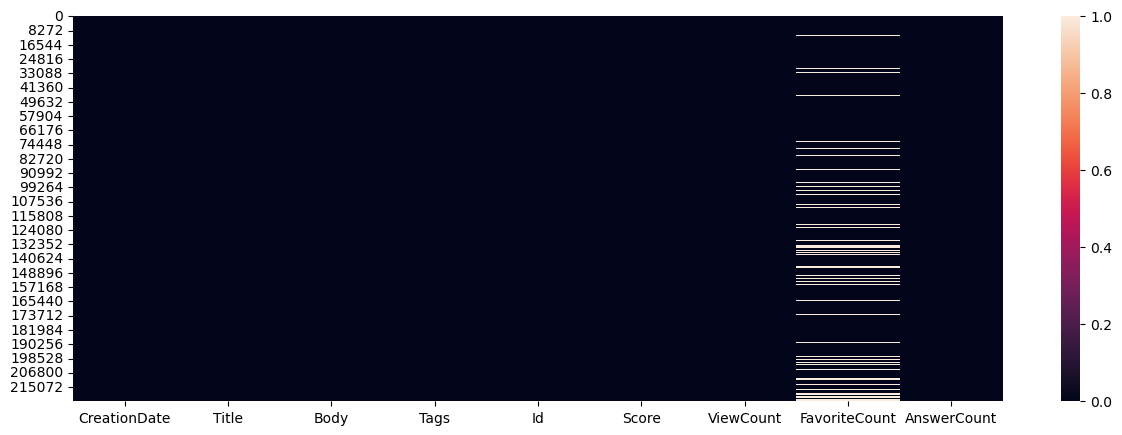

In [21]:
# représentation graphique des valeurs manquantes
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
sns.heatmap(df.isna())

# blanc <=> il y a une / des valeur(s).
# noir  <=> il n'y a pas de valeur.

In [22]:
# traces
# FavoriteCount
print('@' * 30, 'FavoriteCount', '@' * 30)
print(df['FavoriteCount'].nunique(), 'valeurs uniques :', 
      df['FavoriteCount'].unique())

print('nombre et fréquence de valeurs :')
print(df['FavoriteCount'].value_counts())

print('[min, max] : [', df['FavoriteCount'].min(), ',', df['FavoriteCount'].max(), ']')

# ViewCount
print('\n', '@' * 32, 'ViewCount', '@' * 31)
print('[min, max] : [', df['ViewCount'].min(), ',', df['ViewCount'].max(), ']')

# Score
print('\n', '@' * 33, 'Score', '@' * 34)
print('[min, max] : [', df['Score'].min(), ',', df['Score'].max(), ']')

# AnswerCount
print('\n', '@' * 30, 'AnswerCount', '@' * 31)
print('[min, max] : [', df['AnswerCount'].min(), ',', df['AnswerCount'].max(), ']')

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ FavoriteCount @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
4 valeurs uniques : [ 0. nan  1. 32.  2.]
nombre et fréquence de valeurs :
FavoriteCount
0.0     190652
1.0         10
32.0         1
2.0          1
Name: count, dtype: int64
[min, max] : [ 0.0 , 32.0 ]

 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ ViewCount @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
[min, max] : [ 50 , 12807534 ]

 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Score @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
[min, max] : [ 6 , 27009 ]

 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ AnswerCount @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
[min, max] : [ 1 , 134 ]


In [23]:
# Suppression colonne 'FavoriteCount', car :
#  - peu de valeurs > 0
#  - nous avons d'autres critères de filtrage utilisés dans la commande SQL : ViewCount > 10, Score > 5, AnswerCount > 0.
df.drop(['FavoriteCount'], axis = 1, inplace = True)

In [24]:
# Vérification nombre de valeurs manquantes
nb_na = df.isnull().sum()
nb_na[nb_na > 0]

Series([], dtype: int64)

# 2.4. VALEURS DUPLIQUEES

In [25]:
df.columns

Index(['CreationDate', 'Title', 'Body', 'Tags', 'Id', 'Score', 'ViewCount',
       'AnswerCount'],
      dtype='object')

In [26]:
########################################
# Doublons entre toutes les lignes     #
########################################
# il n'y a aucune ligne dupliquée <=> il n'existe aucune ligne au niveau du dataframe qui soit la même.
df.duplicated().sum()

0

In [27]:
########################################
# Doublons colonne Body                #
########################################
# Recherche si il y a des valeurs dupliquées pour la colonne Body (corps du message)
df.duplicated(subset = 'Body').sum()

0

In [28]:
# Affichage des duplicated pour un même Body.
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html
idx = df.duplicated(subset = 'Body', keep = False) # Mark all duplicates as True.
df_duplicated = df.loc[idx, :].sort_values('Body')
df_duplicated

# pas de valeurs dupliquées pour un même Body.

,CreationDate,Title,Body,Tags,Id,Score,ViewCount,AnswerCount


In [29]:
########################################
# Doublons entre toutes les colonnes   #
########################################
# Recherche si il y a des valeurs dupliquées pour chaque colonne
for col in df.columns:
    n = df.duplicated(subset = col).sum()
    print(f"col : {col} -> duplicated : {n}")

col : CreationDate -> duplicated : 82
col : Title -> duplicated : 8
col : Body -> duplicated : 0
col : Tags -> duplicated : 9935
col : Id -> duplicated : 0
col : Score -> duplicated : 222203
col : ViewCount -> duplicated : 162677
col : AnswerCount -> duplicated : 223260


In [30]:
########################################
# Doublons colonne Title               #
########################################
# Affichage des duplicated pour un même Title.
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html
idx = df.duplicated(subset = 'Title', keep = False) # Mark all duplicates as True.
df_duplicated = df.loc[idx, :].sort_values('Title')
df_duplicated

,CreationDate,Title,Body,Tags,Id,Score,ViewCount,AnswerCount
1545,2008-09-17 10:58:14,A potentially dangerous Request.Form value was...,<p>Every time a user posts something containin...,<asp.net><asp.net-mvc><validation><html-encode...,81991,1581,1133070,48
54662,2012-02-03 14:28:36,A potentially dangerous Request.Form value was...,<p>I have this issue. I have tried everything....,<c#><jquery><asp.net><architecture><postback>,9130186,25,113706,8
22051,2010-02-22 21:50:22,Git post-receive hook not working,<p>We're using git with a central repo (using ...,<git><bash><gitosis><githooks><git-post-receive>,2314500,12,11562,3
43318,2011-02-09 21:38:22,Git post-receive hook not working,"<p>My setup is a windows XAMPP server, with cU...",<git><curl><hudson><githooks><git-post-receive>,4950800,8,14587,5
11625,2009-12-10 21:18:38,HTML Agility Pack,<p>I'm trying to use HTML Agility Pack to get ...,<c#><html><winforms><parsing><html-agility-pack>,1884094,11,14754,2
19068,2010-03-11 05:32:04,HTML Agility Pack,<p>I want to parse the html table using html a...,<c#><.net><winforms><html-parsing><html-agilit...,2422762,6,6506,1
74523,2012-08-01 12:18:04,Injection of autowired dependencies failed; ne...,"<p>I am creating web application using Spring,...",<java><spring><hibernate><spring-mvc><struts>,11759040,21,186028,3
169021,2017-03-16 11:09:21,Injection of autowired dependencies failed; ne...,<p>I am new here and I am trying to create an ...,<java><spring><hibernate><maven><spring-mvc>,42832387,6,12236,4
31924,2011-08-31 15:38:30,LINQ to Entities does not recognize the method,<p>I'm getting the following error when trying...,<.net><linq><entity-framework><linq-to-entitie...,7259567,138,161033,5
43156,2011-01-22 11:40:06,LINQ to Entities does not recognize the method,"<p>I am following <a href=""http://msdn.microso...",<entity-framework><entity-framework-4><code-fi...,4767596,6,3103,1


In [31]:
for index, row in df_duplicated.iterrows():
    if ((index == 14398) | (index == 19745)):
        print('\n', '@' * 30, 'index =', index, '@' * 30)
        print(row['Title'], row['Body'][1:250], '\n')


 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ index = 14398 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Pointcut matching methods with annotated parameters p>I need to create an aspect with a pointcut matching a method if:</p>

<ol>
<li>it is annoted with MyAnnotationForMethod</li>
<li>One of its parameters (can have many) is annotated with @MyAnnotationForParam (but can have other annotations as well) 


 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ index = 19745 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Pointcut matching methods with annotated parameters p>I need to create an aspect with a pointcut matching a method if:</p>

<ul>
<li>Is public</li>
<li>Its class is annotated with @Controller  <strong><em>(Finally does not)</em></strong></li>
<li>One of its parameters (can have many) is annotated wit 



In [ ]:
########################################
# Doublons colonnes Title & Body       #
########################################

In [32]:
 # Affichage des duplicated pour un même Title et Body.
idx = df.duplicated(subset = ['Title', 'Body'], keep = False) # Mark all duplicates as True.
df.loc[idx, :].sort_values('Title')

,CreationDate,Title,Body,Tags,Id,Score,ViewCount,AnswerCount


In [ ]:
###############################################################
#   FUSION DES 2 COLONNES      DE TYPE TEXTE : TITLE & BODY   #
#           EN 1 SEULE COLONNE DE TYPE TEXTE : TEXT           #
###############################################################

In [33]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @ COLONNES TEXTE : Text + Body --> _Text                        @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# https://apprendrepython.com/concatenation-de-chaines-de-caracteres-en-python-operateur-jointure-etc/
for index, row in df.iterrows():
    
    # Stockage du résultat pour chaque ligne   
    df.loc[index, '_Text'] = df.loc[index, 'Title'] + ' ' + df.loc[index, 'Body'] # Google colab : 54 s

In [34]:
index = 10

print('index =', index, '\n')
print('@' * 30, 'Title =', '@' * 30, '\n',
      df.loc[index, 'Title'], '\n')

print('@' * 30, 'Body =', '@' * 30, '\n',
      df.loc[index, 'Body'], '\n')

print('@' * 30, '_Text =', '@' * 30, '\n',
      df.loc[index, '_Text'], '\n')

index = 10 

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Title = @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
 LinqDataSource - Can you limit the amount of records returned? 

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Body = @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
 <p>I'd like to use a <code>LinqDataSource</code> control on a page and limit the amount of records returned.  I know if I use code behind I could do something like this:</p>

<pre><code>IEnumerable&lt;int&gt; values = Enumerable.Range(0, 10);
IEnumerable&lt;int&gt; take3 = values.Take(3);
</code></pre>

<p>Does anyone know if something like this is possible with a <code>LinqDataSource</code> control?</p>

<p><strong>[Update]</strong></p>

<p>I'm going to use the <code>LinqDataSource</code> with the <code>ListView</code> control, <em>not</em> a GridView or Repeater.  The <code>LinqDataSource</code> wizard does not provide the ability to limit the number of records return.  The Advanced options only allow you to enabled deletes, inserts, and updates.</p>
 

@@@@@@@@@@@@@

In [35]:
# Suppression des colonnes Title et Body (fusionnées dans la colonne _Text)
df.drop(['Title', 'Body'], axis = 1, inplace = True)

In [36]:
########################################
# Doublons colonne _Text               #
########################################
# Vérification qu'il n'y a pas de valeurs dupliquées pour la colonne _Text
df.duplicated(subset = '_Text').sum()

0

# 2.5. DATA INSPECTION

In [37]:
# summary statistics sur les colonnes de type numérique
# (transpose met les attributs en ligne pour + de lisibilité)
df.describe(include = np.number).transpose()

,count,mean,std,min,25%,50%,75%,max
Id,223339.0,2.666292e+07,1.925549e+07,4.0,9469555.0,23685630.0,41588480.5,76403109.0
Score,223339.0,2.598959e+01,1.446805e+02,6.0,7.0,10.0,18.0,27009.0
ViewCount,223339.0,2.711956e+04,1.067922e+05,50.0,3087.0,8234.0,21179.5,12807534.0
AnswerCount,223339.0,3.394405e+00,3.495859e+00,1.0,1.0,2.0,4.0,134.0


In [38]:
# summary statistics sur les colonnes de type object
# (transpose met les attributs en ligne pour + de lisibilité)
df.describe(include = object).transpose()

,count,unique,top,freq
CreationDate,223339,223257,2014-06-23 06:12:33,2
Tags,223339,213404,<javascript><jquery><html><css><twitter-bootst...,111
_Text,223339,223339,Registry vs. INI file for storing user configu...,1


# 3. PRETRAITEMENT DU TEXTE / TEXT PROCESSING

# 3.1. BALISES DE TAGS = TARGET Y

In [39]:
# Trace colonne Tags
for i in [0, 10, 100]:
    print('@' * 40, 'index =', i, '@' * 40, '\n',
          df.loc[i, 'Tags'], '\n')

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ index = 0 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
 <windows><registry><settings><configuration-files><ini> 

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ index = 10 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
 <c#><asp.net><database><linq><linq-to-sql> 

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ index = 100 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
 <c#><asp.net><compilation><startup><aspnet-compiler> 



In [40]:
############################################################
# Suppression des balises de tags                          #
############################################################
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @ COLONNES TAGS : Tags --> _Tags                         @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
def tags_process_dataset():
    
    # Traitement pour chaque ligne
    for index, row in df.iterrows():
    
        tags = df.loc[index, 'Tags']
        
        # Suppression des balises <>
        tags = re.sub(r"<", "", tags)
        tags = re.sub(r">", " ", tags)

        # Nombre de tags
        # https://fr.moonbooks.org/Articles/Comment-obtenir-le-nombre-de-mots-dans-un-texte-manuscript-en-python-/        
        list_of_words = tags.split()
        nb_tags = len(list_of_words)
        
        # Stockage du résultat pour chaque ligne   
        df.loc[index, '_Tags']    = tags     # liste de tags sans les balises
        df.loc[index, '_Nb_tags'] = nb_tags  # nombre de tags

In [41]:
tags_process_dataset() # Google colab : 1 min

In [42]:
# traces pour vérifier
for i in [0, 10, 100]:
    print('@' * 40, 'index =', i, '@' * 40, '\n',
          'AVANT :', df.loc[i, 'Tags'], '\n',
          'APRES :', df.loc[i, '_Tags'], '\n',
          '_Nb_tags :', df.loc[i, '_Nb_tags'], '\n')

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ index = 0 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
 AVANT : <windows><registry><settings><configuration-files><ini> 
 APRES : windows registry settings configuration-files ini  
 _Nb_tags : 5.0 

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ index = 10 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
 AVANT : <c#><asp.net><database><linq><linq-to-sql> 
 APRES : c# asp.net database linq linq-to-sql  
 _Nb_tags : 5.0 

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ index = 100 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
 AVANT : <c#><asp.net><compilation><startup><aspnet-compiler> 
 APRES : c# asp.net compilation startup aspnet-compiler  
 _Nb_tags : 5.0 



In [43]:
df['_Nb_tags'].describe().transpose()
# Il y a entre 5 et 6 tags par ligne.

count    223339.000000
mean          5.000031
std           0.005598
min           5.000000
25%           5.000000
50%           5.000000
75%           5.000000
max           6.000000
Name: _Nb_tags, dtype: float64

In [44]:
# Suppression des colonnes Tags et _Nb_tags
df.drop(['Tags', '_Nb_tags'], axis = 1, inplace = True)

# 3.1.1. TAGS : CORPUS & TOKENS

In [45]:
###########################
# Corpus au format texte  #
###########################
# on reconstitue le corpus en joignant l'ensemble des lignes / documents entre eux.
# On fait join avec '' et non ' ', car > a été remplacé par un blanc, la liste de tags se termine par blanc
# (cela évite d'avoir 2 blancs).
corpus_tags = ''.join(df['_Tags']) 
corpus_tags[:1_000]

'windows registry settings configuration-files ini java exception null nullpointerexception illegalargumentexception c++ oop data-structures hash maps c++ multithreading singleton construction lazy-initialization .net wcf web-services visual-studio asmx .net visual-studio tdd mbunit testdriven.net jakarta-ee deployment ant websphere ear sql sql-server database sql-server-2008 intellisense c# .net performance configuration properties language-agnostic http webserver header etag c# asp.net database linq linq-to-sql c# vb.net performance stringbuilder string.format c# c++ windows 64-bit memcached c# .net .net-3.5 wia image-scanner java xml json cross-platform configuration-files c# .net winforms visual-studio-2008 visual-studio-2005 c++ oop class syntax static asp.net performance .net-3.5 content-management-system n2 c++ winapi macos porting fopen http iis iis-7 cookies windows-vista c function pointers syntax parameters html mobile responsive-design wap wml c++ linux eclipse gdb valgrind

In [46]:
###########################
# Corpus au format token  #
###########################
token_tags = corpus_tags.split()
len(token_tags)

1116702

In [47]:
# Enregistrement dans un fichier
tmp = pd.DataFrame({'token_tag': token_tags})
tmp.to_csv(C_APP_PREPARATION + 'token_tags.txt', header = False, index = False)

In [48]:
print(token_tags[0:10])

['windows', 'registry', 'settings', 'configuration-files', 'ini', 'java', 'exception', 'null', 'nullpointerexception', 'illegalargumentexception']


In [49]:
# Nombre de fois où sont présents les tokens dans le corpus
# (certains tokens ne sont présents qu'une seule fois).
count_tags = pd.Series(token_tags).value_counts()
count_tags

java                  26280
c#                    25236
javascript            23558
python                23109
c++                   16697
                      ...  
delphi.net                1
ng-hide                   1
mpmoviewcontroller        1
bitsets                   1
visx                      1
Name: count, Length: 31402, dtype: int64

In [50]:
# Nombre de valeurs uniques
print('count_tags :', len(count_tags), 'valeurs uniques')

count_tags : 31402 valeurs uniques


In [51]:
count_tags.describe()

count    31402.000000
mean        35.561493
std        381.644076
min          1.000000
25%          1.000000
50%          3.000000
75%         11.000000
max      26280.000000
Name: count, dtype: float64

In [52]:
# 15 tokens les plus importants
count_tags.head(15)

java           26280
c#             25236
javascript     23558
python         23109
c++            16697
android        15952
ios            15631
.net           11731
html            9781
php             8871
jquery          7764
objective-c     7398
c               6818
node.js         6555
iphone          6437
Name: count, dtype: int64

In [53]:
# 15 tokens les moins importants
count_tags.tail(15)

kie-wb                 1
ibplugin               1
homomorphism           1
lighttable             1
jaxbelement            1
sigma.js               1
pdftoppm               1
pgrouting              1
screenshotexception    1
hclust                 1
delphi.net             1
ng-hide                1
mpmoviewcontroller     1
bitsets                1
visx                   1
Name: count, dtype: int64

# 3.1.2. REDUCTION DU NOMBRE DE TAGS

In [ ]:
# Réduction du nombre de tags pour en avoir moins de 30.

In [54]:
count_tag_max = count_tags.max()
count_tag_plage_min = 14 / 100 * count_tag_max

print('count_tag_max\t\t=', count_tag_max)
print('count_tag_plage_min\t=', round(count_tag_plage_min), '(14% count_tag_max)')

count_tag_max		= 26280
count_tag_plage_min	= 3679 (14% count_tag_max)


In [55]:
####################################################################
#  Recherche des tags présents plus de 14% de fois dans le dataset #
####################################################################
# https://fr.moonbooks.org/Articles/Comment-extraire-les-noms-et-valeurs-de-valuecounts-avec-pandas-en-python-/
new_liste_tags = []

count_tags_reduced = count_tags[count_tags >= count_tag_plage_min]

for idx, name in enumerate(count_tags_reduced.index.tolist()):
    if (count_tags_reduced[idx] >= count_tag_plage_min):
        # Ajout dans la liste si pas déjà présent
        if (name not in new_liste_tags):
            new_liste_tags.append(name)
            print(count_tags_reduced[idx], "\t:", name)

26280 	: java
25236 	: c#
23558 	: javascript
23109 	: python
16697 	: c++
15952 	: android
15631 	: ios
11731 	: .net
9781 	: html
8871 	: php
7764 	: jquery
7398 	: objective-c
6818 	: c
6555 	: node.js
6437 	: iphone
6344 	: css
5408 	: linux
5290 	: asp.net
5174 	: swift
5114 	: spring
5019 	: sql
4510 	: xcode
4304 	: performance
4285 	: ruby-on-rails
4025 	: json
3932 	: reactjs
3854 	: windows
3799 	: mysql


In [56]:
# Nombre de valeurs uniques
print('new_liste_tags :', len(new_liste_tags), 'valeurs uniques :\n')

# liste triée
# https://www.cours-gratuit.com/tutoriel-python/tutoriel-python-list-comment-ordonnertrier-une-liste
print(sorted(new_liste_tags))

# ==> on garde 28 valeurs de tags sur 31402 présents initialement.

new_liste_tags : 28 valeurs uniques :

['.net', 'android', 'asp.net', 'c', 'c#', 'c++', 'css', 'html', 'ios', 'iphone', 'java', 'javascript', 'jquery', 'json', 'linux', 'mysql', 'node.js', 'objective-c', 'performance', 'php', 'python', 'reactjs', 'ruby-on-rails', 'spring', 'sql', 'swift', 'windows', 'xcode']


In [57]:
#####################################################################
# Recherche des 2 tags les plus représentés pour chaque ligne       #
#####################################################################
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @ COLONNES TAGS : Tags --> _Tags  --> _Tag_1, _Tag_2     @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

def reduction_tags_dataset():
    
    # initialisation
    count              = 0 
    lignes_a_supprimer = []

    for index, row in df.iterrows():
        # initialisation
        tags       = row['_Tags']
        token_tags = tags.split()
        dict_tags  = {}
    
        # Sélection des tags qui sont dans la liste
        for i in np.arange(0, len(token_tags)):
            if token_tags[i] in new_liste_tags:
                # On stocke les tags et leur fréquence dans un dictionnaire
                # Exemple : count_tags['java']   = 26280
                #           count_tags['python'] = 23109
                # => dict_tags['java'] = 26280
                dict_tags[token_tags[i]] = count_tags[token_tags[i]]
        
        len_dict_tags = len(dict_tags)
        
        if (count < 10):
            print('index =', index, ':', '\n',
                  '\t- _Tags\t\t=', row['_Tags'], '\n', 
                  '\t- dict_tags\t= ', dict_tags, '\n',
                  '\t- len_dict_tags\t=', len_dict_tags)
    
        # 0 tags : on supprime la ligne si il n'y a plus de tags
        if (len_dict_tags == 0):
            lignes_a_supprimer.append(index)
            if (count < 10):
                print('\t - AUCUN TAG => SUPPRESSION LIGNE\n')
        
        else:
            # Recherche des 2 plus grandes valeurs
            # https://www.delftstack.com/fr/howto/python/find-max-value-in-dictionary-python/
            # https://fr.code-paper.com/python/examples-max-value-from-a-dictionary-in-python
            max_key_1 = max(dict_tags, key = dict_tags.get)
            df.loc[index, '_Tag_1'] = max_key_1
            # suppression du dictionnaire 
            del(dict_tags[max_key_1])
            
            # Plus de 2 tags
            if (len_dict_tags >= 2):
                max_key_2 = max(dict_tags, key = dict_tags.get)
                df.loc[index, '_Tag_2'] = max_key_2
            
            # 1 seul tag
            else: 
                df.loc[index, '_Tag_2'] = 'no_tag' # Valeur vide pour _Tag_2
            
            # Affichage de 10 valeurs
            if (count < 10):
                print('\t - _Tag_1 =', df.loc[index, '_Tag_1'], ', _Tag_2 =', df.loc[index, '_Tag_2'], '\n')             

        count = count + 1
    

    # Suppression des tags vides (en donnant index)
    df.drop(lignes_a_supprimer, axis = 0, inplace = True)
    print("\n==>", len(lignes_a_supprimer), "lignes supprimées\n")

In [58]:
reduction_tags_dataset() # Google colab : 59 s

index = 0 : 
 	- _Tags		= windows registry settings configuration-files ini  
 	- dict_tags	=  {'windows': 3854} 
 	- len_dict_tags	= 1
	 - _Tag_1 = windows , _Tag_2 = no_tag 

index = 1 : 
 	- _Tags		= java exception null nullpointerexception illegalargumentexception  
 	- dict_tags	=  {'java': 26280} 
 	- len_dict_tags	= 1
	 - _Tag_1 = java , _Tag_2 = no_tag 

index = 2 : 
 	- _Tags		= c++ oop data-structures hash maps  
 	- dict_tags	=  {'c++': 16697} 
 	- len_dict_tags	= 1
	 - _Tag_1 = c++ , _Tag_2 = no_tag 

index = 3 : 
 	- _Tags		= c++ multithreading singleton construction lazy-initialization  
 	- dict_tags	=  {'c++': 16697} 
 	- len_dict_tags	= 1
	 - _Tag_1 = c++ , _Tag_2 = no_tag 

index = 4 : 
 	- _Tags		= .net wcf web-services visual-studio asmx  
 	- dict_tags	=  {'.net': 11731} 
 	- len_dict_tags	= 1
	 - _Tag_1 = .net , _Tag_2 = no_tag 

index = 5 : 
 	- _Tags		= .net visual-studio tdd mbunit testdriven.net  
 	- dict_tags	=  {'.net': 11731} 
 	- len_dict_tags	= 1
	 - _Ta

In [59]:
# Vérification qu'il n'y a pas de _Tag_2 vide (sinon mise à jour avec 'no_tag')
count = 0

for index, row in df.iterrows():
    if (pd.isna(row['_Tag_2'])):
        count = count + 1
        df.loc[index, '_Tag_2'] = 'no_tag'
        
print(count, 'lignes corrigées pour _Tag_2 : nan --> \'no_tag\'')

0 lignes corrigées pour _Tag_2 : nan --> 'no_tag'


In [60]:
# trace pour vérifier maj _Tag_1 et _Tag_2
count = 0

for index, row in df.iterrows():
    if (count < 20):
        print('index = ', index, ', _Tag_1 =', row['_Tag_1'], '\t, _Tag_2 =', row['_Tag_2'])
    else:
        break
    count = count + 1

index =  0 , _Tag_1 = windows 	, _Tag_2 = no_tag
index =  1 , _Tag_1 = java 	, _Tag_2 = no_tag
index =  2 , _Tag_1 = c++ 	, _Tag_2 = no_tag
index =  3 , _Tag_1 = c++ 	, _Tag_2 = no_tag
index =  4 , _Tag_1 = .net 	, _Tag_2 = no_tag
index =  5 , _Tag_1 = .net 	, _Tag_2 = no_tag
index =  7 , _Tag_1 = sql 	, _Tag_2 = no_tag
index =  8 , _Tag_1 = c# 	, _Tag_2 = .net
index =  10 , _Tag_1 = c# 	, _Tag_2 = asp.net
index =  11 , _Tag_1 = c# 	, _Tag_2 = performance
index =  12 , _Tag_1 = c# 	, _Tag_2 = c++
index =  13 , _Tag_1 = c# 	, _Tag_2 = .net
index =  14 , _Tag_1 = java 	, _Tag_2 = json
index =  15 , _Tag_1 = c# 	, _Tag_2 = .net
index =  16 , _Tag_1 = c++ 	, _Tag_2 = no_tag
index =  17 , _Tag_1 = asp.net 	, _Tag_2 = performance
index =  18 , _Tag_1 = c++ 	, _Tag_2 = no_tag
index =  20 , _Tag_1 = c 	, _Tag_2 = no_tag
index =  21 , _Tag_1 = html 	, _Tag_2 = no_tag
index =  22 , _Tag_1 = c++ 	, _Tag_2 = linux


In [61]:
# Suppression de la colonne _Tags
df.drop(['_Tags'], axis = 1, inplace = True)

In [62]:
# Informations sur le dataframe : shape, nombre de lignes, indice du dernier élément.
df_info(df_in = df)

df shape		= (182919, 8)
nb lignes		= 182919
indice dernier élément 	= 223338


# 3.2. BALISES HTML

In [63]:
# Trace colonne _Text
for i in [1, 10, 100]:
    print('@' * 40, 'index =', i, '@' * 40, '\n',
          df.loc[i, '_Text'], '\n')

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ index = 1 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
 IllegalArgumentException or NullPointerException for a null parameter? <p>I have a simple setter method for a property and <code>null</code> is not appropriate for this particular property. I have always been torn in this situation: should I throw an <a href="http://docs.oracle.com/javase/7/docs/api/java/lang/IllegalArgumentException.html" rel="noreferrer"><code>IllegalArgumentException</code></a>, or a <a href="http://docs.oracle.com/javase/7/docs/api/java/lang/NullPointerException.html" rel="noreferrer"><code>NullPointerException</code></a>? From the javadocs, both seem appropriate. Is there some kind of an understood standard?  Or is this just one of those things that you should do whatever you prefer and both are really correct?</p>
 

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ index = 10 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
 LinqDataSource - Can you limit the amount of records returned

In [64]:
########################################################################
# Pour une ligne :                                                     #
#   - Suppression des balises HTML                                     #
#   - Passage en minuscules                                            #
########################################################################
def html_process(index_in, is_affichage_in):

    # https://stackoverflow.com/questions/37018475/python-remove-all-html-tags-from-string
    if (is_affichage_in):
        print('index_in =', index_in, '\n')
    
    markup = df.loc[index_in, '_Text']
    
    if (is_affichage_in):
        print('@' * 40, 'html_process - début', '@' * 40)
        print(markup, '\n')
    
    
    # Suppression des balises HTML
    soup = BeautifulSoup(markup)
    soup_text = soup.get_text()
    
    
    # On met tout le texte en minuscule  
    soup_text = soup_text.lower()
        
    if (is_affichage_in):    
        print('@' * 40, 'html_process - fin', '@' * 40)
        print(soup_text)
    
    return soup_text

In [65]:
text = html_process(index_in        = 10, 
                    is_affichage_in = True)

index_in = 10 

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ html_process - début @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
LinqDataSource - Can you limit the amount of records returned? <p>I'd like to use a <code>LinqDataSource</code> control on a page and limit the amount of records returned.  I know if I use code behind I could do something like this:</p>

<pre><code>IEnumerable&lt;int&gt; values = Enumerable.Range(0, 10);
IEnumerable&lt;int&gt; take3 = values.Take(3);
</code></pre>

<p>Does anyone know if something like this is possible with a <code>LinqDataSource</code> control?</p>

<p><strong>[Update]</strong></p>

<p>I'm going to use the <code>LinqDataSource</code> with the <code>ListView</code> control, <em>not</em> a GridView or Repeater.  The <code>LinqDataSource</code> wizard does not provide the ability to limit the number of records return.  The Advanced options only allow you to enabled deletes, inserts, and updates.</p>
 

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ html_proces

In [66]:
########################################################################
# Pour tout le dataset :                                               #
#   - Suppression des balises HTML                                     #
#   - Passage en minuscules                                            #
########################################################################
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @ COLONNES TEXTE : Text + Body --> _Text --> _Text_sans_html    @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

def html_process_dataset():
    
    lignes_a_supprimer = [] # initialisation
    
    # Traitement pour chaque ligne
    for index, row in df.iterrows():
    
        text = html_process(index_in        = index, 
                            is_affichage_in = False)
   
      
        # Suppression ligne si text vide (valeur NaN)
        # https://www.delftstack.com/fr/howto/python/check-for-nan-values-python/        
        if (pd.isna(text)):
            lignes_a_supprimer.append(index)

        # Sinon : mise à jour dans le dataset : stockage du résultat pour chaque ligne
        # https://www.delftstack.com/fr/howto/python/how-to-convert-a-list-to-string/
        # Convertir une liste qui a des éléments de type de données str en une chaîne de caractères.            
        else:  
            df.loc[index, '_Text_sans_html'] = text
        
    # Suppression des lignes sans tokens
    df.drop(lignes_a_supprimer, axis = 0, inplace = True)
    print("==>", len(lignes_a_supprimer), "ligne(s) supprimée(s)\n")

In [67]:
html_process_dataset() # Google colab : 3 min 39 s

==> 0 ligne(s) supprimée(s)



In [68]:
# Trace (pour vérifier)
index = 10

print('@' * 40, '_Text / index =', index, '@' * 40, '\n',
      df.loc[i, '_Text'], '\n\n',
      '@' * 35, '_Text_sans_html / index =', index, '@' * 35, '\n',
      df.loc[i, '_Text_sans_html'], '\n')

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ _Text / index = 10 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
 Precompilation and startup times on ASP.Net <p>I am developping a (relatively small) website in ASP.Net 2.0. I am also using nAnt to perform some easy tweaking on my project before delivering executables. In its current state, the website is "precompiled" using </p>

<blockquote>
  <p><code>aspnet_compiler.exe -nologo -v ${Appname} -u ${target}</code></p>
</blockquote>

<p>I have noticed that after the IIS pool is restarted (after a idle shutdown or a recycle), the application takes up to 20 seconds before it is back online (and Application_start is reached).</p>

<p>I don't have the same issue when I am debugging directly within Visual Studio (it takes 2 seconds to start) so I am wondering if the aspnet_compiler is really such a good idea.</p>

<p>I couldn't find much on MSDN. How do you compile your websites for production?</p>
 

 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ _Text_sans_html

In [ ]:
#############################################
#         Nombre de mots par ligne          #
#############################################

In [69]:
# Calcul nombre de mots par ligne
def calcul_nb_mots_par_ligne(colonne_in, colonne_nb_mots_in):
    for index, row in df.iterrows():
        # suppression ligne vide
        if (pd.isna(row[colonne_in])):
            print('ligne_a_supprimer :', index, '(vide)')  
            df.drop(index, axis = 0, inplace = True)
        # sinon calcul nb mots dans la ligne et stockage dans une nouvelle colonne
        else:
            df.loc[index, colonne_nb_mots_in] = len(row[colonne_in].split())

In [70]:
# Suppression ligne si contient moins que nb_min_in mots
def suppression_si_nb_mots_par_ligne(colonne_nb_mots_in, nb_min_in):
    
    # Suppression des données avec moins de nb_min_in mots pour diminuer le nombre de données 
    # et augmenter le temps de processus.
    df_words_inf = df.loc[df[colonne_nb_mots_in] < nb_min_in,:]

    # Nombre de lignes avant correction
    print('nb lignes avec', colonne_nb_mots_in, '<', nb_min_in, '=', len(df_words_inf.index))
    
    lignes_a_supprimer = []
     
    for index in df_words_inf.index:
        lignes_a_supprimer.append(index)
        
    df.drop(lignes_a_supprimer, axis = 0, inplace = True)
    print("==>", len(lignes_a_supprimer), "lignes supprimées\n")

In [71]:
# Calcul nombre de mots par ligne pour colonne '_Text_sans_html'
calcul_nb_mots_par_ligne(colonne_in         = '_Text_sans_html', 
                         colonne_nb_mots_in = '_nb_words_Text_sans_html')

In [72]:
# output de sortie pour contrôler que l'opération s'est bien effectuée.
df.describe(include = np.number)
# la grande majorité des messages (50 %) a 147 mots.
# Certains ont une taille très élevée (10.740).
# 25 % a 91 mots => choix de supprimer les lignes qui ont moins de 100 mots pour alléger les processus.

,Id,Score,ViewCount,AnswerCount,_nb_words_Text_sans_html
count,1.829190e+05,182919.000000,1.829190e+05,182919.000000,182919.000000
mean,2.625240e+07,25.818324,2.778012e+04,3.462117,198.846282
std,1.897768e+07,125.835538,1.014833e+05,3.534243,189.759238
min,4.000000e+00,6.000000,5.100000e+01,1.000000,0.000000
25%,9.373776e+06,7.000000,3.150000e+03,2.000000,91.000000
50%,2.323330e+07,10.000000,8.474000e+03,3.000000,147.000000
75%,4.067546e+07,18.000000,2.189850e+04,4.000000,241.000000
max,7.640311e+07,27009.000000,1.019836e+07,127.000000,10740.000000


In [73]:
suppression_si_nb_mots_par_ligne(colonne_nb_mots_in = '_nb_words_Text_sans_html', 
                                 nb_min_in          = 100)

nb lignes avec _nb_words_Text_sans_html < 100 = 53004
==> 53004 lignes supprimées



In [74]:
# suppression de la colonne
df.drop(['_nb_words_Text_sans_html'], axis = 1, inplace = True)

In [75]:
# Informations sur le dataframe : shape, nombre de lignes, indice du dernier élément.
df_info(df_in = df)

df shape		= (129915, 9)
nb lignes		= 129915
indice dernier élément 	= 223338


In [76]:
# Réinitialisation de l’index du dataFrame :
#   --> Après la suppression des lignes ci-dessus.
#   --> Avant §3.3. Nettoyage : tokenization, suppressions (stop words, nombres...).
# https://www.delftstack.com/fr/howto/python-pandas/pandas-reset-index-python/
df.reset_index(inplace = True, drop = True)

In [77]:
# Informations sur le dataframe : shape, nombre de lignes, indice du dernier élément.
df_info(df_in = df)

df shape		= (129915, 9)
nb lignes		= 129915
indice dernier élément 	= 129914


# 3.3. NETTOYAGE : TOKENISATION, SUPPRESSIONS (STOP WORDS, NOMBRES...)

In [78]:
##########################################################
#              Affichage taille des tokens               #
##########################################################
def affichage_token_size(tokens_in):
    
    print(tokens_in)
    
    # nombre de tokens
    print('\nnombre de tokens\t\t=', len(tokens_in))

    # nombre de tokens uniques
    print('nombre de tokens uniques\t=', len(set(tokens_in)))

In [ ]:
if (C_EXECUTION_SUR_GOOGLE_COLAB):
    import nltk
    nltk.download('stopwords')
    nltk.download('words')

In [79]:
########################################################################
#   Stop words = liste de mots trop génériques pour être informatif.   #
########################################################################
stop_words = set(stopwords.words('english'))  # langage = anglais
print(stop_words)

{'of', 'm', 'above', 'than', 'our', 're', 've', 'y', "isn't", 'again', 'mustn', "you'll", "you'd", 'until', 'just', 'him', 'or', 'through', 'who', "haven't", 'should', 'needn', "hadn't", 'at', 'how', 'but', 'such', 'by', 'their', 'on', 'into', 'against', "that'll", "weren't", 'he', 'haven', 'each', 'when', 'a', 'himself', 'because', 'about', 'if', 'an', 'same', 'ain', 'further', 'them', 'did', 'hers', 'i', 'most', 'having', 'before', 'mightn', "shan't", "needn't", 'my', 'myself', 'herself', 'll', "couldn't", 'in', 'only', 'wasn', "you're", 'not', 'is', 'this', 'few', 'now', "mustn't", 'ma', 'we', 'do', 'isn', 'weren', 'where', "hasn't", 'under', 'from', 'while', 'all', 'any', 'o', "wouldn't", 'you', 'the', 'those', 'are', 'will', 'ourselves', 'it', 'was', 'and', 'some', 'here', 'been', "won't", 'am', 'with', 'ours', 'which', 'does', 'yours', 'had', 'for', 'down', 'more', 'these', 'between', 'didn', "wasn't", 'no', 'up', 'as', 'what', "aren't", 'then', 'doing', 'shouldn', 'has', 'd', 'c

In [80]:
# Enregistrement dans un fichier pour l'API
tmp = pd.DataFrame({'stop_word': list(stop_words)})
tmp.to_csv(C_APP_PREPARATION + 'stop_words.txt', header = False, index = False)

In [ ]:
#################################################
#        Dictionnaire des mots anglais          #
#################################################

In [81]:
# on uniformise en ne prenant que les mots en minuscules
english_words = [i.lower() for i in words.words()]
pd.Series(english_words).sample(15)

38981              cognosce
119655           morphonomy
47373         cyathophyllum
148873           plumaceous
33683            characetum
187166             splenoma
158694    pseudofluctuation
108008           logomacher
125645        noncontraband
139379             parching
185854        spatterdashed
178631        sequentiality
232248               widely
89810         hyphomycetous
228266           vesiculase
dtype: object

In [82]:
len(english_words)

236736

In [83]:
# Enregistrement dans un fichier pour l'API
tmp = pd.DataFrame({'english_word': english_words})
tmp.to_csv(C_APP_PREPARATION + 'english_words.txt', header = False, index = False)

In [84]:
# Initialisation RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [86]:
################################################################################################
# Pour une ligne, travail au niveau des chaînes de caractères :                                #
#  - Tokenization                                                                              #
#  - Suppressions : ponctuation, caractères 'blancs', mots alphanumeriques, nombres            #
#  - Transform emojis to characters                                                            #
################################################################################################
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @ COLONNES TEXTE : Text + Body --> _Text --> _Text_sans_html --> _Text_tokens_chaine  @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

def cleaning_process_dataset_chaine(index_min_in, index_max_in):
    
    tic = time.perf_counter()
#    print('tic =', tic)
    
    print('index_min_in =', index_min_in, ', index_max_in =', index_max_in,
          '=>', index_max_in - index_min_in + 1, 'lignes\n')

    
    # https://moncoachdata.com/blog/filtrer-un-dataframe-pandas/
    df_filtered = df.loc[index_min_in:index_max_in, :] # lignes index_min_in à index_max_in, toutes les colonnes
            
    for index, row in df_filtered.iterrows():
        print('index =', index)
    
        # Suppression ponctuation (remplacement par un caractère blanc)
        # Ponctuation =  !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 
        doc_sans_ponctuation = re.sub(f"[{re.escape(punctuation)}]", " ", row['_Text_sans_html'])

    
        # Tokenization : liste de tokens bruts
        tokens = tokenizer.tokenize(doc_sans_ponctuation)
            
    
        # Suppression de tous les caractères "blanc" (\s) i.e. équivalent à la classe [ \t\n\r\f\v].
        # https://docs.python.org/fr/3/howto/regex.html
        tokens_no_blanc = [w for w in tokens if not (bool(re.search(r'\s', w)))]
        
        
        # Suppression des mots alphanumeriques (exemple : 4cb9df79467b3eb5d6787a98dcf8665)
        # https://www.delftstack.com/fr/howto/python/how-to-check-a-string-contains-a-number-or-not-in-python/
        # <=> on regarde si la chaîne de caractère contient un nombre.
        # Suppression de tous les caractères numériques (\d) i.e. équivalent à la classe [0-9].
        # https://docs.python.org/fr/3/howto/regex.html        
        tokens_no_alphanum = [w for w in tokens_no_blanc if not (bool(re.search(r'\d', w)))]
        
        
        # Suppression des nombres    
        tokens_no_nombre = [w for w in tokens_no_alphanum if not (w.isdigit())]
                
        
        # Conversion liste de tokens de type str --> une chaîne de caractères.        
        # https://www.delftstack.com/fr/howto/python/how-to-convert-a-list-to-string/
        text_clean = ' '.join(tokens_no_nombre)


        # Transform emojis to characters
        text_no_emojis = emoji.demojize(text_clean)  
    
    
        # Maj dataset
        df.loc[index, '_Text_tokens_chaine'] = text_no_emojis
    
    
    toc = time.perf_counter()
#    print('toc =', toc)    
    
    
    print(f"cleaning_process_dataset_chaine en {toc - tic:0.3f} secondes <=> {(toc - tic)/60:0.1f} minutes")

In [24]:
# Cleaning au niveau des chaînes de caractères pour tout le dataset
cleaning_process_dataset_chaine(index_min_in = 0, 
                                index_max_in = df.index[-1]) # 5.6 minutes


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# index_min_in = 0 , index_max_in = 129914 => 129915 lignes
# 
# index = 0
# index = 1
# index = 2
# ...
# index = 129912
# index = 129913
# index = 129914
# cleaning_process_dataset_chaine en 338.328 secondes <=> 5.6 minutes

index_min_in = 0 , index_max_in = 129914 => 129915 lignes

index = 0
index = 1
index = 2
...
index = 129912
index = 129913
index = 129914
cleaning_process_dataset_chaine en 338.328 secondes <=> 5.6 minutes


In [ ]:
##########################################################
#      Supppression lignes avec moins de 120 tokens      #
##########################################################

In [88]:
# Calcul nombre de mots par ligne pour colonne '_Text_tokens_chaine'
calcul_nb_mots_par_ligne(colonne_in         = '_Text_tokens_chaine', 
                         colonne_nb_mots_in = '_nb_words_Text_tokens_chaine')

In [89]:
# output de sortie pour contrôler que l'opération s'est bien effectuée.
df.describe(include = np.number)
# la grande majorité des messages (50 %) a 205 mots.
# Certains ont une taille très élevée (4.565).
# 25 % a 146 mots => choix de supprimer les lignes qui ont moins de 120 mots pour alléger les processus
# (car il reste encore à faire un tri sur les mots, ce qui réduira la taille des phrases).

,Id,Score,ViewCount,AnswerCount,_nb_words_Text_tokens_chaine
count,1.299150e+05,129915.000000,1.299150e+05,129915.000000,129915.000000
mean,2.779967e+07,20.397614,2.137327e+04,3.222961,277.775045
std,1.893462e+07,102.927488,6.636140e+04,3.166131,242.560185
min,1.900000e+01,6.000000,5.100000e+01,1.000000,23.000000
25%,1.112641e+07,7.000000,2.770000e+03,1.000000,146.000000
50%,2.569816e+07,10.000000,7.373000e+03,2.000000,205.000000
75%,4.224464e+07,16.000000,1.869300e+04,4.000000,316.000000
max,7.639181e+07,27009.000000,6.024098e+06,111.000000,4565.000000


In [90]:
suppression_si_nb_mots_par_ligne(colonne_nb_mots_in = '_nb_words_Text_tokens_chaine', 
                                 nb_min_in          = 120)

nb lignes avec _nb_words_Text_tokens_chaine < 120 = 13669
==> 13669 lignes supprimées



In [91]:
# suppression de la colonne
df.drop(['_nb_words_Text_tokens_chaine'], axis = 1, inplace = True)

In [92]:
# Réinitialisation de l’index du dataFrame
df.reset_index(inplace = True, drop = True)

In [93]:
# Informations sur le dataframe : shape, nombre de lignes, indice du dernier élément.
df_info(df_in = df)

df shape		= (116246, 10)
nb lignes		= 116246
indice dernier élément 	= 116245


In [95]:
#################################################################################################
# Pour une ligne, travail au niveau des mots :                                                  #
#  - Suppressions : stop words, mots qui ne sont pas dans le dictionnaire anglais, short tokens #
#################################################################################################
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @ COLONNES TEXTE : Text + Body --> _Text --> _Text_sans_html --> _Text_tokens_chaine  @
# @                  --> _Text_tokens                                                   @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

def cleaning_process_dataset_mot(index_min_in, index_max_in, min_len_word_in = 3):
    
    tic = time.perf_counter()
#    print('tic =', tic)
    
    print('index_min_in =', index_min_in, ', index_max_in =', index_max_in,
          '=>', index_max_in - index_min_in + 1, 'lignes\n')

    
    # https://moncoachdata.com/blog/filtrer-un-dataframe-pandas/
    df_filtered = df.loc[index_min_in:index_max_in, :] # lignes index_min_in à index_max_in, toutes les colonnes
            
    for index, row in df_filtered.iterrows():
        print('index =', index)
    
        doc = df.loc[index, '_Text_tokens_chaine']

    
        # Découpage en tokens
        tokens = doc.split()
    
        
        # Suppression stop_words
        tokens_no_stop_words = [w for w in tokens if w not in stop_words] 
        
        
        # Suppression des mots qui ne sont pas dans le dictionnaire anglais 
        tokens_english = [w for w in tokens_no_stop_words if w in english_words]

        
        # Suppression short tokens (taille >= min_len_word_in) s'il n'est pas dans les token_tags 
        # (les termes techniques sont indispensables à garder pour les algos).
        # Autrement dit, les tokens longs prennnent en compte les tags.
        tokens_long = [w for w in tokens_english if (len(w) >= min_len_word_in) |  
                                                    (w in token_tags)]
  

        # Conversion liste de tokens de type str --> une chaîne de caractères.     
        # https://www.delftstack.com/fr/howto/python/how-to-convert-a-list-to-string/
        text_clean = ' '.join(tokens_long)

        
        # Maj dataset
        df.loc[index, '_Text_tokens'] = text_clean
    
    
    toc = time.perf_counter()
#    print('toc =', toc)    
    
    
    print(f"cleaning_process_dataset_mot en {toc - tic:0.3f} secondes <=> {(toc - tic)/60:0.1f} minutes")    

In [96]:
#################################################################
#   Affichage après fonctions cleaning_process (chaine & mot)   #
#################################################################
def affichage_apres_cleaning_process(index_in):
    
    print('tokens_in =', index_in)
    
    # Avant fonction cleaning_process
    print('\n', '@' * 36, '_Text_sans_html (AVANT fonction cleaning_process)', '@' * 37)
    print(df.loc[index_in, '_Text_sans_html'])

    # Après fonction cleaning_process_chaine  
    print('\n', '@' * 31, '_Text_tokens_chaine (APRES fonction cleaning_process_chaine)', '@' * 31)
    print(df.loc[index_in, '_Text_tokens_chaine'])    
    
    # Après fonction cleaning_process_mot 
    print('\n', '@' * 36, '_Text_tokens (APRES fonction cleaning_process_mot)', '@' * 36)
    print(df.loc[index_in, '_Text_tokens'])    
    
    # Enregistrement (provisoire)
    df.to_csv(C_DATASET_CLEANED + 'QueryResults_2008_to_2023_clean.csv', 
              sep = '\t', header = True, index = False)

In [ ]:
# Cleaning au niveau des mots par plage de 10.000 lignes

In [6]:
###################################################
# index 0 --> 9.999 : 10.000 lignes               #
###################################################
cleaning_process_dataset_mot(index_min_in = 0, 
                             index_max_in = 9_999)


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# index_min_in = 0 , index_max_in = 9999 => 10000 lignes
#
# index = 0
# index = 1
# index = 2
# ...
# index = 9997
# index = 9998
# index = 9999
# cleaning_process_dataset_mot en 14188.931 secondes <=> 236.5 minutes

index_min_in = 0 , index_max_in = 9999 => 10000 lignes

index = 0
index = 1
index = 2
...
index = 9997
index = 9998
index = 9999
cleaning_process_dataset_mot en 14188.931 secondes <=> 236.5 minutes


In [98]:
# Trace d'une ligne (pour vérifier)
affichage_apres_cleaning_process(index_in = 9_999)

tokens_in = 9999

 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ _Text_sans_html (AVANT fonction cleaning_process) @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
how do i determine if a property was overridden? i am doing a project that where i need to register all the properties, because of the system being so huge it would require a lot of work to register all the properties that i want to be dependent for the purpose of xaml.
the goal is to find all properties that are on the top of the tree.
so basically
public class a{
    public int property1 { get; set; }
}

public class b : a{
    public int property2 { get; set; }
    public virtual int property3 { get; set; }
}

public class c : b{
    public override int property3 { get; set; }
    public int property4 { get; set; }
    public int property5 { get; set; }
}

the end result would be something like this
a.property1  
b.property2  
b.property3  
c.property4  
c.property5  

if you notice i don't want to accept overridden properties because of the

In [7]:
###################################################
# index 10.000 --> 19.999 : 10.000 lignes         #
###################################################
cleaning_process_dataset_mot(index_min_in = 10_000, 
                             index_max_in = 19_999) 


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# index_min_in = 10000 , index_max_in = 19999 => 10000 lignes
#
# index = 10000
# index = 10001
# index = 10002
# ...
# index = 19997
# index = 19998
# index = 19999
# cleaning_process_dataset_mot en 11913.188 secondes <=> 198.6 minutes

index_min_in = 10000 , index_max_in = 19999 => 10000 lignes

index = 10000
index = 10001
index = 10002
...
index = 19997
index = 19998
index = 19999
cleaning_process_dataset_mot en 11913.188 secondes <=> 198.6 minutes


In [100]:
# Trace d'une ligne (pour vérifier)
affichage_apres_cleaning_process(index_in = 19_999)

tokens_in = 19999

 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ _Text_sans_html (AVANT fonction cleaning_process) @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
c# linq stored procedure i have a c# windows service that communicates with a sql server 2008 database via linq. within linq, i have a few stored procedures defined. my service basically wakes up every couple of minutes and looks in the database for things to process. while processing, for each new record it runs a stored procedure. once all of the records are processed, it runs another stored procedure. i have a very weird problem going on. for the first stored procedure (run with each record), things run fine. the procedure gets called, functions properly, and the code continues past the call. for the second procedure (run one all records processed), the service just hangs. i don't get an error message, it doesn't crash, it still seems to be running, but it never does anything until i restart the service. if i run the procedure manually in s

In [11]:
###################################################
# index 20.000 --> 29.999 : 10.000 lignes         #
###################################################
cleaning_process_dataset_mot(index_min_in = 20_000, 
                             index_max_in = 29_999)


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# index_min_in = 20000 , index_max_in = 29999 => 10000 lignes
# 
# index = 20000
# index = 20001
# index = 20002
# ...
# index = 29997
# index = 29998
# index = 29999
# cleaning_process_dataset_mot en 19840.505 secondes <=> 330.7 minutes

index_min_in = 20000 , index_max_in = 29999 => 10000 lignes
index = 20000
index = 20001
index = 20002
...
index = 29997
index = 29998
index = 29999
cleaning_process_dataset_mot en 19840.505 secondes <=> 330.7 minutes


In [102]:
# Trace d'une ligne (pour vérifier)
affichage_apres_cleaning_process(index_in = 29_999)

tokens_in = 29999

 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ _Text_sans_html (AVANT fonction cleaning_process) @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
reading usb hid barcode scanner input without knowing vid&pid i'm trying to develop device independent library for barcode scanners, it has to be working in windows environment. 
i've done some research in this field, afaik most of the solutions of this problem are depending on specific device vid&pid (rawinput @ filter by vid&pid string), in my situation this is inacceptable, because i'm trying to develop a device independent solution, which will be working with any usb-barcode scanner. 
actually this thing is quite challenging, for me atleast, here are exact requiriments. also i can't ask user to hot-plug device (in that case i could've just detect plugged device and extract it vid/pid). also i can't use vid&pid database of devices. in general i can't use vid&pid at all actually. 
also i can't in any way reprogramm barcode scanner, unless it

In [12]:
###################################################
# index 30.000 --> 39.999 : 10.000 lignes         #
###################################################
cleaning_process_dataset_mot(index_min_in = 30_000, 
                             index_max_in = 39_999)


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# index_min_in = 30000 , index_max_in = 39999 => 10000 lignes
#
# index = 30000
# index = 30001
# index = 30002
# ...
# index = 39997
# index = 39998
# index = 39999
# cleaning_process_dataset_mot en 12060.082 secondes <=> 201.0 minutes

index_min_in = 30000 , index_max_in = 39999 => 10000 lignes

index = 30000
index = 30001
index = 30002
...
index = 39997
index = 39998
index = 39999
cleaning_process_dataset_mot en 12060.082 secondes <=> 201.0 minutes


In [104]:
# Trace d'une ligne (pour vérifier)
affichage_apres_cleaning_process(index_in = 39_999)

tokens_in = 39999

 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ _Text_sans_html (AVANT fonction cleaning_process) @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
nunit - loads all testcasesources even if they're not required by current test i recently starting using nunit to do integration testing for my project. it's a great tool, but i've found one drawback that i cannot seem to get the answer to. all my integration tests use the testcasesource attribute and specify a test case source name for each test. now the problem is that preparing these test case sources takes quite some time (~1 min.) and if i'm running a single test, nunit always loads every single test case source, even if it's not a test case source for the test that i'm running. 
can this behavior be changed so that only the test case source(s) for the test i'm running load? i want to avoid creating new assemblies every time i want to create a new test (seems rather superfluous and cumbersome, not to mention, hard to maintain), since i've

In [13]:
###################################################
# index 40.000 --> 49.999 : 10.000 lignes         #
###################################################
cleaning_process_dataset_mot(index_min_in = 40_000, 
                             index_max_in = 49_999)

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# index_min_in = 40000 , index_max_in = 49999 => 10000 lignes
# 
# index = 40000
# index = 40001
# index = 40002
# ...
# index = 49997
# index = 49998
# index = 49999
# cleaning_process_dataset_mot en 12746.463 secondes <=> 212.4 minutes

index_min_in = 40000 , index_max_in = 49999 => 10000 lignes

index = 40000
index = 40001
index = 40002
...
index = 49997
index = 49998
index = 49999
cleaning_process_dataset_mot en 12746.463 secondes <=> 212.4 minutes


In [106]:
# Trace d'une ligne (pour vérifier)
affichage_apres_cleaning_process(index_in = 49_999)

tokens_in = 49999

 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ _Text_sans_html (AVANT fonction cleaning_process) @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
why does web worker performance sharply decline after 30 seconds? i'm trying to improve the performance of a script when executed in a web worker. it's designed to parse large text files in the browser without crashing. everything works pretty well, but i notice a severe difference in performance for large files when using a web worker.
so i conducted a simple experiment. i ran the script on the same input twice. the first run executed the script in the main thread of the page (no web workers). naturally, this causes the page to freeze and become unresponsive. for the second run, i executed the script in a web worker.

script being executed
test runner page

for small files in this experiment (< ~100 mb), the performance difference is negligible. however, on large files, parsing takes about 20x longer in the worker thread:

the blue line is ex

In [14]:
###################################################
# index 50.000 --> 59.999 : 10.000 lignes         #
###################################################
cleaning_process_dataset_mot(index_min_in = 50_000, 
                             index_max_in = 59_999)


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# index_min_in = 50000 , index_max_in = 59999 => 10000 lignes
# 
# index = 50000
# index = 50001
# index = 50002
# ...
# index = 59997
# index = 59998
# index = 59999
# cleaning_process_dataset_mot en 12628.524 secondes <=> 210.5 minutes

index_min_in = 50000 , index_max_in = 59999 => 10000 lignes

index = 50000
index = 50001
index = 50002
...
index = 59997
index = 59998
index = 59999
cleaning_process_dataset_mot en 12628.524 secondes <=> 210.5 minutes


In [108]:
# Trace d'une ligne (pour vérifier)
affichage_apres_cleaning_process(index_in = 59_999)

tokens_in = 59999

 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ _Text_sans_html (AVANT fonction cleaning_process) @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
should i inline all css and js for a static spa? i am creating a single page application that consists of only static html, js and css. i need to support ie9+, modern desktop browsers and ios 6+. 
the web is built using grunt, and i'm considering inlining all js and css the html file, which would simplify handling a little bit.
as there is no server-generated content, and the .html page is cached as well, do you see any pitfalls or drawbacks when inlining all js and css? as far as i understand it could even increase performance, as there are fewer roundtrips for the browser, but maybe there are some good reasons to not inline those (quite huge) files?
do you have any experiences with this?
[edit]
it seems to be quite unclear. i do not want to manually put all js and css i am working with in the resulting html file. i have a clean project struc

In [15]:
###################################################
# index 60.000 --> 69.999 : 10.000 lignes         #
###################################################
cleaning_process_dataset_mot(index_min_in = 60_000, 
                             index_max_in = 69_999)


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# index_min_in = 60000 , index_max_in = 69999 => 10000 lignes
# 
# index = 60000
# index = 60001
# index = 60002
# ...
# index = 69997
# index = 69998
# index = 69999
# cleaning_process_dataset_mot en 18968.519 secondes <=> 316.1 minutes

index_min_in = 60000 , index_max_in = 69999 => 10000 lignes

index = 60000
index = 60001
index = 60002
...
index = 69997
index = 69998
index = 69999
cleaning_process_dataset_mot en 18968.519 secondes <=> 316.1 minutes


In [110]:
# Trace d'une ligne (pour vérifier)
affichage_apres_cleaning_process(index_in = 69_999)

tokens_in = 69999

 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ _Text_sans_html (AVANT fonction cleaning_process) @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
exc_bad_access on mergechangesfromcontextdidsavenotification we have been trying to debug a core data multiple-context/threading issue wherein merging a core data save notification into our main thread nsmanagedobjectcontext is sporadically crashing the app. this is crashing ~2% of our app sessions and we are at a loss as to how to solve this. we would really appreciate any guidance or general advice on what could possibly cause this crash.
we have a core data setup that looks like this:

n.b. this is the default core data stack in magical record v2.3 created from [magicalrecord setupautomigratingcoredatastack]
this is the scenario where our app is crashing:

http request returns json
json is parsed into nsmanagedobjects (some new entities, some updated entities) on root saving context
root saving context saves to persistent store
nsmanagedobj

In [16]:
###################################################
# index 70.000 --> 79.999 : 10.000 lignes         #
###################################################
cleaning_process_dataset_mot(index_min_in = 70_000, 
                             index_max_in = 79_999)


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# index_min_in = 70000 , index_max_in = 79999 => 10000 lignes
# 
# index = 70000
# index = 70001
# index = 70002
# ...
# index = 79997
# index = 79998
# index = 79999
# cleaning_process_dataset_mot en 17262.098 secondes <=> 287.7 minutes

index_min_in = 70000 , index_max_in = 79999 => 10000 lignes

index = 70000
index = 70001
index = 70002
...
index = 79997
index = 79998
index = 79999
cleaning_process_dataset_mot en 17262.098 secondes <=> 287.7 minutes


In [114]:
# Trace d'une ligne (pour vérifier)
affichage_apres_cleaning_process(index_in = 79_999)

tokens_in = 79999

 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ _Text_sans_html (AVANT fonction cleaning_process) @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
can't require custom module from renderer in electron i'm trying to make some classes that i can import for use in my project, but i'm having some trouble actually importing the modules i'm making.
my file structure looks like this:
├╴main.js
└╴src/
   ├╴html/
   │  └╴index.html
   ├╴css/
   │  └╴index.css
   └╴js/
      ├╴index.js
      └╴participant.js

all the index.* files are related to each other, hence having the same name.
the trouble-makers in question are index.js, my renderer for index.html, and participant.js
here's the code i got:
// index.js
const {participant} = require("./participant");

const addnodebtn = document.getelementbyid('add-node');

addnodebtn.addeventlistener('click', () => {
  // this is really just filler code to see if everything works
  let p = new participant("jason");
  alert(`his name was ${p.name}`);
});

an

In [17]:
###################################################
# index 80.000 --> 89.999 : 10.000 lignes         #
###################################################
cleaning_process_dataset_mot(index_min_in = 80_000, 
                             index_max_in = 89_999)

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# index_min_in = 80000 , index_max_in = 89999 => 10000 lignes
# 
# index = 80000
# index = 80001
# index = 80002
# ...
# index = 89997
# index = 89998
# index = 89999
# cleaning_process_dataset_mot en 42104.043 secondes <=> 701.7 minutes

index_min_in = 80000 , index_max_in = 89999 => 10000 lignes

index = 80000
index = 80001
index = 80002
...
index = 89997
index = 89998
index = 89999
cleaning_process_dataset_mot en 42104.043 secondes <=> 701.7 minutes


In [119]:
# Trace d'une ligne (pour vérifier)
affichage_apres_cleaning_process(index_in = 89_999)

tokens_in = 89999

 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ _Text_sans_html (AVANT fonction cleaning_process) @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
use a filter or pipe to load product categories into pages in ionic 2? i wish to create a ionic 2 app with 6 pages, i am unsure whether to use a pipe or a filter for the individual category pages and the code i need to do that.
each category page can load the relevant products defined by the "applecat" category. below is the api, display of the products in spreadsheet format via google sheets and a very quick homepage mockup idea:
https://sheetsu.com/apis/v1.0/04c2d2906a10
https://docs.google.com/spreadsheets/d/1rnlxsxtfymqrwq_s538qx1p1paediea6s5sv8etkflu/edit?usp=sharing

overview
6 pages 

home - no products needed to load - just links to pages
allproducts  -loads all products
ipad - loads all items listed as ipad under applecat category
iphone - loads all items listed as iphone under applecat category
keyboard - loads all items listed as ip

In [18]:
###################################################
# index 90.000 --> 99.999 : 10.000 lignes         #
###################################################
cleaning_process_dataset_mot(index_min_in = 90_000, 
                             index_max_in = 99_999)


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# index_min_in = 90000 , index_max_in = 99999 => 10000 lignes
# 
# index = 90000
# index = 90001
# index = 90002
# ...
# index = 99997
# index = 99998
# index = 99999
# cleaning_process_dataset_mot en 18514.529 secondes <=> 308.6 minutes

index_min_in = 90000 , index_max_in = 99999 => 10000 lignes

index = 90000
index = 90001
index = 90002
...
index = 99997
index = 99998
index = 99999
cleaning_process_dataset_mot en 18514.529 secondes <=> 308.6 minutes


In [121]:
# Trace d'une ligne (pour vérifier)
affichage_apres_cleaning_process(index_in = 99_999)

tokens_in = 99999

 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ _Text_sans_html (AVANT fonction cleaning_process) @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
hibernate random "session is closed error" with 2 databases i have a requirement to use 2 different databases within single dao class. one of the databases is read/write while the other is read only.
i have created 2 data sources, 2 session factories and 2 transaction managers (transaction manager for the read/write database is the platform transaction manager) for these databases. i am using @transactional on the service method to configure spring for transaction management.
we are getting random session is closed! exceptions when we call sessionfactory.getcurrentsession() in the dao class ( i can not always produce it, it sometimes works ok, sometimes gets error) :
org.hibernate.sessionexception: session is closed!
at org.hibernate.internal.abstractsessionimpl.errorifclosed(abstractsessionimpl.java:133)
at org.hibernate.internal.sessionimpl.

In [19]:
###################################################
# index 100.000 --> 109.999 : 10.000 lignes       #
###################################################
cleaning_process_dataset_mot(index_min_in = 100_000, 
                             index_max_in = 109_999)


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# index_min_in = 100000 , index_max_in = 109999 => 10000 lignes
# 
# index = 100000
# index = 100001
# index = 100002
# ...
# index = 109997
# index = 109998
# index = 109999
# cleaning_process_dataset_mot en 18736.058 secondes <=> 312.3 minutes

index_min_in = 100000 , index_max_in = 109999 => 10000 lignes

index = 100000
index = 100001
index = 100002
...
index = 109997
index = 109998
index = 109999
cleaning_process_dataset_mot en 18736.058 secondes <=> 312.3 minutes


In [123]:
# Trace d'une ligne (pour vérifier)
affichage_apres_cleaning_process(index_in = 109_999)

tokens_in = 109999

 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ _Text_sans_html (AVANT fonction cleaning_process) @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
how can i show that volatile assignment is not atomic? i understand that assignment may not be atomic in c++. 
i am trying to trigger a race condition to show this.
however my code below does not seem to trigger any such.
how can i change it so that it will eventually trigger a race condition?
#include <iostream>
#include <thread>

volatile uint64_t sharedvalue = 1;
const uint64_t value1 = 13;
const uint64_t value2 = 1414;

void write() {
    bool even = true;
    for (;;) {
        uint64_t value;
        if (even)
            value = value1;
        else
            value = value2;
        sharedvalue = value;
        even = !even;
    }
}

void read() {
    for (;;) {
        uint64_t value = sharedvalue;
        if (value != value1 && value != value2) {
            std::cout << "race condition! value: " << value << std::endl << std::flush

In [20]:
###################################################
# index 110.000 --> 116.245 : 6.246 lignes        #
###################################################
cleaning_process_dataset_mot(index_min_in = 110_000, 
                             index_max_in = df.index[-1]) # index du dernier élément du dataframe


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# index_min_in = 110000 , index_max_in = 116245 => 6246 lignes
# 
# index = 110000
# index = 110001
# index = 110002
# ...
# index = 116243
# index = 116244
# index = 116245
# cleaning_process_dataset_mot en 37509.775 secondes <=> 625.2 minutes

index_min_in = 110000 , index_max_in = 116245 => 6246 lignes

index = 110000
index = 110001
index = 110002
...
index = 116243
index = 116244
index = 116245
cleaning_process_dataset_mot en 37509.775 secondes <=> 625.2 minutes


In [125]:
# Trace d'une ligne (pour vérifier)
affichage_apres_cleaning_process(index_in = 116_245)

tokens_in = 116245

 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ _Text_sans_html (AVANT fonction cleaning_process) @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
"error: require() of es module" using visx with nextjs i am using the visx library to build charts in nextjs. i am using the visx scales, for which i import them as follows:
import { scaleband, scalelinear, scaleordinal } from "@visx/scale"
internally, visx uses d3's scales and is using "require" import to access them, so i get the following nextjs error:
error: require() of es module \node_modules\d3-scale\src\index.js from \node_modules\@visx\scale\lib\scales\band.js not supported. instead change the require of index.js in \node_modules\@visx\scale\lib\scales\band.js to a dynamic import() which is available in all commonjs modules.
i know the error is self-explanatory, but i would like to know if there is another solution besides changing the library's files or, in any case, what is the best one.
i also tried changing the imports of visx sc

In [ ]:
##########################################################
#      Supppression lignes avec moins de 100 tokens      #
##########################################################

In [126]:
# Calcul nombre de mots par ligne pour colonne '_Text_tokens'
calcul_nb_mots_par_ligne(colonne_in         = '_Text_tokens', 
                         colonne_nb_mots_in = '_nb_words_Text_tokens')

In [ ]:
# output de sortie pour contrôler que l'opération s'est bien effectuée.
df.describe(include = np.number)

In [127]:
# choix de supprimer les lignes qui ont moins de 100 mots pour alléger les processus
suppression_si_nb_mots_par_ligne(colonne_nb_mots_in = '_nb_words_Text_tokens', 
                                 nb_min_in          = 100)

nb lignes avec _nb_words_Text_tokens < 100 = 66575
==> 66575 lignes supprimées



In [128]:
# suppression de la colonne
df.drop(['_nb_words_Text_tokens'], axis = 1, inplace = True)

In [129]:
# Réinitialisation de l’index du dataFrame
df.reset_index(inplace = True, drop = True)

In [130]:
# Informations sur le dataframe : shape, nombre de lignes, indice du dernier élément.
df_info(df_in = df)

df shape		= (49671, 11)
nb lignes		= 49671
indice dernier élément 	= 49670


In [131]:
################################################################
# Vérification absence valeurs NaN dans la colonne colonne_in. #
################################################################
def verification_NaN(index_min_in, index_max_in, colonne_in, supprimer_ligne_in = False):
    df_filtered = df.loc[index_min_in : index_max_in,:]
    
    liste_index = []
    for index, row in df_filtered.iterrows():
        if (pd.isna(row[colonne_in]) | (row[colonne_in] == '')):
            print(index, row[colonne_in]) 
            liste_index.append(index)
            
    # Suppression lignes vides
    if (supprimer_ligne_in):
        df.drop(liste_index, axis = 0, inplace = True)
        print("==>", len(liste_index), "ligne(s) supprimée(s).")
    # Affichage nombre de lignes vides
    else:    
        print('liste_index avec', colonne_in, 'vide =', liste_index)

In [132]:
# Vérification absence valeurs NaN dans la colonne _Text_tokens.
verification_NaN(index_min_in       = 0, 
                 index_max_in       = df.index[-1], # index du dernier élément du dataframe
                 colonne_in         = '_Text_tokens',
                 supprimer_ligne_in = False)

liste_index avec _Text_tokens vide = []


In [133]:
# Réinitialisation de l’index du dataFrame :
#   --> Après la suppression des lignes ci-dessus.
#   --> Avant §4. Compléments prétraitement du texte / text processing.
# https://www.delftstack.com/fr/howto/python-pandas/pandas-reset-index-python/
df.reset_index(inplace = True, drop = True)

In [134]:
# Informations sur le dataframe : shape, nombre de lignes, indice du dernier élément.
df_info(df_in = df)

df shape		= (49671, 11)
nb lignes		= 49671
indice dernier élément 	= 49670


In [135]:
# Enregistrement (provisoire)
df.to_csv(C_DATASET_CLEANED + 'QueryResults_2008_to_2023_apres_premier_clean.csv', 
          sep = '\t', header = True, index = False) # fichier de secours
df.to_csv(C_DATASET_CLEANED + 'QueryResults_2008_to_2023_clean.csv', 
              sep = '\t', header = True, index = False)

# 4. COMPLEMENT PRETRAITEMENT DU TEXTE / TEXT PROCESSING

In [ ]:
# Calculs sur tout le corpus après un premier nettoyage. 

# 4.1. CALCUL RARE TOKENS

In [136]:
##############################################################
#   Rare tokens : tokens faiblement présents sur le corpus   #
#   (nb_min_in fois : 1, 2, 5, 10...)                        #
##############################################################
def rare_tokens(nb_min_in = 1):

    print('nb_min_in\t\t=', nb_min_in)
    
    
    ###########################
    # Corpus au format texte  #
    ###########################
    corpus_text = ' '.join(df['_Text_tokens'])


    ###########################
    # Corpus au format token  #
    ###########################
    token_text = corpus_text.split()
    print('taille token_text\t=', f"{len(token_text):,}") # avec séparateur de milliers


    # Nombre de fois où sont présents les tokens dans le corpus
    # (certains tokens ne sont présents qu'une seule fois).
    count_text = pd.Series(token_text).value_counts()
#    print('\ncount_text =')
#    print(count_text, '\n')
    
    
    ##########################################################
    # Tokens présents 1 seule fois sur le corpus             #
    ##########################################################
    if (nb_min_in == 1):
        liste_rare_words = count_text[count_text == 1]

        
    ##########################################################
    # Tokens présents plus de 2 fois ou moins sur le corpus  #
    ##########################################################
    else:    
        liste_rare_words = count_text[count_text <= nb_min_in]

    
    print('nb rare_words\t\t=', f"{len(liste_rare_words):,}", '\n') # avec séparateur de milliers
    

    # Calcul % rare_words % token_text
    print('==> rare_words =', round(len(liste_rare_words) / len(token_text) * 100, 3), '% token_text\n')
    
    liste_rare_words_list_ = liste_rare_words.index.tolist()
    

    # Mise à jour corpus % tags : on conserve un token s'il n'est pas dans les token_tags 
    # (les termes techniques sont indispensables à garder pour les algos).
    # Autrement dit, les rare words ne prennnent pas en compte les tags.
    liste_rare_words_list = [w for w in liste_rare_words_list_ if w not in token_tags]
    
    print('liste_rare_words_list (', len(liste_rare_words_list), 'éléments) =')
    print(liste_rare_words_list[0:10], '...')

    return liste_rare_words_list

In [137]:
# "Rare words" présents 1 fois sur le corpus
liste_rare_words_1 = rare_tokens(nb_min_in = 1)

nb_min_in		= 1
taille token_text	= 9,735,039
nb rare_words		= 4,280 

==> rare_words = 0.044 % token_text

liste_rare_words_list ( 4199 éléments) =
['tribute', 'nazi', 'midrange', 'neem', 'manifesto', 'unappealing', 'hectic', 'pessimize', 'scotia', 'calypso'] ...


In [138]:
# "Rare words" présents moins de 200 fois sur le corpus
liste_rare_words_200 = rare_tokens(nb_min_in = 200)

nb_min_in		= 200
taille token_text	= 9,735,039
nb rare_words		= 17,575 

==> rare_words = 0.181 % token_text

liste_rare_words_list ( 15978 éléments) =
['versus', 'convenient', 'ship', 'shut', 'utilize', 'risk', 'hundred', 'travis', 'infer', 'messing'] ...


In [139]:
# "Rare words" présents moins de 2.000 fois sur le corpus
liste_rare_words_2_000 = rare_tokens(nb_min_in = 2_000)

nb_min_in		= 2000
taille token_text	= 9,735,039
nb rare_words		= 19,752 

==> rare_words = 0.203 % token_text

liste_rare_words_list ( 17269 éléments) =
['material', 'black', 'happen', 'constant', 'starter', 'entire', 'texture', 'appear', 'somehow', 'year'] ...


In [140]:
# "Rare words" présents moins de 20.000 fois sur le corpus
liste_rare_words_20_000 = rare_tokens(nb_min_in = 20_000)

nb_min_in		= 20000
taille token_text	= 9,735,039
nb rare_words		= 20,525 

==> rare_words = 0.211 % token_text

liste_rare_words_list ( 17703 éléments) =
['end', 'need', 'see', 'support', 'net', 'item', 'start', 'array', 'table', 'update'] ...


In [141]:
# Maj nombre rare words = 20.000
liste_rare_words = liste_rare_words_20_000

# Conversion liste_rare_words en liste :
print(len(liste_rare_words), 'rare words :')
print(liste_rare_words[1:50], '...')

17703 rare words :
['need', 'see', 'support', 'net', 'item', 'start', 'array', 'table', 'update', 'found', 'could', 'make', 'trying', 'try', 'source', 'else', 'page', 'index', 'form', 'script', 'read', 'library', 'works', 'question', 'know', 'override', 'something', 'event', 'access', 'however', 'used', 'property', 'working', 'react', 'dependency', 'running', 'print', 'home', 'query', 'color', 'style', 'help', 'two', 'length', 'issue', 'long', 'site', 'number', 'different'] ...


In [142]:
# Enregistrement dans un fichier pour l'API
tmp = pd.DataFrame({'rare_word': liste_rare_words})
tmp.to_csv(C_APP_PREPARATION + 'rare_words.txt', header = False, index = False)

# 4.2. CALCUL DOUBLONS

In [ ]:
#####################################################
# Tags les plus représentés par ordre décroissant : #
#   26280 : java --------> n°1                      #
#   25236 : c# ----------> n°2                      #
#   23558 : javascript --> n°3                      #
#   23109 : python ------> n°4                      #
#   16697 : c++ ---------> n°5                      #
#####################################################

In [143]:
# Création de sous-dataframes en filtrant sur les tags
df_java        = df[(df['_Tag_1'] == 'java')       | (df['_Tag_2'] == 'java')]       # java
df_c_sharp     = df[(df['_Tag_1'] == 'c#')         | (df['_Tag_2'] == 'c#')]         # c#
df_javascript  = df[(df['_Tag_1'] == 'javascript') | (df['_Tag_2'] == 'javascript')] # javascript
df_python      = df[(df['_Tag_1'] == 'python')     | (df['_Tag_2'] == 'python')]     # python
df_c_plus_plus = df[(df['_Tag_1'] == 'c++')        | (df['_Tag_2'] == 'c++')]        # c++

In [144]:
print('df_java shape\t\t=',      df_java.shape)
print('df_c_sharp shape\t=',     df_c_sharp.shape)
print('df_javascript shape\t=',  df_javascript.shape)
print('df_python shape\t\t=',    df_python.shape)
print('df_c_plus_plus shape\t=', df_c_plus_plus.shape)

df_java shape		= (8765, 11)
df_c_sharp shape	= (6615, 11)
df_javascript shape	= (6560, 11)
df_python shape		= (6817, 11)
df_c_plus_plus shape	= (4300, 11)


In [145]:
# Cherchons les doublons les nb_in plus fréquents i.e. les mots présents dans les 2 corpus.
# On pourra les exclure car ils sont présents dans les 2 catégories.
# Remarque : 5% * 16.615 = 830 => on prendra 850.
def recherche_doublons(nb_in, df_1_in, df_2_in):
    
    ###########################
    # Corpus au format texte  #
    ###########################    
    corpus_1 = ' '.join(df_1_in['_Text_tokens'])
    corpus_2 = ' '.join(df_2_in['_Text_tokens'])
    
    
    ###########################
    # Corpus au format token  #
    ###########################
    tokens_1 = corpus_1.split()
    tokens_2 = corpus_2.split()
    
    
    # Nombre de fois où sont présents les tokens dans le corpus   
    count_tokens_1 = pd.Series(tokens_1).value_counts()
    count_tokens_2 = pd.Series(tokens_2).value_counts()    
    
#    print(count_tokens_1.head(nb_in).index)
#    print(count_tokens_2.head(nb_in).index)
    
    
    # Mise à jour corpus % tags : on conserve un token s'il n'est pas dans les token_tags 
    # (les termes techniques sont indispensables à garder pour les algos).
    # Autrement dit, les doublons ne prennnent pas en compte les tags.
    tokens_1 = [w for w in count_tokens_1.head(nb_in).index if w not in token_tags]
    tokens_2 = [w for w in count_tokens_2.head(nb_in).index if w not in token_tags]
    
    
    doublons = [i for i in tokens_2
                if i in tokens_1]
#    doublons = [i for i in count_tokens_2.head(nb_in).index
#                if i not in token_tags
#                if i in count_tokens_1.head(nb_in).index]
    
    return doublons

In [146]:
###########################################################
#   Doublons entre df_java (n°1) et df_c_sharp (n°2)      #
###########################################################
for nb in [10, 100, 500, 1000, 1500, 2000, 2500, 3000]:
    doublons_java_c_sharp = recherche_doublons(nb_in = nb, df_1_in = df_java, df_2_in = df_c_sharp)
#    print('nb =', nb, ', doublons_java_c_sharp =', doublons_java_c_sharp, '\n')
    print('nb =', nb, '\t:', len(doublons_java_c_sharp), '\tdoublons_java_c_sharp')

nb = 10 	: 1 	doublons_java_c_sharp
nb = 100 	: 31 	doublons_java_c_sharp
nb = 500 	: 224 	doublons_java_c_sharp
nb = 1000 	: 469 	doublons_java_c_sharp
nb = 1500 	: 729 	doublons_java_c_sharp
nb = 2000 	: 990 	doublons_java_c_sharp
nb = 2500 	: 1272 	doublons_java_c_sharp
nb = 3000 	: 1529 	doublons_java_c_sharp


In [147]:
###########################################################
#   Doublons entre df_java (n°1) et df_javascript (n°3)   #
###########################################################
for nb in [10, 100, 500, 1000, 1500, 2000, 2500, 3000]:
    doublons_java_javascript = recherche_doublons(nb_in = nb, df_1_in = df_java, df_2_in = df_javascript)
#    print('nb =', nb, ', doublons_java_javascript =', doublons_java_javascript, '\n')
    print('nb =', nb, '\t:', len(doublons_java_javascript), '\tdoublons_java_javascript')

nb = 10 	: 1 	doublons_java_javascript
nb = 100 	: 25 	doublons_java_javascript
nb = 500 	: 205 	doublons_java_javascript
nb = 1000 	: 448 	doublons_java_javascript
nb = 1500 	: 708 	doublons_java_javascript
nb = 2000 	: 942 	doublons_java_javascript
nb = 2500 	: 1206 	doublons_java_javascript
nb = 3000 	: 1476 	doublons_java_javascript


In [148]:
###########################################################
#   Doublons entre df_java (n°1) et df_python (n°4)       #
###########################################################
for nb in [10, 100, 500, 1000, 1500, 2000, 2500, 3000]:
    doublons_java_python = recherche_doublons(nb_in = nb, df_1_in = df_java, df_2_in = df_python)
#    print('nb =', nb, ', doublons_java_python =', doublons_java_python, '\n')
    print('nb =', nb, '\t:', len(doublons_java_python), '\tdoublons_java_python')

nb = 10 	: 1 	doublons_java_python
nb = 100 	: 26 	doublons_java_python
nb = 500 	: 213 	doublons_java_python
nb = 1000 	: 442 	doublons_java_python
nb = 1500 	: 689 	doublons_java_python
nb = 2000 	: 943 	doublons_java_python
nb = 2500 	: 1179 	doublons_java_python
nb = 3000 	: 1443 	doublons_java_python


In [149]:
###########################################################
#   Doublons entre df_java (n°1) et df_c_plus_plus (n°5)  #
###########################################################
for nb in [10, 100, 500, 1000, 1500, 2000, 2500, 3000]:
    doublons_java_c_plus_plus = recherche_doublons(nb_in = nb, df_1_in = df_java, df_2_in = df_c_plus_plus)
#    print('nb =', nb, ', df_java_c_plus_plus =', df_java_c_plus_plus, '\n') 
    print('nb =', nb, '\t:', len(doublons_java_c_plus_plus), '\tdoublons_java_c_plus_plus')

nb = 10 	: 0 	doublons_java_c_plus_plus
nb = 100 	: 23 	doublons_java_c_plus_plus
nb = 500 	: 197 	doublons_java_c_plus_plus
nb = 1000 	: 427 	doublons_java_c_plus_plus
nb = 1500 	: 665 	doublons_java_c_plus_plus
nb = 2000 	: 924 	doublons_java_c_plus_plus
nb = 2500 	: 1186 	doublons_java_c_plus_plus
nb = 3000 	: 1455 	doublons_java_c_plus_plus


In [150]:
# Recherches des doublons commons au 5 dataframes les plus présents
# <=> stop words "techniques".
# https://www.techiedelight.com/fr/find-common-elements-lists-python/
doublons = set(doublons_java_c_sharp) & set(doublons_java_javascript) & set(doublons_java_python) \
           & set(doublons_java_c_plus_plus)
print(len(doublons), 'doublons :\n', doublons)

1218 doublons :
 {'beyond', 'anything', 'recent', 'recently', 'scenario', 'towards', 'alone', 'unsupported', 'suggestion', 'inherit', 'engine', 'shed', 'eventually', 'significantly', 'unclear', 'overall', 'linear', 'significant', 'miss', 'independent', 'similarly', 'executed', 'fixing', 'empty', 'trigger', 'fine', 'apis', 'explicitly', 'closed', 'related', 'beginner', 'deploy', 'past', 'comes', 'finding', 'usual', 'totally', 'experiment', 'assume', 'pointing', 'site', 'turns', 'adjust', 'want', 'access', 'absolutely', 'contact', 'available', 'due', 'goal', 'produce', 'wrapped', 'well', 'reuse', 'able', 'caller', 'even', 'getting', 'collector', 'normal', 'middle', 'amount', 'currently', 'lack', 'standard', 'lot', 'simple', 'ended', 'holder', 'lock', 'optimize', 'else', 'age', 'fire', 'lazy', 'generating', 'aware', 'greater', 'prior', 'test', 'dealing', 'order', 'single', 'accomplish', 'invalid', 'sub', 'odd', 'forgot', 'cross', 'modal', 'spent', 'degree', 'tutorial', 'ahead', 'found', '

In [151]:
# Enregistrement dans un fichier pour l'API
tmp = pd.DataFrame({'doublon': list(doublons)})
tmp.to_csv(C_APP_PREPARATION + 'doublons.txt', header = False, index = False)

# 4.3. COMPLEMENT NETTOYAGE : RARE WORDS, DOUBLONS, NORMALISATION (LEMMATISATION & STEMMING)

In [152]:
# Initialisation
stemmer = PorterStemmer()
lemma   = WordNetLemmatizer()    

In [153]:
###########################################################################################
# Pour une ligne :                                                                        #
#  - Suppressions : rare words, doublons.                                                 #
#  - Normalisation (lemmatisation & stemming).                                            #
###########################################################################################
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @ COLONNES TEXTE : Text + Body --> _Text --> _Text_sans_html --> _Text_tokens_chaine  @
# @                  --> _Text_tokens --> _Text_clean, _Stemmer_clean, _Lemma_clean     @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

def cleaning_process_complement_dataset(index_min_in, index_max_in, liste_rare_words_in, doublons_in, 
                                        is_affichage_in = False):    
    
    tic = time.perf_counter()
#    print('tic =', tic)
    
    print('index_min_in =', index_min_in, ', index_max_in =', index_max_in,
          '=>', index_max_in - index_min_in + 1, 'lignes\n')

    
    # https://moncoachdata.com/blog/filtrer-un-dataframe-pandas/
    df_filtered = df.loc[index_min_in:index_max_in, :] # lignes index_min_in à index_max_in, toutes les colonnes
            
    for index, row in df_filtered.iterrows():
        print('index =', index)
       
        doc = row['_Text_tokens']

    
        # Découpage en tokens
        tokens = doc.split()
    
    
        # Suppression rare tokens présents peu de fois
        # Les tokens rares sur l'ensemble du corpus ne sont pas très utiles.
        # Nous les supprimons pour diminuer la liste de tokens du corpus (la taille du vocabulaire) et accélérer nos calculs.
        tokens_non_rare = [w for w in tokens if w not in liste_rare_words_in]
    
    
        # Suppression doublons
        tokens_sans_doublons = [w for w in tokens_non_rare if w not in doublons_in]
    
        
        # Normalisation : lemmatisation et stemming
        # >>>>>>> stemming   
        tokens_stemmer = [stemmer.stem(i) for i in tokens_sans_doublons]   
    
        # >>>>>>> lemmatisation
        tokens_lemma = [lemma.lemmatize(i) for i in tokens_sans_doublons]
            
        
        # Suppression short tokens (taille >= 3)
        tokens_stemmer_long = [w for w in tokens_stemmer if len(w) >= 3]
        tokens_lemma_long   = [w for w in tokens_lemma if len(w) >= 3]
    
    
        # Conversion liste d'éléments de type str --> une chaîne de caractères.        
        # https://www.delftstack.com/fr/howto/python/how-to-convert-a-list-to-string/
        text_clean    = ' '.join(tokens_sans_doublons)
        stemmer_clean = ' '.join(tokens_stemmer_long)
        lemma_clean   = ' '.join(tokens_lemma_long)

    
        # Maj dataset
        # >>>>>>> liste de tokens
        df.loc[index, '_Tokens_text_clean']    = str(tokens_sans_doublons)
        df.loc[index, '_Tokens_stemmer_clean'] = str(tokens_stemmer_long)
        df.loc[index, '_Tokens_lemma_clean']   = str(tokens_lemma_long)
        # >>>>>>> tokens séparés par un espace
        df.loc[index, '_Text_clean']           = text_clean
        df.loc[index, '_Stemmer_clean']        = stemmer_clean
        df.loc[index, '_Lemma_clean']          = lemma_clean
            


        # Trace des étapes
        if (is_affichage_in):
    
            print('index_in =', index_in, '\n')    
    
            print('@' * 45, 'cleaning_process_complement - début', '@' * 45)
            print(doc)
        
            print('\n')
            print('@' * 32, 'cleaning_process_complement - après suppression rare tokens', '@' * 32)
            affichage_token_size(tokens_in = tokens_non_rare)
    
            print('\n')
            print('@' * 34, 'cleaning_process_complement - après suppression doublons', '@' * 35)
            affichage_token_size(tokens_in = tokens_sans_doublons)        
    
            print('\n')
            print('@' * 34, 'cleaning_process_complement - après normalisation stemming', '@' * 33)
            affichage_token_size(tokens_in = tokens_stemmer)
            print('\n')
            print('@' * 31, 'cleaning_process_complement - après normalisation lemmatisation', '@' * 31)
            affichage_token_size(tokens_in = tokens_lemma)
        
            print('\n')
            print('@' * 23, 'cleaning_process_complement - après suppression tokens stemming de taille >= 3', '@' * 23)
            affichage_token_size(tokens_in = tokens_stemmer_long)
            print('\n')
            print('@' * 21, 'cleaning_process_complement - après suppression tokens lemmatisation de taille >= 3', '@' * 20)
            affichage_token_size(tokens_in = tokens_lemma_long) 
        
    toc = time.perf_counter()
#    print('toc =', toc)    
    
    
    print(f"cleaning_process_complement_dataset en {toc - tic:0.3f} secondes <=> {(toc - tic)/60:0.1f} minutes")        

In [154]:
##########################################################
#  Affichage après fonction cleaning_process_complement  #
##########################################################
def affichage_apres_cleaning_process_complement(index_in):
    
    print('tokens_in =', index_in)
    
    # Avant fonction cleaning_process_complement
    print('\n')
    print('@' * 34, '_Text_tokens (AVANT fonction cleaning_process_complement)', '@' * 33)
    print(df.loc[index_in, '_Text_tokens'])
        

        
    # Après fonction cleaning_process_complement (liste de tokens)
    print('\n\n')
    print('@' * 31, '_Tokens_xxx_clean (APRES fonction cleaning_process_complement)', '@' * 31)
    print('-' * 53, '_Tokens_text_clean', '-' * 54)    
    print(df.loc[index_in, '_Tokens_text_clean'])
    
    print('\n')
    print('-' * 52, '_Tokens_stemmer_clean', '-' * 52)
    print(df.loc[index_in, '_Tokens_stemmer_clean'])    
    
    print('\n')
    print('-' * 53, '_Tokens_lemma_clean', '-' * 53)
    print(df.loc[index_in, '_Tokens_lemma_clean'])    
    
    
    
    # Après fonction cleaning_process_complement (tokens séparés par un espace)   
    print('\n\n')
    print('@' * 34, '_xxx_clean (APRES fonction cleaning_process_complement)', '@' * 34)    
    print('-' * 57, '_Text_clean', '-' * 57)
    print(df.loc[index_in, '_Text_clean'])
    
    print('\n')
    print('-' * 55, '_Stemmer_clean', '-' * 56)
    print(df.loc[index_in, '_Stemmer_clean'])    
    
    print('\n')
    print('-' * 56, '_Lemma_clean', '-' * 56)
    print(df.loc[index_in, '_Lemma_clean'])    
    
    # Enregistrement (provisoire)
    df.to_csv(C_DATASET_CLEANED + 'QueryResults_2008_to_2023_clean.csv', 
              sep = '\t', header = True, index = False)

In [155]:
# Informations sur le dataframe : shape, nombre de lignes, indice du dernier élément.
df_info(df_in = df)

df shape		= (49671, 11)
nb lignes		= 49671
indice dernier élément 	= 49670


In [21]:
###################################################
#    index 0 --> 19.999 : 20.000 lignes           #
###################################################
cleaning_process_complement_dataset(index_min_in        = 0, 
                                    index_max_in        = 19_999,
                                    liste_rare_words_in = liste_rare_words,
                                    doublons_in         = doublons)

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# index_min_in = 0 , index_max_in = 19999 => 20000 lignes
#
# index = 0
# index = 1
# index = 2
# ...
# index = 19997
# index = 19998
# index = 19999
# cleaning_process_complement_dataset en 1531.700 secondes <=> 25.5 minutes

index_min_in = 0 , index_max_in = 19999 => 20000 lignes

index = 0
index = 1
index = 2
...
index = 19997
index = 19998
index = 19999
cleaning_process_complement_dataset en 1531.700 secondes <=> 25.5 minutes


In [157]:
# Trace d'une ligne (pour vérifier)
affichage_apres_cleaning_process_complement(index_in = 19_998)

tokens_in = 19998


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ _Text_tokens (AVANT fonction cleaning_process_complement) @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
android post trying post test file spring rest tomcat android android problem problem file long time file also local network time connection could server problem call curl apache works fine spring android release given android version fact default behaviour instead make also custom order manipulate connection defined implementation order modify authentication header also set false order avoid big property effects time public class override void connection string super connection connection connection post false else true override proxy proxy final super proxy get try new catch exception log tag return public class override public intercept request body execution final request new get password get enable get return execution execute request body rest call list new add new add new add new string object new string object add file new test file 

In [22]:
###################################################
#    index 20.000 --> 49.670 : 29.671 lignes      #
###################################################
cleaning_process_complement_dataset(index_min_in        = 20_000, 
                                    index_max_in        = df.index[-1], # index du dernier élément du dataframe
                                    liste_rare_words_in = liste_rare_words,
                                    doublons_in         = doublons)

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# index_min_in = 20000 , index_max_in = 49670 => 29671 lignes
# 
# index = 20000
# index = 20001
# index = 20002
# ...
# index = 49668
# index = 49669
# index = 49670
# cleaning_process_complement_dataset en 2811.561 secondes <=> 46.9 minutes

index_min_in = 20000 , index_max_in = 49670 => 29671 lignes

index = 20000
index = 20001
index = 20002
...
index = 49668
index = 49669
index = 49670
cleaning_process_complement_dataset en 2811.561 secondes <=> 46.9 minutes


In [159]:
# Trace d'une ligne (pour vérifier)
affichage_apres_cleaning_process_complement(index_in = 49_670)

tokens_in = 49670


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ _Text_tokens (AVANT fonction cleaning_process_complement) @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
based network disk storage size eviction strategy remove problem use case decided write subclass would provide custom storage would implement eviction strategy better control documentation purpose class meant used subclass specific needs example might want screen storage mechanism security however ran trying use new subclass test resource fetch get response contain cache control public max age value standard non first request data network proxy second request go network done within first subsequent cause conditional subclass load data network max age seem matter conditional made something special loaded internal storage something logic missing written minimal subclass implementation demonstrate problem class zero one response note super design since want use storage class let entry data mark internal storage read guard let data try data else

In [ ]:
##########################################################
#      Supppression lignes avec moins de 30 tokens       #
##########################################################

In [160]:
# Calcul nombre de mots par ligne pour colonne '_Text_clean'
calcul_nb_mots_par_ligne(colonne_in         = '_Text_clean', 
                         colonne_nb_mots_in = '_nb_words_Text_clean')

# Calcul nombre de mots par ligne pour colonne '_Stemmer_clean'
calcul_nb_mots_par_ligne(colonne_in         = '_Stemmer_clean', 
                         colonne_nb_mots_in = '_nb_words_Stemmer_clean')

# Calcul nombre de mots par ligne pour colonne '_Lemma_clean'
calcul_nb_mots_par_ligne(colonne_in         = '_Lemma_clean', 
                         colonne_nb_mots_in = '_nb_words_Lemma_clean')

In [161]:
# output de sortie pour contrôler que l'opération s'est bien effectuée.
df.describe(include = np.number)
# la grande majorité des messages (50 %) a au moins 66 mots.
# Certains ont une taille très élevée (1.575).
# 25 % a au moins 48 mots => choix de supprimer les lignes qui ont moins de 20 mots pour alléger les processus
# (car il reste encore à faire un tri sur les mots, ce qui réduira la taille des phrases).

,Id,Score,ViewCount,AnswerCount,_nb_words_Text_clean,_nb_words_Stemmer_clean,_nb_words_Lemma_clean
count,4.967100e+04,49671.000000,4.967100e+04,49671.000000,49671.000000,49671.000000,49671.000000
mean,3.073183e+07,18.234724,1.791637e+04,3.016650,93.995430,90.660707,90.639548
std,1.900250e+07,133.787373,5.792282e+04,2.958287,88.317985,85.064005,85.110332
min,1.900000e+01,6.000000,6.700000e+01,1.000000,8.000000,7.000000,7.000000
25%,1.419744e+07,7.000000,2.450000e+03,1.000000,50.000000,48.000000,48.000000
50%,2.982214e+07,9.000000,6.455000e+03,2.000000,68.000000,66.000000,66.000000
75%,4.561758e+07,15.000000,1.642550e+04,4.000000,103.000000,99.000000,99.000000
max,7.636308e+07,27009.000000,6.024098e+06,98.000000,1575.000000,1575.000000,1575.000000


In [162]:
suppression_si_nb_mots_par_ligne(colonne_nb_mots_in = '_nb_words_Text_clean', 
                                 nb_min_in          = 20)

suppression_si_nb_mots_par_ligne(colonne_nb_mots_in = '_nb_words_Stemmer_clean', 
                                 nb_min_in          = 20)

suppression_si_nb_mots_par_ligne(colonne_nb_mots_in = '_nb_words_Lemma_clean', 
                                 nb_min_in          = 20)

nb lignes avec _nb_words_Text_clean < 20 = 96
==> 96 lignes supprimées

nb lignes avec _nb_words_Stemmer_clean < 20 = 72
==> 72 lignes supprimées

nb lignes avec _nb_words_Lemma_clean < 20 = 5
==> 5 lignes supprimées



In [163]:
# suppression de la colonne
df.drop(['_nb_words_Text_clean', '_nb_words_Stemmer_clean', '_nb_words_Lemma_clean'], axis = 1, inplace = True)

In [164]:
# Réinitialisation de l’index du dataFrame
df.reset_index(inplace = True, drop = True)

In [165]:
# Informations sur le dataframe : shape, nombre de lignes, indice du dernier élément.
df_info(df_in = df)

df shape		= (49498, 17)
nb lignes		= 49498
indice dernier élément 	= 49497


In [167]:
# Vérification absence valeurs NaN dans la colonne _Text_clean.
verification_NaN(index_min_in       = 0, 
                 index_max_in       = df.index[-1], # index du dernier élément du dataframe
                 colonne_in         = '_Text_clean',
                 supprimer_ligne_in = True)

==> 0 ligne(s) supprimée(s).


In [168]:
# Vérification absence valeurs NaN dans la colonne _Stemmer_clean.
verification_NaN(index_min_in       = 0, 
                 index_max_in       = df.index[-1], # index du dernier élément du dataframe
                 colonne_in         = '_Stemmer_clean',
                 supprimer_ligne_in = True)

==> 0 ligne(s) supprimée(s).


In [169]:
# Vérification absence valeurs NaN dans la colonne _Lemma_clean.
verification_NaN(index_min_in       = 0, 
                 index_max_in       = df.index[-1], # index du dernier élément du dataframe
                 colonne_in         = '_Lemma_clean',
                 supprimer_ligne_in = True)

==> 0 ligne(s) supprimée(s).


In [170]:
# Réinitialisation de l’index du dataFrame :
#   --> Après la suppression des lignes ci-dessus.
#   --> Avant §5. Complément prétraitement du texte / text processing - Données normalisées.
# https://www.delftstack.com/fr/howto/python-pandas/pandas-reset-index-python/
df.reset_index(inplace = True, drop = True)

In [171]:
# Informations sur le dataframe : shape, nombre de lignes, indice du dernier élément.
df_info(df_in = df)

df shape		= (49498, 17)
nb lignes		= 49498
indice dernier élément 	= 49497


# 5. COMPLEMENT PRETRAITEMENT DU TEXTE / TEXT PROCESSING – DONNEES NORMALISEES

In [172]:
# Vérification et suppression des valeur NaN pour colonnes '_Stemmer_clean' et '_Lemma_clean' si besoin.
def colonne_valeurs_nan(colonne_in):
    
    # Données avec colonne_in vide
    df_colonne_na = df.loc[df[colonne_in].isnull(),:]

    # Nombre de valeurs manquantes avant correction
    nb_colonne_na = df[colonne_in].isnull().sum()
    
    lignes_a_supprimer = []
        
        
    for index in df_colonne_na.index:
        
#        print(data_colonne_na[colonne_in])
        lignes_a_supprimer.append(index)
        
    df.drop(lignes_a_supprimer, axis = 0, inplace = True)
        
    print("==>", len(lignes_a_supprimer), "lignes supprimées\n")    

    print('Valeurs manquantes', colonne_in, ':', nb_colonne_na, '-->', df[colonne_in].isnull().sum())

In [173]:
colonne_valeurs_nan(colonne_in = '_Stemmer_clean')

==> 0 lignes supprimées

Valeurs manquantes _Stemmer_clean : 0 --> 0


In [174]:
colonne_valeurs_nan(colonne_in = '_Lemma_clean')

==> 0 lignes supprimées

Valeurs manquantes _Lemma_clean : 0 --> 0


In [ ]:
# Calculs sur tout le corpus après un deuxième nettoyage.

# 5.1. CALCUL RARE TOKENS - DONNEES NORMALISEES

In [175]:
##############################################################
#   Rare tokens : tokens faiblement présents sur le corpus   #
#   (nb_min_in fois : 1, 2, 5, 10...)                        #
##############################################################
def rare_tokens_normalisation(normalization_type_in, nb_min_in = 1):

    print('normalization_type_in\t=', normalization_type_in,
          '\nnb_min_in\t\t=', nb_min_in)
    
    
    ###########################
    # Corpus au format texte  #
    ###########################
    # Lemma
    if (normalization_type_in == 'lemma'):
        corpus_text = ' '.join(df['_Lemma_clean'])
    # Stemmer
    elif(normalization_type_in == 'stemmer'):
        corpus_text = ' '.join(df['_Stemmer_clean'])
    else:
        print('Erreur normalization_type_in')
        return []

    
    ###########################
    # Corpus au format token  #
    ###########################
    token_text = corpus_text.split()
    print('taille token_text\t=', f"{len(token_text):,}") # avec séparateur de milliers


    # Nombre de fois où sont présents les tokens dans le corpus
    # (certains tokens ne sont présents qu'une seule fois).
    count_text = pd.Series(token_text).value_counts()
#    print('\ncount_text =')
#    print(count_text, '\n')
    
    
    ##########################################################
    # Tokens présents 1 seule fois sur le corpus             #
    ##########################################################
    if (nb_min_in == 1):
        liste_rare_words = count_text[count_text == 1]

        
    ##########################################################
    # Tokens présents plus de 2 fois ou moins sur le corpus  #
    ##########################################################
    else:    
        liste_rare_words = count_text[count_text <= nb_min_in]

    
    print('nb rare_words\t\t=', f"{len(liste_rare_words):,}", '\n') # avec séparateur de milliers
    

    # Calcul % rare_words % token_text
    print('==> rare_words =', round(len(liste_rare_words) / len(token_text) * 100, 3), '% token_text\n')
    
    liste_rare_words_list_ = liste_rare_words.index.tolist()
    

    # Mise à jour corpus % tags : on conserve un token s'il n'est pas dans les token_tags 
    # (les termes techniques sont indispensables à garder pour les algos).
    # Autrement dit, les rare words ne prennnent pas en compte les tags.
    liste_rare_words_list = [w for w in liste_rare_words_list_ if w not in token_tags]
    
    print('liste_rare_words_list (', len(liste_rare_words_list), 'éléments) =')
    print(liste_rare_words_list[0:10], '...')

    return liste_rare_words_list

In [ ]:
###################################
#        LEMMATISATION            #
###################################

In [176]:
# LEMMATISATION ---> "Rare words" présents 1 fois sur le corpus
liste_rare_words_lemma_1 = rare_tokens_normalisation(normalization_type_in = 'lemma',
                                                     nb_min_in             = 1)

normalization_type_in	= lemma 
nb_min_in		= 1
taille token_text	= 4,499,312
nb rare_words		= 81 

==> rare_words = 0.002 % token_text

liste_rare_words_list ( 1 éléments) =
['ovum'] ...


In [177]:
# LEMMATISATION ---> "Rare words" présents moins de 10 fois sur le corpus
liste_rare_words_lemma_10 = rare_tokens_normalisation(normalization_type_in = 'lemma',
                                                      nb_min_in             = 10)

normalization_type_in	= lemma 
nb_min_in		= 10
taille token_text	= 4,499,312
nb rare_words		= 417 

==> rare_words = 0.009 % token_text

liste_rare_words_list ( 3 éléments) =
['erratum', 'aesthetic', 'ovum'] ...


In [178]:
# LEMMATISATION ---> "Rare words" présents moins de 100 fois sur le corpus
liste_rare_words_lemma_100 = rare_tokens_normalisation(normalization_type_in = 'lemma',
                                                       nb_min_in             = 100)

normalization_type_in	= lemma 
nb_min_in		= 100
taille token_text	= 4,499,312
nb rare_words		= 1,300 

==> rare_words = 0.029 % token_text

liste_rare_words_list ( 9 éléments) =
['parenthesis', 'brace', 'whoop', 'logo', 'coverall', 'mnemonic', 'erratum', 'aesthetic', 'ovum'] ...


In [179]:
# LEMMATISATION ---> "Rare words" présents moins de 500 fois sur le corpus
liste_rare_words_lemma_500 = rare_tokens_normalisation(normalization_type_in = 'lemma',
                                                       nb_min_in             = 500)

normalization_type_in	= lemma 
nb_min_in		= 500
taille token_text	= 4,499,312
nb rare_words		= 1,964 

==> rare_words = 0.044 % token_text

liste_rare_words_list ( 12 éléments) =
['statistic', 'physic', 'maximum', 'parenthesis', 'brace', 'whoop', 'logo', 'coverall', 'mnemonic', 'erratum'] ...


In [180]:
# LEMMATISATION ---> "Rare words" présents moins de 1.000 fois sur le corpus
liste_rare_words_lemma_1_000 = rare_tokens_normalisation(normalization_type_in = 'lemma',
                                                         nb_min_in             = 1_000)

normalization_type_in	= lemma 
nb_min_in		= 1000
taille token_text	= 4,499,312
nb rare_words		= 2,228 

==> rare_words = 0.05 % token_text

liste_rare_words_list ( 15 éléments) =
['index', 'criterion', 'spec', 'statistic', 'physic', 'maximum', 'parenthesis', 'brace', 'whoop', 'logo'] ...


In [181]:
# LEMMATISATION ---> "Rare words" présents moins de 10.000 fois sur le corpus
liste_rare_words_lemma_10_000 = rare_tokens_normalisation(normalization_type_in = 'lemma',
                                                          nb_min_in             = 10_000)

normalization_type_in	= lemma 
nb_min_in		= 10000
taille token_text	= 4,499,312
nb rare_words		= 2,743 

==> rare_words = 0.061 % token_text

liste_rare_words_list ( 19 éléments) =
['medium', 'asset', 'day', 'color', 'index', 'criterion', 'spec', 'statistic', 'physic', 'maximum'] ...


In [182]:
# LEMMATISATION ---> "Rare words" présents moins de 50.000 fois sur le corpus
liste_rare_words_lemma_50_000 = rare_tokens_normalisation(normalization_type_in = 'lemma',
                                                          nb_min_in             = 50_000)

normalization_type_in	= lemma 
nb_min_in		= 50000
taille token_text	= 4,499,312
nb rare_words		= 2,828 

==> rare_words = 0.063 % token_text

liste_rare_words_list ( 19 éléments) =
['medium', 'asset', 'day', 'color', 'index', 'criterion', 'spec', 'statistic', 'physic', 'maximum'] ...


In [183]:
# Maj nombre rare words = 10.000 (0.061 %)
liste_rare_words_lemma = liste_rare_words_lemma_10_000

# Conversion liste_rare_words en liste :
print(len(liste_rare_words_lemma), 'rare words lemma :')
print(liste_rare_words_lemma[1:50], '...')

19 rare words lemma :
['asset', 'day', 'color', 'index', 'criterion', 'spec', 'statistic', 'physic', 'maximum', 'parenthesis', 'brace', 'whoop', 'logo', 'coverall', 'mnemonic', 'erratum', 'aesthetic', 'ovum'] ...


In [184]:
# Enregistrement dans un fichier pour l'API
tmp = pd.DataFrame({'rare_word_lemma': liste_rare_words_lemma})
tmp.to_csv(C_APP_PREPARATION + 'rare_words_lemma.txt', header = False, index = False)

In [ ]:
###################################
#           STEMMER               #
###################################

In [185]:
# STEMMER ---> "Rare words" présents 1 fois sur le corpus
liste_rare_words_stemmer_1 = rare_tokens_normalisation(normalization_type_in = 'stemmer',
                                                       nb_min_in             = 1)

normalization_type_in	= stemmer 
nb_min_in		= 1
taille token_text	= 4,500,346
nb rare_words		= 80 

==> rare_words = 0.002 % token_text

liste_rare_words_list ( 35 éléments) =
['chalic', 'freezabl', 'ganymed', 'phonet', 'propheci', 'isabel', 'bibliographi', 'jazzi', 'scotti', 'nimbl'] ...


In [186]:
# STEMMER ---> "Rare words" présents moins de 10 fois sur le corpus
liste_rare_words_stemmer_10 = rare_tokens_normalisation(normalization_type_in = 'stemmer',
                                                        nb_min_in             = 10)

normalization_type_in	= stemmer 
nb_min_in		= 10
taille token_text	= 4,500,346
nb rare_words		= 400 

==> rare_words = 0.009 % token_text

liste_rare_words_list ( 166 éléments) =
['cull', 'inequ', 'discours', 'apropo', 'papyru', 'waterfal', 'telescop', 'transduc', 'crossov', 'timet'] ...


In [187]:
# STEMMER ---> "Rare words" présents moins de 100 fois sur le corpus
liste_rare_words_stemmer_100 = rare_tokens_normalisation(normalization_type_in = 'stemmer',
                                                         nb_min_in             = 100)

normalization_type_in	= stemmer 
nb_min_in		= 100
taille token_text	= 4,500,346
nb rare_words		= 1,182 

==> rare_words = 0.026 % token_text

liste_rare_words_list ( 475 éléments) =
['modulu', 'drawstr', 'downgrad', 'parenthes', 'swashbuckl', 'transmiss', 'mockeri', 'affin', 'simultan', 'masonri'] ...


In [188]:
# STEMMER ---> "Rare words" présents moins de 500 fois sur le corpus
liste_rare_words_stemmer_500 = rare_tokens_normalisation(normalization_type_in = 'stemmer',
                                                         nb_min_in             = 500)

normalization_type_in	= stemmer 
nb_min_in		= 500
taille token_text	= 4,500,346
nb rare_words		= 1,751 

==> rare_words = 0.039 % token_text

liste_rare_words_list ( 702 éléments) =
['callabl', 'atla', 'infrastructur', 'vertic', 'scrapi', 'nexu', 'statist', 'recurs', 'capac', 'replic'] ...


In [189]:
# STEMMER ---> "Rare words" présents moins de 1_000 fois sur le corpus
liste_rare_words_stemmer_1_000 = rare_tokens_normalisation(normalization_type_in = 'stemmer',
                                                           nb_min_in             = 1_000)

normalization_type_in	= stemmer 
nb_min_in		= 1000
taille token_text	= 4,500,346
nb rare_words		= 1,983 

==> rare_words = 0.044 % token_text

liste_rare_words_list ( 806 éléments) =
['util', 'popul', 'present', 'suit', 'instrument', 'receiv', 'analyt', 'squar', 'prepar', 'decim'] ...


In [190]:
# STEMMER ---> "Rare words" présents moins de 5_000 fois sur le corpus
liste_rare_words_stemmer_5_000 = rare_tokens_normalisation(normalization_type_in = 'stemmer',
                                                           nb_min_in             = 5_000)

normalization_type_in	= stemmer 
nb_min_in		= 5000
taille token_text	= 4,500,346
nb rare_words		= 2,382 

==> rare_words = 0.053 % token_text

liste_rare_words_list ( 946 éléments) =
['appli', 'profil', 'undefin', 'log', 'noth', 'unsign', 'assembl', 'figur', 'proxi', 'anim'] ...


In [191]:
# Maj nombre rare words = 5.000 (0.053 %)
liste_rare_words_stemmer = liste_rare_words_stemmer_5_000

# Conversion liste_rare_words en liste :
print(len(liste_rare_words_stemmer), 'rare words stemmer :')
print(liste_rare_words_stemmer[1:50], '...')

946 rare words stemmer :
['profil', 'undefin', 'log', 'noth', 'unsign', 'assembl', 'figur', 'proxi', 'anim', 'valid', 'canva', 'drawabl', 'replac', 'uniqu', 'navig', 'oper', 'structur', 'dynam', 'visibl', 'storag', 'certif', 'differ', 'binari', 'declar', 'asset', 'summari', 'fix', 'check', 'ident', 'mobil', 'adapt', 'integr', 'orient', 'direct', 'promis', 'disabl', 'futur', 'charact', 'signatur', 'oracl', 'translat', 'articl', 'compar', 'continu', 'jetti', 'durat', 'sequenc', 'anonym', 'verbos'] ...


In [192]:
# Enregistrement dans un fichier pour l'API
tmp = pd.DataFrame({'rare_word_stemmer': liste_rare_words_stemmer})
tmp.to_csv(C_APP_PREPARATION + 'rare_words_stemmer.txt', header = False, index = False)

# 5.2. COMPLEMENT NETTOYAGE : RARE WORDS DONNEES NORMALISEES (LEMMATISATION & STEMMING)

In [193]:
###########################################################################################
# Pour une ligne :                                                                        #
#  - Suppressions : rare words données normalisées.                                       #
###########################################################################################
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @ COLONNES TEXTE : Text + Body --> _Text --> _Text_sans_html --> _Text_tokens_chaine  @
# @                  --> _Text_tokens --> _Text_clean, _Stemmer_clean, _Lemma_clean     @
# @                  --> _Stemmer_clean_final, _Lemma_clean_final                       @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

def cleaning_process_complement_normalisation_dataset(index_min_in, 
                                                      index_max_in,
                                                      liste_rare_words_stemmer_in, 
                                                      liste_rare_words_lemma_in,
                                                      is_affichage_in = False):
    
    tic = time.perf_counter()
#    print('tic =', tic)
    
    print('index_min_in =', index_min_in, ', index_max_in =', index_max_in,
          '=>', index_max_in - index_min_in + 1, 'lignes\n')
           

    # https://moncoachdata.com/blog/filtrer-un-dataframe-pandas/
    df_filtered = df.loc[index_min_in:index_max_in, :] # lignes index_min_in à index_max_in, toutes les colonnes
            
    for index, row in df_filtered.iterrows():
        print('index =', index)
    
        doc_stemmer = row['_Stemmer_clean']
        doc_lemma   = row['_Lemma_clean']
            

        # Découpage en tokens
        tokens_stemmer = doc_stemmer.split()
        tokens_lemma   = doc_lemma.split()

    
        # Suppression rare tokens présents peu de fois
        # Les tokens rares sur l'ensemble du corpus ne sont pas très utiles.
        # Nous les supprimons pour diminuer la liste de tokens du corpus (la taille du vocabulaire) et accélérer nos calculs.
        tokens_non_rare_stemmer = [w for w in tokens_stemmer if w not in liste_rare_words_stemmer_in]
        tokens_non_rare_lemma   = [w for w in tokens_lemma   if w not in liste_rare_words_lemma_in]
    
    
        # Conversion liste d'éléments de type str --> une chaîne de caractères.        
        # https://www.delftstack.com/fr/howto/python/how-to-convert-a-list-to-string/
        stemmer_clean = ' '.join(tokens_non_rare_stemmer)
        lemma_clean   = ' '.join(tokens_non_rare_lemma)
      
     
        # Maj dataset
        # >>>>>>> liste de tokens
        df.loc[index, '_Tokens_stemmer_clean_final'] = str(tokens_non_rare_stemmer)
        df.loc[index, '_Tokens_lemma_clean_final']   = str(tokens_non_rare_lemma)
        # >>>>>>> tokens séparés par un espace
        df.loc[index, '_Stemmer_clean_final']        = stemmer_clean
        df.loc[index, '_Lemma_clean_final']          = lemma_clean
            

        
        # Trace des étapes
        if (is_affichage_in):
            print('index_in =', index_in, '\n')
        
            print('@' * 45, 'cleaning_process_complement_normalisation - début', '@' * 45)
            print(doc)
        
            print('\n')
            print('@' * 32, 'cleaning_process_complement_normalisation - après suppression rare tokens stemmer', '@' * 27)
            affichage_token_size(tokens_in = tokens_non_rare_stemmer)
        
            print('\n')
            print('@' * 32, 'cleaning_process_complement_normalisation - après suppression rare tokens lemma', '@' * 27)
            affichage_token_size(tokens_in = tokens_non_rare_lemma)    
        
    toc = time.perf_counter()
#    print('toc =', toc)    
    
    
    print(f"cleaning_process_complement_normalisation_dataset en {toc - tic:0.3f} secondes <=> {(toc - tic)/60:0.1f} minutes")

In [194]:
##########################################################
#  Affichage après fonction cleaning_process_complement  #
##########################################################
def affichage_apres_cleaning_process_complement_normalisation(index_in):
    
    print('tokens_in =', index_in)
    
    # Avant fonction cleaning_process_complement
    print('\n')
    print('@' * 28, '_xxx_clean (AVANT fonction cleaning_process_complement_normalisation)', '@' * 28)    
    print('-' * 55, '_Stemmer_clean', '-' * 56)
    print(df.loc[index_in, '_Stemmer_clean'])    
    
    print('\n')
    print('-' * 56, '_Lemma_clean', '-' * 56)
    print(df.loc[index_in, '_Lemma_clean'])    
    
    
    
    # Après fonction cleaning_process_complement (tokens séparés par un espace)   
    print('\n\n')
    print('@' * 25, '_xxx_clean_final (APRES fonction cleaning_process_complement_normalisation)', '@' * 25)    
    print('-' * 52, '_Stemmer_clean_final', '-' * 53)
    print(df.loc[index_in, '_Stemmer_clean_final'])    
    
    print('\n')
    print('-' * 53, '_Lemma_clean_final', '-' * 53)
    print(df.loc[index_in, '_Lemma_clean_final'])    
    
    
    
    # Après fonction cleaning_process_complement (liste de tokens)
    print('\n\n')
    print('@' * 21, '_Tokens_xxx_clean_final (APRES fonction cleaning_process_complement_normalisation)', '@' * 22)
    print('-' * 49, '_Tokens_stemmer_clean_final', '-' * 49)
    print(df.loc[index_in, '_Tokens_stemmer_clean_final'])    
    
    print('\n')
    print('-' * 50, '_Tokens_lemma_clean_final', '-' * 50)
    print(df.loc[index_in, '_Tokens_lemma_clean_final'])    
    
    
    
    # Enregistrement (provisoire)
    df.to_csv(C_DATASET_CLEANED + 'QueryResults_2008_to_2023_clean.csv', 
              sep = '\t', header = True, index = False)

In [195]:
# Informations sur le dataframe : shape, nombre de lignes, indice du dernier élément.
df_info(df_in = df)

df shape		= (49498, 17)
nb lignes		= 49498
indice dernier élément 	= 49497


In [23]:
###################################################
#    index 0 --> 49.497 : 49.498 lignes           #
###################################################
cleaning_process_complement_normalisation_dataset(index_min_in                = 0, 
                                                  index_max_in                = df.index[-1], # index du dernier 
                                                                                              # élément du dataframe
                                                  liste_rare_words_stemmer_in = liste_rare_words_stemmer, 
                                                  liste_rare_words_lemma_in   = liste_rare_words_lemma) 


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# index_min_in = 0 , index_max_in = 49497 => 49498 lignes
# 
# index = 0
# index = 1
# index = 2
# ...
# index = 49495
# index = 49496
# index = 49497
# cleaning_process_complement_normalisation_dataset en 65.682 secondes <=> 1.1 minutes

index_min_in = 0 , index_max_in = 49497 => 49498 lignes

index = 0
index = 1
index = 2
...
index = 49495
index = 49496
index = 49497
cleaning_process_complement_normalisation_dataset en 65.682 secondes <=> 1.1 minutes


In [198]:
# Trace d'une ligne (pour vérifier)
affichage_apres_cleaning_process_complement_normalisation(index_in = 49_497)

tokens_in = 49497


@@@@@@@@@@@@@@@@@@@@@@@@@@@@ _xxx_clean (AVANT fonction cleaning_process_complement_normalisation) @@@@@@@@@@@@@@@@@@@@@@@@@@@@
------------------------------------------------------- _Stemmer_clean --------------------------------------------------------
disk storag size case subclass storag document class subclass screen storag secur subclass fetch get respons contain public max request proxi request subclass load max load intern storag logic subclass implement class zero respons super storag class let intern storag guard let return return store request void request store store case let let default self configur let string self respons let got count let got resum


-------------------------------------------------------- _Lemma_clean --------------------------------------------------------
disk storage size case subclass storage documentation class subclass screen storage security subclass fetch get response contain public max request proxy request subclass load m

In [ ]:
##########################################################
#      Supppression lignes avec moins de 10 tokens       #
##########################################################

In [199]:
# Calcul nombre de mots par ligne pour colonne '_Stemmer_clean_final'
calcul_nb_mots_par_ligne(colonne_in         = '_Stemmer_clean_final', 
                         colonne_nb_mots_in = '_nb_words_Stemmer_clean_final')

# Calcul nombre de mots par ligne pour colonne '_Lemma_clean_final'
calcul_nb_mots_par_ligne(colonne_in         = '_Lemma_clean_final', 
                         colonne_nb_mots_in = '_nb_words_Lemma_clean_final')

In [200]:
# output de sortie pour contrôler que l'opération s'est bien effectuée.
df.describe(include = np.number)
# la grande majorité des messages (50 %) a 59 mots (stemmer) ou 66 mots (lemma).
# Certains ont une taille très élevée (1.541 (stemmer) ou 1.575 (lemma)).
# 25 % a 42 mots (stemmer) ou 48 mots (lemma) => choix de supprimer les lignes qui ont moins de 10 mots pour alléger 
# les processus (car il reste encore à faire un tri sur les mots, ce qui réduira la taille des phrases).

,Id,Score,ViewCount,AnswerCount,_nb_words_Stemmer_clean_final,_nb_words_Lemma_clean_final
count,4.949800e+04,49498.000000,4.949800e+04,49498.000000,49498.000000,49498.000000
mean,3.076234e+07,18.218635,1.790554e+04,3.013556,82.140430,90.639602
std,1.899103e+07,133.980278,5.770631e+04,2.954401,79.800586,84.982506
min,1.900000e+01,6.000000,6.700000e+01,1.000000,1.000000,15.000000
25%,1.424360e+07,7.000000,2.452000e+03,1.000000,42.000000,48.000000
50%,2.986152e+07,9.000000,6.457500e+03,2.000000,59.000000,66.000000
75%,4.563654e+07,15.000000,1.642625e+04,4.000000,90.000000,99.000000
max,7.636308e+07,27009.000000,6.024098e+06,98.000000,1541.000000,1575.000000


In [201]:
suppression_si_nb_mots_par_ligne(colonne_nb_mots_in = '_nb_words_Stemmer_clean_final', 
                                 nb_min_in          = 10)

suppression_si_nb_mots_par_ligne(colonne_nb_mots_in = '_nb_words_Lemma_clean_final', 
                                 nb_min_in          = 10)

nb lignes avec _nb_words_Stemmer_clean_final < 10 = 5
==> 5 lignes supprimées

nb lignes avec _nb_words_Lemma_clean_final < 10 = 0
==> 0 lignes supprimées



In [202]:
# suppression de la colonne
df.drop(['_nb_words_Stemmer_clean_final', '_nb_words_Lemma_clean_final'], axis = 1, inplace = True)

In [203]:
# Réinitialisation de l’index du dataFrame
df.reset_index(inplace = True, drop = True)

In [204]:
# Informations sur le dataframe : shape, nombre de lignes, indice du dernier élément.
df_info(df_in = df)

df shape		= (49493, 21)
nb lignes		= 49493
indice dernier élément 	= 49492


In [205]:
# Vérification absence valeurs NaN dans la colonne _Stemmer_clean_final.
verification_NaN(index_min_in       = 0, 
                 index_max_in       = df.index[-1], # index du dernier élément du dataframe
                 colonne_in         = '_Stemmer_clean_final',
                 supprimer_ligne_in = False)

liste_index avec _Stemmer_clean_final vide = []


In [206]:
# Vérification absence valeurs NaN dans la colonne _Lemma_clean_final.
verification_NaN(index_min_in       = 0, 
                 index_max_in       = df.index[-1], # index du dernier élément du dataframe
                 colonne_in         = '_Lemma_clean_final',
                 supprimer_ligne_in = False)

liste_index avec _Lemma_clean_final vide = []


In [207]:
# Réinitialisation de l’index du dataFrame :
#   --> Après la suppression des lignes ci-dessus.
#   --> Avant §4. Compléments prétraitement du texte / text processing.
# https://www.delftstack.com/fr/howto/python-pandas/pandas-reset-index-python/
df.reset_index(inplace = True, drop = True)

In [208]:
# Informations sur le dataframe : shape, nombre de lignes, indice du dernier élément.
df_info(df_in = df)

df shape		= (49493, 21)
nb lignes		= 49493
indice dernier élément 	= 49492


In [ ]:
#########################################################
#               SAUVEGARDE PROVISOIRE                   #
#########################################################

In [209]:
# Sauvegarde données nettoyées dans un fichier (par sécurité).
df.to_csv(C_DATASET_CLEANED + 'QueryResults_2008_to_2023_clean.csv', 
          sep = '\t', header = True, index = False)

# 6. VARIABLES POUR ANALYSES UNIVARIEE, BIVARIEE, MULTIVARIEE

In [ ]:
# ANALYSE DONNEES NETTOYEES.

# 6.1. VARIABLES TAG

In [ ]:
#######################################################
# y = Tags => y1 = _Tag_1 , y2 = _Tag_2               #
#######################################################

# 6.1.1. TAG 1

In [210]:
count_Tag_1 = df['_Tag_1'].value_counts()
count_Tag_1

_Tag_1
java             8749
python           6591
c#               6499
javascript       6329
c++              3953
android          3880
ios              2572
php              1828
c                1042
node.js          1021
ruby-on-rails     941
html              773
sql               664
.net              599
spring            471
linux             449
reactjs           421
asp.net           378
jquery            349
performance       328
objective-c       317
css               269
windows           261
swift             232
mysql             202
json              172
iphone            135
xcode              68
Name: count, dtype: int64

In [211]:
# En pourcentage
count_Tag_1_p100 = df['_Tag_1'].value_counts(normalize = True)
count_Tag_1_p100

_Tag_1
java             0.176772
python           0.133170
c#               0.131311
javascript       0.127877
c++              0.079870
android          0.078395
ios              0.051967
php              0.036935
c                0.021053
node.js          0.020629
ruby-on-rails    0.019013
html             0.015618
sql              0.013416
.net             0.012103
spring           0.009516
linux            0.009072
reactjs          0.008506
asp.net          0.007637
jquery           0.007052
performance      0.006627
objective-c      0.006405
css              0.005435
windows          0.005273
swift            0.004688
mysql            0.004081
json             0.003475
iphone           0.002728
xcode            0.001374
Name: proportion, dtype: float64

# 6.1.2. TAG 2

In [212]:
count_Tag_2 = df['_Tag_2'].value_counts()
count_Tag_2

_Tag_2
no_tag           30878
.net              1881
android           1698
spring            1615
html              1451
node.js           1070
jquery             982
performance        900
objective-c        776
reactjs            742
asp.net            729
swift              674
json               642
linux              635
mysql              621
css                616
c                  523
windows            443
iphone             425
php                382
sql                314
c++                309
xcode              270
ios                234
python             212
javascript         211
ruby-on-rails      171
c#                  89
Name: count, dtype: int64

# 6.1.3. TAGS LES PLUS REPRESENTES

In [ ]:
######################################################
# Tags les plus représentés par ordre décroissant :  #
#   26280 : java                                     #
#   25236 : c#                                       #
#   23558 : javascript                               #
#   23109 : python                                   #
#   16697 : c++                                      # 
######################################################

In [213]:
# Maj sous-dataframes en filtrant sur les tags
df_java        = df[(df['_Tag_1'] == 'java')       | (df['_Tag_2'] == 'java')]       # java
df_c_sharp     = df[(df['_Tag_1'] == 'c#')         | (df['_Tag_2'] == 'c#')]         # c#
df_javascript  = df[(df['_Tag_1'] == 'javascript') | (df['_Tag_2'] == 'javascript')] # javascript
df_python      = df[(df['_Tag_1'] == 'python')     | (df['_Tag_2'] == 'python')]     # python
df_c_plus_plus = df[(df['_Tag_1'] == 'c++')        | (df['_Tag_2'] == 'c++')]        # c++

In [214]:
# Création dictionnaires des sous-dataframes
dict_df = {}

dict_df['java']       = df_java         # java
dict_df['c#']         = df_c_sharp      # c#
dict_df['javascript'] = df_javascript   # javascript
dict_df['python']     = df_python       # python
dict_df['c++']        = df_c_plus_plus  # c++

In [215]:
print('df_java shape\t\t=',      df_java.shape)
print('df_c_sharp shape\t=',     df_c_sharp.shape)
print('df_javascript shape\t=',  df_javascript.shape)
print('df_python shape\t\t=',    df_python.shape)
print('df_c_plus_plus shape\t=', df_c_plus_plus.shape)

df_java shape		= (8749, 21)
df_c_sharp shape	= (6588, 21)
df_javascript shape	= (6540, 21)
df_python shape		= (6803, 21)
df_c_plus_plus shape	= (4262, 21)


In [216]:
df_java.describe(include = object).transpose()

,count,unique,top,freq
CreationDate,8749,8749,2008-08-27 08:44:24,1
_Text,8749,8749,How can I make this code to submit a UTF-8 for...,1
_Tag_1,8749,1,java,8749
_Tag_2,8749,26,no_tag,4647
_Text_sans_html,8749,8749,how can i make this code to submit a utf-8 for...,1
_Text_tokens_chaine,8749,8749,how can i make this code to submit a utf form ...,1
_Text_tokens,8749,8749,make code submit form work contain web applica...,1
_Tokens_text_clean,8749,8749,"['submit', 'contain', 'web', 'tomcat', 'server...",1
_Tokens_stemmer_clean,8749,8749,"['submit', 'contain', 'web', 'tomcat', 'server...",1
_Tokens_lemma_clean,8749,8749,"['submit', 'contain', 'web', 'tomcat', 'server...",1


In [217]:
df_c_sharp.describe(include = object).transpose()

,count,unique,top,freq
CreationDate,6588,6588,2008-08-07 00:12:55,1
_Text,6588,6588,ConfigurationManager.AppSettings Performance C...,1
_Tag_1,6588,2,c#,6499
_Tag_2,6588,26,no_tag,3314
_Text_sans_html,6588,6588,configurationmanager.appsettings performance c...,1
_Text_tokens_chaine,6588,6588,configurationmanager appsettings performance c...,1
_Text_tokens,6588,6588,performance plan application section class use...,1
_Tokens_text_clean,6588,6588,"['performance', 'class', 'radio', 'time', 'pro...",1
_Tokens_stemmer_clean,6588,6588,"['perform', 'class', 'radio', 'time', 'process...",1
_Tokens_lemma_clean,6588,6588,"['performance', 'class', 'radio', 'time', 'pro...",1


In [218]:
df_javascript.describe(include = object).transpose()

,count,unique,top,freq
CreationDate,6540,6540,2008-10-08 22:51:00,1
_Text,6540,6540,jQuery tabs - getting newly selected index <p>...,1
_Tag_1,6540,3,javascript,6329
_Tag_2,6540,25,no_tag,1809
_Text_sans_html,6540,6540,jquery tabs - getting newly selected index i'v...,1
_Text_tokens_chaine,6540,6540,jquery tabs getting newly selected index i ve ...,1
_Text_tokens,6540,6540,getting newly selected index previously used e...,1
_Tokens_text_clean,6540,6540,"['selected', 'load', 'hidden', 'reload', 'reas...",1
_Tokens_stemmer_clean,6540,6540,"['select', 'load', 'hidden', 'reload', 'reason...",1
_Tokens_lemma_clean,6540,6540,"['selected', 'load', 'hidden', 'reload', 'reas...",1


In [219]:
df_python.describe(include = object).transpose()

,count,unique,top,freq
CreationDate,6803,6803,2008-08-27 05:03:07,1
_Text,6803,6803,How to use Python distutils? <p>I wrote a quic...,1
_Tag_1,6803,4,python,6591
_Tag_2,6803,24,no_tag,5611
_Text_sans_html,6803,6803,how to use python distutils? i wrote a quick p...,1
_Text_tokens_chaine,6803,6803,how to use python distutils i wrote a quick pr...,1
_Text_tokens,6803,6803,use python wrote quick program python add prog...,1
_Tokens_text_clean,6803,6803,"['python', 'python', 'add', 'command', 'line',...",1
_Tokens_stemmer_clean,6803,6803,"['python', 'python', 'add', 'command', 'line',...",1
_Tokens_lemma_clean,6803,6803,"['python', 'python', 'add', 'command', 'line',...",1


In [220]:
df_c_plus_plus.describe(include = object).transpose()

,count,unique,top,freq
CreationDate,4262,4262,2008-08-12 14:37:28,1
_Text,4262,4262,Can I get Memcached running on a Windows (x64)...,1
_Tag_1,4262,5,c++,3953
_Tag_2,4262,17,no_tag,3018
_Text_sans_html,4262,4262,can i get memcached running on a windows (x64)...,1
_Text_tokens_chaine,4262,4262,can i get memcached running on a windows envir...,1
_Text_tokens,4262,4262,get running environment anyone know get runnin...,1
_Tokens_text_clean,4262,4262,"['get', 'environment', 'get', 'environment', '...",1
_Tokens_stemmer_clean,4262,4262,"['get', 'environ', 'get', 'environ', 'set', 'h...",1
_Tokens_lemma_clean,4262,4262,"['get', 'environment', 'get', 'environment', '...",1


# 6.2. VARIABLES TEXTE

In [ ]:
# Les données texte nettoyées sont stockées dans 3 colonnes : _Text_clean, _Stemmer_clean, _Lemma_clean

# 6.2.1. CORPUS TEXTE

In [ ]:
###########################
# Corpus au format texte  #
###########################
# on reconstitue le corpus en joignant l'ensemble des lignes / documents entre eux.

In [221]:
# Colonne _Text_clean
corpus_text = ' '.join(df['_Text_clean'])

print('taille corpus_text =', f"{len(corpus_text):,}", '\n') # avec séparateur de milliers
print(corpus_text[:1_000])

taille corpus_text = 31,005,060 

performance class radio time process time process performance store configuration load input web configuration instance partial trust solution add memory disk tell time final save disk verify handle load testing performance get environment get environment setting hosting solution solution server either server let preference bit add port service get version loading c c take get bit server c build server turn velocity lars client server service bit bit installation service architecture instance translate subscribe happy forward response live let trust c enterprise reliability scalable intervention next time find loading designer class class bit break designer view designer get find assembly project project stack trace line either designer line call stack system serialization string string system serialization string expression system serialization string expression system serialization line add private image image class assembly difference go summary sum

In [222]:
# Colonne _Stemmer_clean
corpus_stemmer = ' '.join(df['_Stemmer_clean'])

print('taille corpus_stemmer =', f"{len(corpus_stemmer):,}", '\n') # avec séparateur de milliers
print(corpus_stemmer[:1_000])

taille corpus_stemmer = 28,484,120 

perform class radio time process time process perform store configur load input web configur instanc partial trust solut add memori disk tell time final save disk verifi handl load test perform get environ get environ set host solut solut server either server let prefer bit add port servic get version load take get bit server build server turn veloc lar client server servic bit bit instal servic architectur instanc translat subscrib happi forward respons live let trust enterpris reliabl scalabl intervent next time find load design class class bit break design view design get find assembl project project stack trace line either design line call stack system serial string string system serial string express system serial string express system serial line add privat imag imag class assembl differ summari summari free file light get design composit add design composit web project render render output get add render layout neat output get cut time forwar

In [223]:
# Colonne _Lemma_clean
corpus_lemma = ' '.join(df['_Lemma_clean'])

print('taille corpus_lemma =', f"{len(corpus_lemma):,}", '\n') # avec séparateur de milliers
print(corpus_lemma[:1_000])

taille corpus_lemma = 30,625,572 

performance class radio time process time process performance store configuration load input web configuration instance partial trust solution add memory disk tell time final save disk verify handle load testing performance get environment get environment setting hosting solution solution server either server let preference bit add port service get version loading take get bit server build server turn velocity lars client server service bit bit installation service architecture instance translate subscribe happy forward response live let trust enterprise reliability scalable intervention next time find loading designer class class bit break designer view designer get find assembly project project stack trace line either designer line call stack system serialization string string system serialization string expression system serialization string expression system serialization line add private image image class assembly difference summary summary free 

# 6.2.2. TOKENS TEXTE

In [ ]:
###########################
# CORPUS AU FORMAT TOKEN  #
###########################

In [224]:
# Colonne _Text_clean
token_text = corpus_text.split()

print('taille token_text =', f"{len(token_text):,}")
print(token_text[0:10])

taille token_text = 4,665,103
['performance', 'class', 'radio', 'time', 'process', 'time', 'process', 'performance', 'store', 'configuration']


In [225]:
# Colonne _Stemmer_clean
token_stemmer = corpus_stemmer.split()

print('taille token_stemmer =', f"{len(token_stemmer):,}")
print(token_stemmer[0:10])

taille token_stemmer = 4,500,210
['perform', 'class', 'radio', 'time', 'process', 'time', 'process', 'perform', 'store', 'configur']


In [226]:
# Colonne _Lemma_clean
token_lemma = corpus_lemma.split()

print('taille token_lemma =', f"{len(token_lemma):,}")
print(token_lemma[0:10])

taille token_lemma = 4,499,176
['performance', 'class', 'radio', 'time', 'process', 'time', 'process', 'performance', 'store', 'configuration']


In [ ]:
##########################################
#        DISTRIBUTION DES TOKENS         #
##########################################

In [227]:
# Nombre de fois où sont présents les tokens dans le corpus
# (certains tokens ne sont présents qu'une seule fois).
count_text = pd.Series(token_text).value_counts()
count_text

java                 137644
android              101731
class                 95023
public                78751
file                  69621
                      ...  
quicken                   1
mutt                      1
sightly                   1
tez                       1
telecommunication         1
Name: count, Length: 2872, dtype: int64

In [228]:
count_stemmer = pd.Series(token_stemmer).value_counts()
count_stemmer

java        137644
android     101731
class        95023
public       78751
file         69621
             ...  
urdu             1
peaberri         1
tern             1
ohm              1
rodeo            1
Name: count, Length: 2579, dtype: int64

In [229]:
for idx, name in enumerate(count_stemmer.index.tolist()):
    print(count_stemmer[idx], "\t:", name)

137644 	: java
101731 	: android
95023 	: class
78751 	: public
69621 	: file
69017 	: string
67360 	: return
66939 	: get
50016 	: function
46770 	: import
43116 	: self
42556 	: set
41392 	: system
39819 	: void
39817 	: version
35068 	: null
33585 	: server
33213 	: build
32617 	: text
32271 	: time
32248 	: object
30846 	: privat
30831 	: web
30568 	: view
29496 	: add
28984 	: line
28202 	: layout
27538 	: size
26788 	: request
26457 	: list
24550 	: except
24202 	: path
24144 	: key
23951 	: project
23308 	: core
22920 	: apach
22758 	: static
22656 	: imag
22199 	: model
22192 	: connect
21936 	: width
21770 	: client
21578 	: load
21476 	: call
20875 	: python
20748 	: intern
20473 	: includ
20204 	: messag
20088 	: spring
19929 	: jar
19605 	: height
19531 	: local
19402 	: input
18634 	: execut
18518 	: respons
18224 	: servic
18198 	: default
18139 	: modul
17815 	: final
17394 	: find
17164 	: select
17101 	: post
16310 	: output
16278 	: configur
16061 	: consol
15844 	: c

In [230]:
count_lemma = pd.Series(token_lemma).value_counts()
count_lemma

java         137644
android      101731
class         95023
public        78751
file          69621
              ...  
moonlight         1
peaberry          1
ceylon            1
scenic            1
rosalind          1
Name: count, Length: 2837, dtype: int64

In [231]:
for idx, name in enumerate(count_lemma.index.tolist()):
    print(count_lemma[idx], "\t:", name)

137644 	: java
101731 	: android
95023 	: class
78751 	: public
69621 	: file
69017 	: string
67360 	: return
66939 	: get
50016 	: function
46770 	: import
43116 	: self
41392 	: system
39819 	: void
39817 	: version
37698 	: set
35068 	: null
33585 	: server
32617 	: text
32248 	: object
31057 	: time
30846 	: private
30831 	: web
30568 	: view
29829 	: build
29496 	: add
28984 	: line
28202 	: layout
27275 	: size
26788 	: request
26457 	: list
24202 	: path
24144 	: key
23370 	: project
23308 	: core
22920 	: apache
22758 	: static
22656 	: image
22121 	: model
21936 	: width
21770 	: client
21476 	: call
21327 	: exception
20875 	: python
20473 	: include
20440 	: internal
20204 	: message
20088 	: spring
19929 	: jar
19605 	: height
19402 	: input
18224 	: service
18198 	: default
18125 	: module
17926 	: response
17818 	: local
17394 	: find
16497 	: post
16310 	: output
16061 	: console
15826 	: case
15813 	: button
15381 	: parent
15227 	: release
14849 	: final
14572 	: conne

In [232]:
# Nombre de valeurs uniques
print('count_text\t:',    len(count_text),    'valeurs uniques')
print('count_stemmer\t:', len(count_stemmer), 'valeurs uniques')
print('count_lemma\t:',   len(count_lemma),   'valeurs uniques')

count_text	: 2872 valeurs uniques
count_stemmer	: 2579 valeurs uniques
count_lemma	: 2837 valeurs uniques


In [233]:
count_text.describe()

# distribution des tokens : très asymétrique :
#   ---> 25% des tokens sont présents 4 fois.
#   ---> 50% des tokens sont présents 15 fois.
#   ---> 75% des tokens sont présents 93 fois.
#   ---> Le maximum de présence est de 131.083.

count      2872.000000
mean       1624.339485
std        6296.579559
min           1.000000
25%          25.000000
50%         135.000000
75%         769.250000
max      137644.000000
Name: count, dtype: float64

In [234]:
count_stemmer.describe()

# distribution des tokens : très asymétrique :
#   ---> 25% des tokens sont présents 4 fois.
#   ---> 50% des tokens sont présents 15 fois.
#   ---> 75% des tokens sont présents 107 fois.
#   ---> Le maximum de présence est de 131.083.

count      2579.000000
mean       1744.943777
std        6537.981891
min           1.000000
25%          23.500000
50%         134.000000
75%         855.000000
max      137644.000000
Name: count, dtype: float64

In [235]:
count_lemma.describe()

# distribution des tokens : très asymétrique :
#   ---> 25% des tokens sont présents 4 fois.
#   ---> 50% des tokens sont présents 14 fois.
#   ---> 75% des tokens sont présents 93 fois.
#   ---> Le maximum de présence est de 131.083.

count      2837.000000
mean       1585.892140
std        6185.044967
min           1.000000
25%          25.000000
50%         134.000000
75%         764.000000
max      137644.000000
Name: count, dtype: float64

In [236]:
# 20 first most common tokens
count_text.head(20)

java        137644
android     101731
class        95023
public       78751
file         69621
string       69017
return       67360
get          66939
c            64184
function     50016
import       46770
self         43116
system       41392
void         39819
version      39817
set          37698
null         35068
server       33585
text         32617
object       32248
Name: count, dtype: int64

In [237]:
# 20 first most common tokens
count_stemmer.head(20)

java        137644
android     101731
class        95023
public       78751
file         69621
string       69017
return       67360
get          66939
function     50016
import       46770
self         43116
set          42556
system       41392
void         39819
version      39817
null         35068
server       33585
build        33213
text         32617
time         32271
Name: count, dtype: int64

In [238]:
# 20 first most common tokens
count_lemma.head(20)

java        137644
android     101731
class        95023
public       78751
file         69621
string       69017
return       67360
get          66939
function     50016
import       46770
self         43116
system       41392
void         39819
version      39817
set          37698
null         35068
server       33585
text         32617
object       32248
time         31057
Name: count, dtype: int64

In [239]:
# 20 last most common tokens
count_text.tail(20)

ganymede             1
cramp                1
tipsy                1
morphic              1
textile              1
kettle               1
pander               1
commodore            1
unwarp               1
lockless             1
cohesion             1
induction            1
pageant              1
moonlight            1
scrutinizer          1
quicken              1
mutt                 1
sightly              1
tez                  1
telecommunication    1
Name: count, dtype: int64

In [240]:
# 20 last most common tokens
count_stemmer.tail(20)

condor        1
quarto        1
anagram       1
sightli       1
pygal         1
finagl        1
recess        1
chakra        1
pax           1
scald         1
telecommun    1
tink          1
mermaid       1
rosalind      1
ceylon        1
urdu          1
peaberri      1
tern          1
ohm           1
rodeo         1
Name: count, dtype: int64

In [241]:
# 20 last most common tokens
count_lemma.tail(20)

tipsy           1
freezable       1
janus           1
bibliography    1
quicken         1
kettle          1
ovum            1
warbler         1
unwarp          1
substance       1
octopus         1
tron            1
cinch           1
tern            1
mutt            1
moonlight       1
peaberry        1
ceylon          1
scenic          1
rosalind        1
Name: count, dtype: int64

# 7. ANALYSE UNIVARIEE

# 7.1. ANALYSE UNIVARIEE TAGS

# 7.1.1. ETUDE DES TAGS LES PLUS REPRESENTES (VARIABLE CATEGORIELLE)

In [245]:
# https://fr.moonbooks.org/Articles/Comment-extraire-les-noms-et-valeurs-de-valuecounts-avec-pandas-en-python-/
# Boucle sur les éléments de value_counts() pour afficher les valeurs présentes plus de 400 fois
intervalle_tag_1 = [] # liste des tags les plus représentés (fréquence >= 400)

for idx, name in enumerate(count_Tag_1.index.tolist()):
    if (count_Tag_1[idx] >= 400):
        intervalle_tag_1.append(name)
        print(count_Tag_1[idx], "\t:", name)

8749 	: java
6591 	: python
6499 	: c#
6329 	: javascript
3953 	: c++
3880 	: android
2572 	: ios
1828 	: php
1042 	: c
1021 	: node.js
941 	: ruby-on-rails
773 	: html
664 	: sql
599 	: .net
471 	: spring
449 	: linux
421 	: reactjs


In [246]:
intervalle_tag_2 = [] # liste des tags les plus représentés (fréquence >= 400)

for idx, name in enumerate(count_Tag_2.index.tolist()):
    if ((name != '/') &  # non renseigné
        (count_Tag_2[idx] >= 400)):
        intervalle_tag_2.append(name)
        print(count_Tag_2[idx], "\t:", name)

30878 	: no_tag
1881 	: .net
1698 	: android
1615 	: spring
1451 	: html
1070 	: node.js
982 	: jquery
900 	: performance
776 	: objective-c
742 	: reactjs
729 	: asp.net
674 	: swift
642 	: json
635 	: linux
621 	: mysql
616 	: css
523 	: c
443 	: windows
425 	: iphone


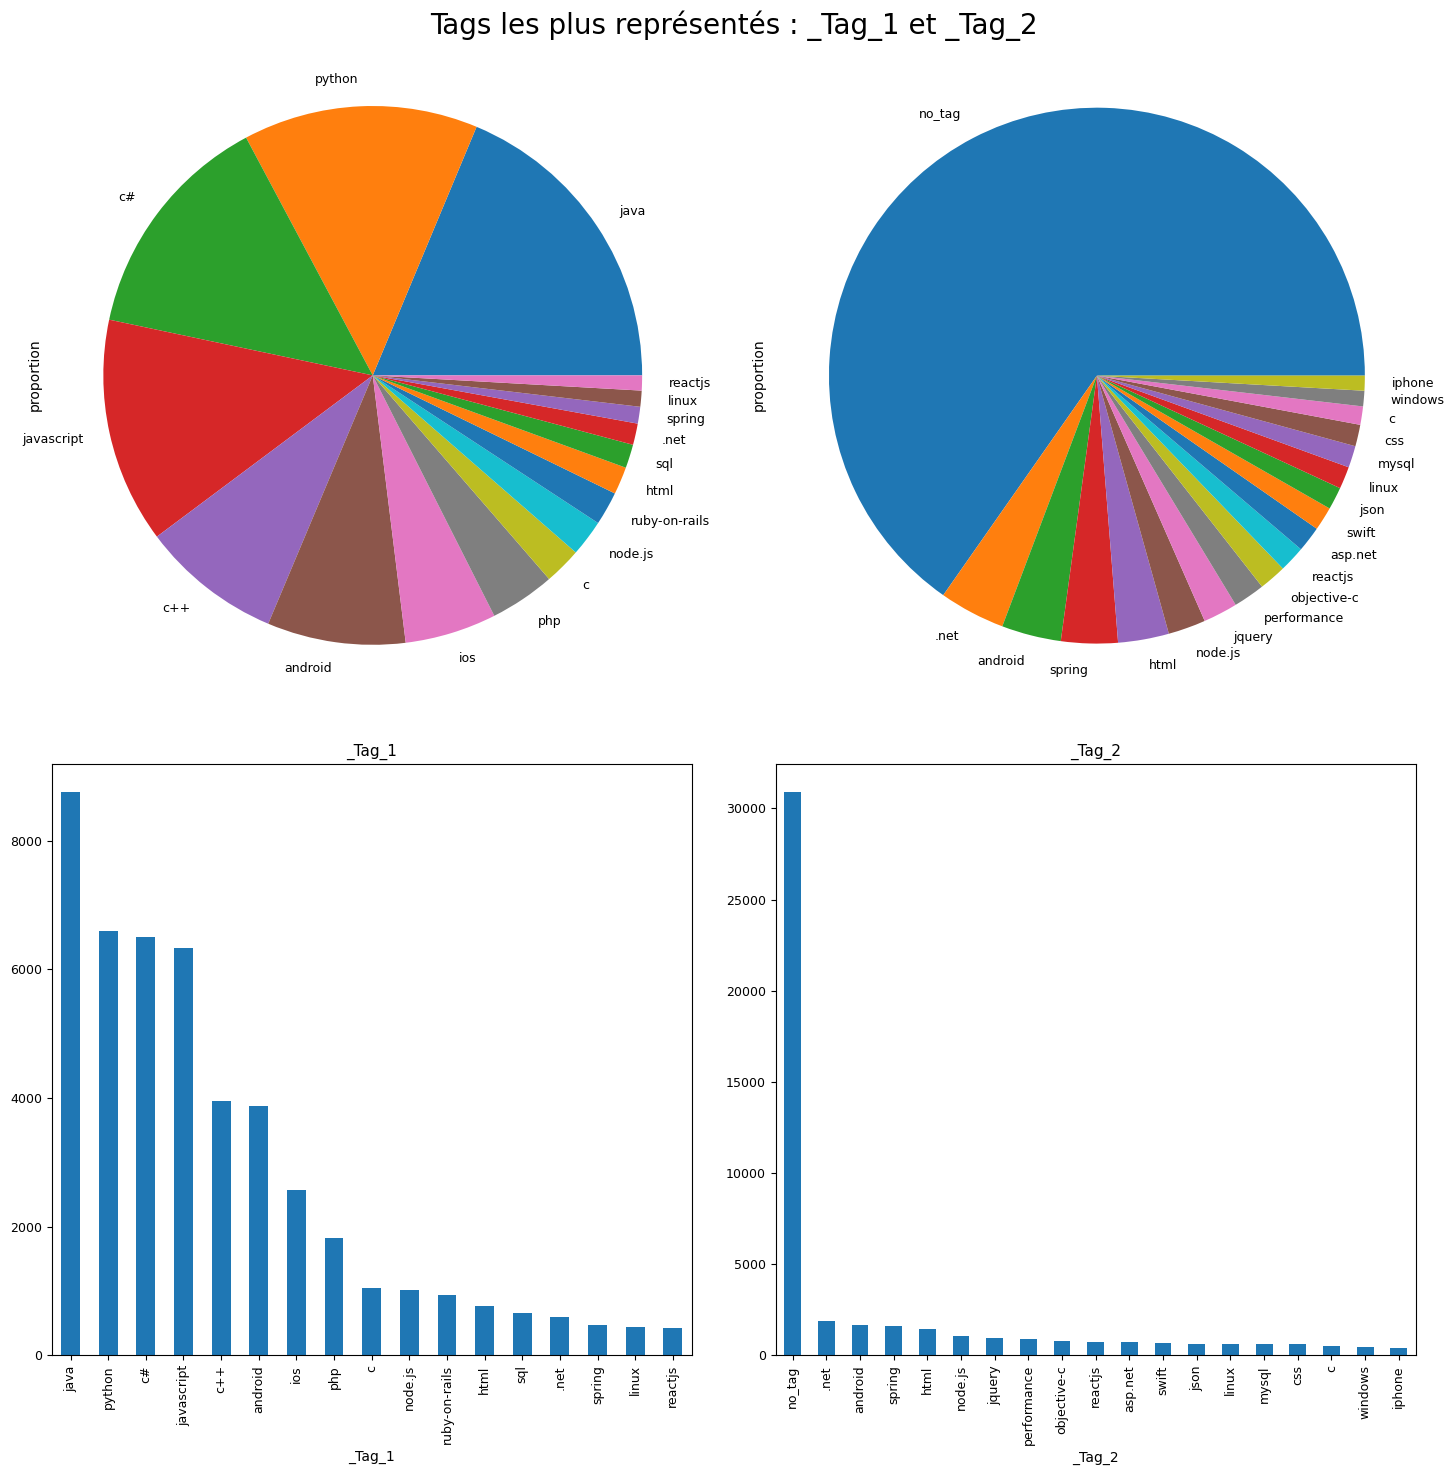

In [247]:
###########################################################
# Visualisation des tags les plus représentés             #
#    - fréquence >= 400 pour _Tag_1                       #
#    - fréquence >= 400 pour _Tag_2                       #
###########################################################
df_1_new = df.where(df['_Tag_1'].isin(intervalle_tag_1))
df_2_new = df.where(df['_Tag_2'].isin(intervalle_tag_2))


plt.figure(figsize = (15, 15))
    
# >>>>>>> Pie chart
plt.subplot(2, 2, 1)   # lignes, colonnes
df_1_new['_Tag_1'].value_counts(normalize = True).plot(kind = 'pie', fontsize = 9)
plt.axis('equal')      # Cette ligne assure que le pie chart est un cercle plutôt qu'une ellipse

plt.subplot(2, 2, 2)   # lignes, colonnes
df_2_new['_Tag_2'].value_counts(normalize = True).plot(kind = 'pie', fontsize = 9)
plt.axis('equal')      # Cette ligne assure que le pie chart est un cercle plutôt qu'une ellipse


# >>>>>>> Diagramme en tuyaux d'orgues
plt.subplot(2, 2, 3)   # lignes, colonnes
df_1_new['_Tag_1'].value_counts().plot(kind = 'bar', fontsize = 9)
plt.title('\n\n\n_Tag_1', fontsize = 11)

plt.subplot(2, 2, 4)   # lignes, colonnes
df_2_new['_Tag_2'].value_counts().plot(kind = 'bar', fontsize = 9)
plt.title('\n\n\n_Tag_2', fontsize = 11)

    
plt.suptitle('Tags les plus représentés : _Tag_1 et _Tag_2\n', fontsize = 20)
plt.tight_layout() # pour éviter chevauchement titre et ligne suivante

# 7.1.2. ETUDE DE LA FREQUENCE DES TAGS (VARIABLE CATEGORIELLE)

In [248]:
###############################################################
# => travail par sous-ensemble :                              #
# Calcul fréquence des tags pour un sous-ensemble             #
###############################################################
def calcul_frequence_tag_sous_ensemble(plage_min_in, plage_max_in):
    
    count_tag_1 = []
    count_tag_2 = []

    tag = new_liste_tags[plage_min_in:plage_max_in]    
    
    # Recherche fréquence pour chaque tag. Si absente, on met 0.
    for t in tag:
        if (t in count_Tag_1):
            count_tag_1.append(count_Tag_1[t])
        else:
            count_tag_1.append(0)
        
        if (t in count_Tag_2):
            count_tag_2.append(count_Tag_2[t])
        else:
            count_tag_2.append(0)
        
    print('[plage_min_in : plage_max_in] = [', plage_min_in, ':', plage_max_in, ']')        
    print(len(tag), 'valeurs tag\t\t:', tag)
    print(len(count_tag_1), 'valeurs count_tag_1\t:', count_tag_1)
    print(len(count_tag_2), 'valeurs count_tag_2\t:', count_tag_2)
    
    return tag, count_tag_1, count_tag_2

In [249]:
###############################################################
# Affichage fréquence des tags pour un sous-ensemble          #
###############################################################
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
def affichage_frequence_tag_sous_ensemble(plage_min_in, plage_max_in):
    
    tag, count_tag_1, count_tag_2 = calcul_frequence_tag_sous_ensemble(plage_min_in = plage_min_in, 
                                                                       plage_max_in = plage_max_in)

    # Intervalle [plage_min_in : plage_max_in]
    df = pd.DataFrame({' _Tag_1': count_tag_1,
                       ' _Tag_2': count_tag_2}, index = tag)
    ax = df.plot.bar(rot = 90, stacked = True, figsize = (20, 6), fontsize = 14)
    ax.set_title('Fréquence des tags ' + str(plage_min_in) + ' --> ' + str(plage_max_in), fontsize = 20)
    ax.set_xlabel('Tags ' + str(plage_min_in) + ' --> ' + str(plage_max_in), fontsize = 14)
    ax.set_ylabel('Fréquence', fontsize = 14)

[plage_min_in : plage_max_in] = [ 0 : 99 ]
28 valeurs tag		: ['java', 'c#', 'javascript', 'python', 'c++', 'android', 'ios', '.net', 'html', 'php', 'jquery', 'objective-c', 'c', 'node.js', 'iphone', 'css', 'linux', 'asp.net', 'swift', 'spring', 'sql', 'xcode', 'performance', 'ruby-on-rails', 'json', 'reactjs', 'windows', 'mysql']
28 valeurs count_tag_1	: [8749, 6499, 6329, 6591, 3953, 3880, 2572, 599, 773, 1828, 349, 317, 1042, 1021, 135, 269, 449, 378, 232, 471, 664, 68, 328, 941, 172, 421, 261, 202]
28 valeurs count_tag_2	: [0, 89, 211, 212, 309, 1698, 234, 1881, 1451, 382, 982, 776, 523, 1070, 425, 616, 635, 729, 674, 1615, 314, 270, 900, 171, 642, 742, 443, 621]


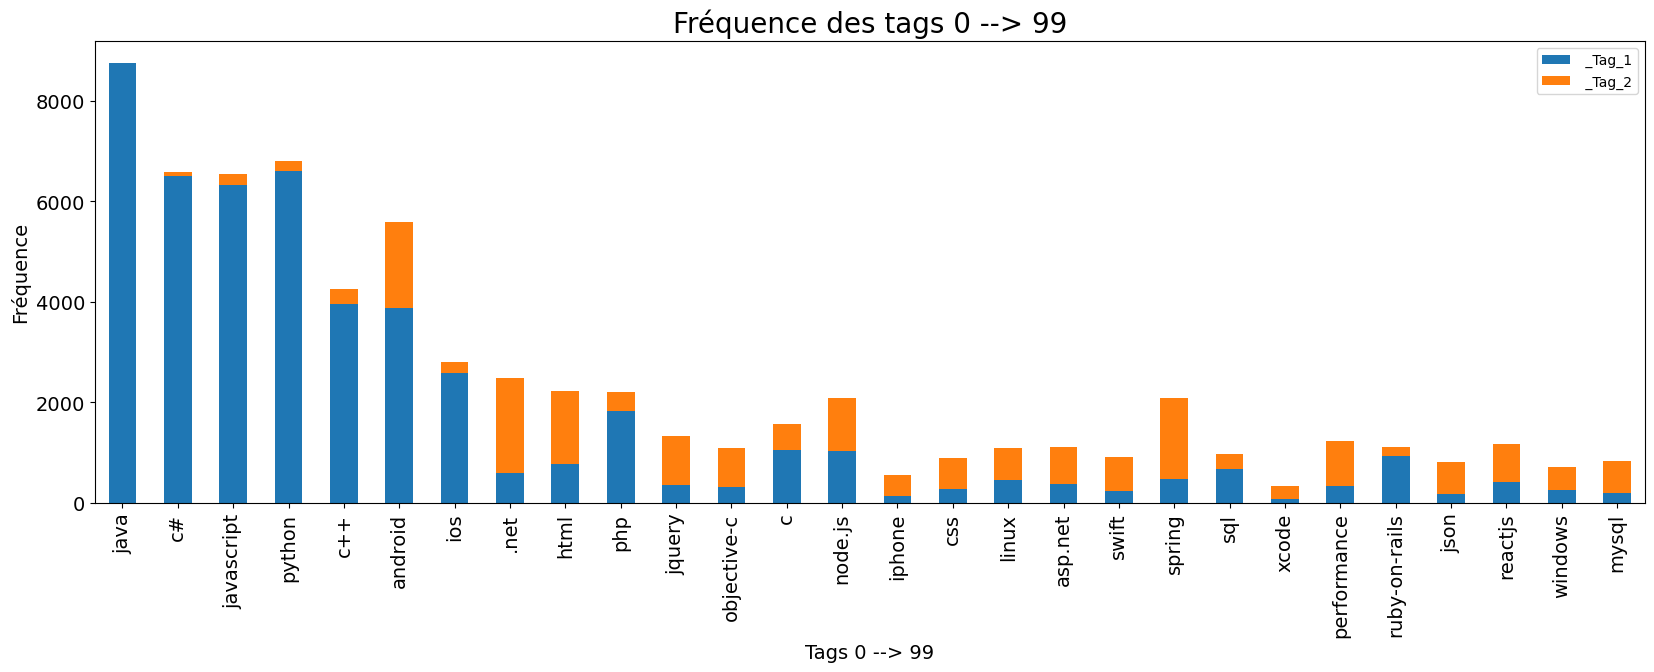

In [258]:
# Intervalle [0 : 99]
affichage_frequence_tag_sous_ensemble(plage_min_in = 0,
                                      plage_max_in = 99)

# 7.1.3. ETUDE DE LA TAILLE DES NOMS DE TAG (VARIABLE QUANTITATIVE)

In [259]:
len_Tag_1 = df['_Tag_1'].str.len() # longueur _Tag_1
len_Tag_2 = df['_Tag_2'].str.len() # longueur _Tag_2

In [260]:
# _Tag_1 : compris entre 1 et 13 caractères
len_Tag_1.describe().transpose()

count    49493.000000
mean         5.201665
std          2.820236
min          1.000000
25%          3.000000
50%          4.000000
75%          7.000000
max         13.000000
Name: _Tag_1, dtype: float64

In [261]:
# _Tag_2 : compris entre 1 et 13 caractères
len_Tag_2.describe().transpose()

count    49493.000000
mean         5.927646
std          1.472888
min          1.000000
25%          6.000000
50%          6.000000
75%          6.000000
max         13.000000
Name: _Tag_2, dtype: float64

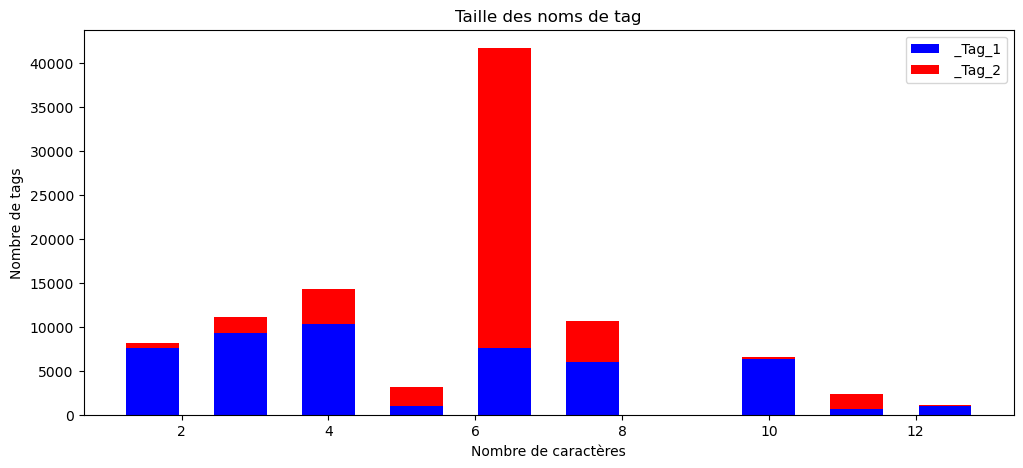

In [262]:
# http://python-simple.com/python-matplotlib/histogram.php
plt.figure(figsize = (12, 5))  # longueur, hauteur
plt.hist([len_Tag_1, len_Tag_2], color = ['blue', 'red'], label = [' _Tag_1', ' _Tag_2'], 
         rwidth = 0.6, histtype = 'barstacked')

plt.legend(loc = 'upper right')
plt.xlabel('Nombre de caractères')
plt.ylabel('Nombre de tags')
plt.title('Taille des noms de tag')
plt.show()

# 7.2. ANALYSE UNIVARIEE TEXTE

In [ ]:
# Rappel des variables :
#  --> corpus_text = ' '.join(df['_Text_clean'])
#  --> token_text = corpus_text.split()
#  --> count_text = pd.Series(token_text).value_counts()

# 7.2.1. ETUDE DE LA FREQUENCE DES MOTS (VARIABLE QUANTITATIVE)

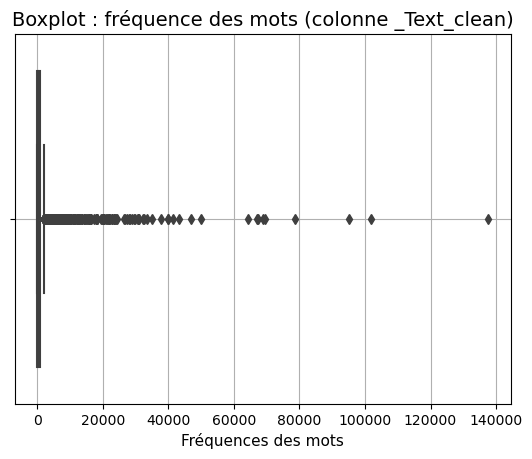

In [263]:
###########################################
# Boxplot fréquence des mots              #
###########################################
# Tout le corpus
ax1 = sns.boxplot(data = df, 
                  x    = count_text)
ax1.set_xlabel('Fréquences des mots', fontsize = 11)
plt.title('Boxplot : fréquence des mots (colonne _Text_clean)', fontsize = 14)
plt.grid(True)

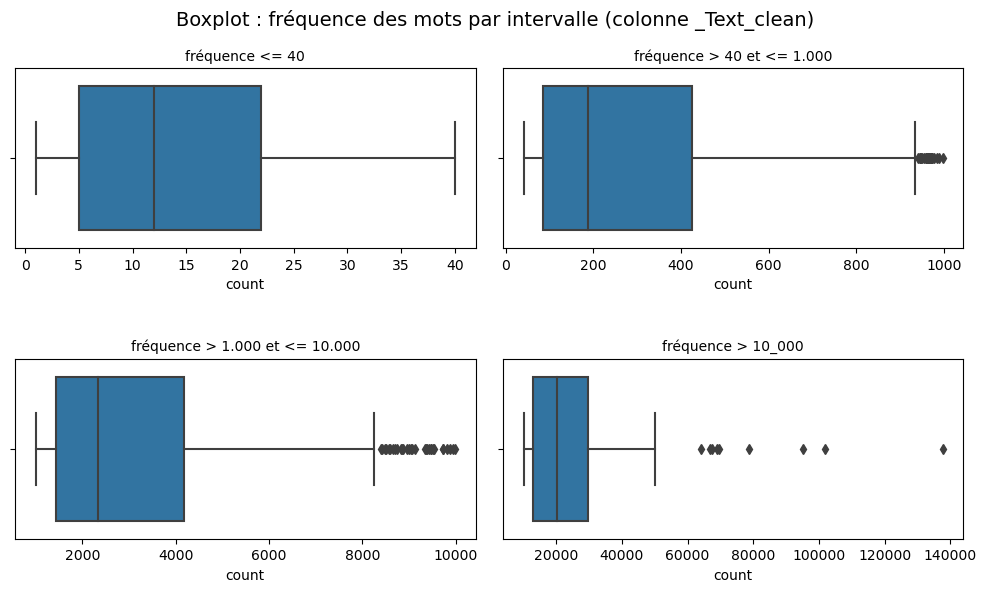

In [264]:
####################################################
# Boxplot fréquence des mots : zoom par intervalle #
####################################################
# Visualisation des données en un seul schéma
fig = plt.figure(figsize = (10, 6))  # Width, height

# Fréquence <= 40
ax = fig.add_subplot(2, 2, 1)   # lignes, colonnes
count_corpus_box = count_text[(count_text <= 40)]    
sns.boxplot(data = df,
            x    = count_corpus_box)
ax.set_title('fréquence <= 40', fontsize = 10)

# Fréquence > 40 et <= 1.000
ax = fig.add_subplot(2, 2, 2)   # lignes, colonnes
count_corpus_box = count_text[(count_text > 40) & (count_text <= 1_000)]    
sns.boxplot(data = df,
            x    = count_corpus_box)
ax.set_title('fréquence > 40 et <= 1.000', fontsize = 10)

# Fréquence > 1.000 et <= 10.000
ax = fig.add_subplot(2, 2, 3)   # lignes, colonnes
count_corpus_box = count_text[(count_text > 1_000) & (count_text <= 10_000)]    
sns.boxplot(data = df,
            x    = count_corpus_box)
ax.set_title('\n\nfréquence > 1.000 et <= 10.000', fontsize = 10)

# Fréquence > 10_000
ax = fig.add_subplot(2, 2, 4) 
count_corpus_box = count_text[(count_text > 10_000)]    
sns.boxplot(data = df,
            x    = count_corpus_box)
ax.set_title('\n\nfréquence > 10_000', fontsize = 10)

    
fig.suptitle('Boxplot : fréquence des mots par intervalle (colonne _Text_clean)', fontsize = 14)
fig.tight_layout() # pour éviter chevauchement titre et ligne suivante

# 7.2.2. ETUDE DE LA LONGUEUR DES DOCUMENTS (VARIABLE QUANTITATIVE)

In [265]:
# Longueur documents
len_Text_clean = df['_Text_clean'].str.len()

In [266]:
# on stocke ce vecteur numérique dans une colonne préfixée par _
df['_len_Text_clean'] = len_Text_clean

# output de sortie pour contrôler que l'opération s'est bien effectuée.
df.describe(include = np.number)

# la grande majorité des messages (50%) fait 147 caractères.
# Certains ont une taille très élevée (8932).

,Id,Score,ViewCount,AnswerCount,_len_Text_clean
count,4.949300e+04,49493.000000,4.949300e+04,49493.000000,49493.000000
mean,3.076258e+07,18.219425,1.790583e+04,3.013638,625.453458
std,1.899073e+07,133.987020,5.770890e+04,2.954516,582.024455
min,1.900000e+01,6.000000,6.700000e+01,1.000000,108.000000
25%,1.424325e+07,7.000000,2.452000e+03,1.000000,332.000000
50%,2.986167e+07,9.000000,6.458000e+03,2.000000,454.000000
75%,4.563654e+07,15.000000,1.642400e+04,4.000000,687.000000
max,7.636308e+07,27009.000000,6.024098e+06,98.000000,11356.000000


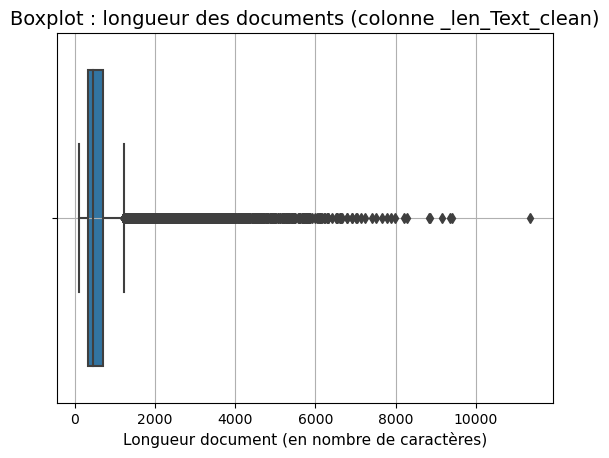

In [267]:
###########################################
# Boxplot longueur de chaque document     #
###########################################
ax1 = sns.boxplot(data = df,
                  x    = '_len_Text_clean')
ax1.set_xlabel('Longueur document (en nombre de caractères)', fontsize = 11)
plt.title('Boxplot : longueur des documents (colonne _len_Text_clean)', fontsize = 14)
plt.grid(True)

Text(0.5, 0.98, 'Displot : longueur des documents (colonne _len_Text_clean)')

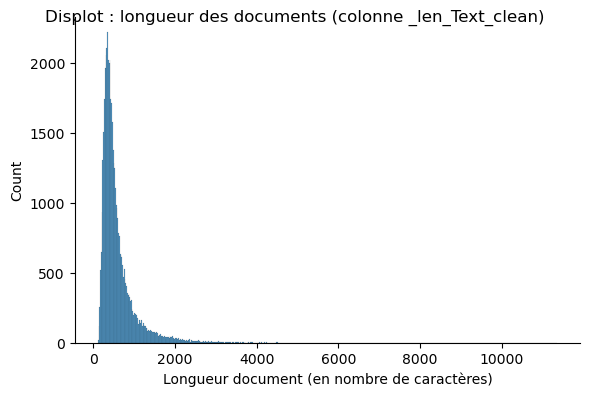

In [268]:
###########################################
# Displot longueur de chaque document     #
###########################################
# https://www.delftstack.com/fr/howto/seaborn/seaborn-font-size/
ax2 = sns.displot(data   = df, 
                  x      = '_len_Text_clean', 
                  height = 4, 
                  aspect = 1.5) # height = 4, width = 1.5 times larger than height

ax2.set_axis_labels('Longueur document (en nombre de caractères)', 'Count')
ax2.fig.suptitle('Displot : longueur des documents (colonne _len_Text_clean)')

# 7.3. FREQUENCE DISTRIBUTION (VARIABLE CATEGORIELLE)

In [269]:
# Stockage de la fréquence de distribution des sous-dataframes dans des dictionnaires
# >>>>>>>  Colonne _Stemmer_clean 
most_common_stemmer_1_gram      = {} # 1-gram
most_common_stemmer_1_gram_word = {} # 1-gram
most_common_stemmer_2_gram      = {} # 2-gram
most_common_stemmer_2_gram_word = {} # 2-gram

# >>>>>>> Colonne _Lemma_clean 
most_common_lemma_3_gram      = {} # 3-gram
most_common_lemma_3_gram_word = {} # 3-gram

In [270]:
####################################################
#   Fréquence distribution, niveau sous-dataframe  # 
####################################################
# https://askcodez.com/comptage-de-n-grammes-de-frequence-en-python-nltk.html
# https://www.askpython.com/python/examples/n-grams-python-nltk
def frequence_distribution_sous_dataframe(n_gram_in, operation_in, cle_in, colonne_in, most_common_in):
    
    most_common_word = []
    
    # Liste des index du sous-dataframe (ne commence pas forcément à 0, car filtré)
    liste_index = dict_df[cle_in].index.to_list()

    print('n_gram_in\t=', n_gram_in,
          '\noperation_in\t=', operation_in,
          '\ncle_in\t\t=', cle_in,
          '\ncolonne_in\t=', colonne_in, '\n')
    
    for index, row in dict_df[cle_in].iterrows():
        token = word_tokenize(row[colonne_in])
        
        # ngram
        if (n_gram_in == 1):
            n_grams = token
        else:
            n_grams = ngrams(token, n_gram_in)
        
        # Frequence distribution
        if (index == liste_index[0]):  # premier index du sous-dataframe
            ngram_fdist = FreqDist(n_grams)            
        elif (operation_in == '+'):
            ngram_fdist = ngram_fdist + FreqDist(n_grams)
        elif (operation_in == '&'):
            ngram_fdist = ngram_fdist & FreqDist(n_grams)            

    # most_common_in most common words
    most_common = ngram_fdist.most_common(most_common_in)
    print(most_common_in, 'most_common :', most_common, '\n')
    
    
    # Extraction liste des mots les plus communs dans une liste
    # Remarque : ind[0] = mot, ind[1] = valeur
    for ind in most_common:
        most_common_word.append(ind[0])
    print('most_common_word =', most_common_word)
    
    return most_common, most_common_word

In [271]:
#################################################
#      Affichage fréquence distribution         #
#################################################
# Couleurs  : https://matplotlib.org/stable/gallery/color/named_colors.html
# Marqueurs : https://matplotlib.org/stable/api/markers_api.html
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
def affichage_frequence_distribution_sous_dataframe(most_common_n_gram_in, 
                                                    name_in, 
                                                    cle_1_in, 
                                                    cle_2_in, 
                                                    intersection_cles_in):
    
    most_common_1 = most_common_n_gram_in[cle_1_in]
    most_common_2 = most_common_n_gram_in[cle_2_in]
  
    count1 = 0 
    count2 = 0     
    
    fig = plt.figure(figsize = (7, 4))  # Width, height
    
    # Maj couleurs : 1 couleur / clé
    # >>>>>>> Couleur 1    
    if (cle_1_in == 'java'):
        color_1 = 'blue'
    elif (cle_1_in == 'c#'):
        color_1 = 'red'
    elif (cle_1_in == 'javascript'):
        color_1 = 'lime'
    elif (cle_1_in == 'python'):
        color_1 = 'orange'        
    elif (cle_1_in == 'c++'):
        color_1 = 'fuchsia'
        
    # >>>>>>> Couleur 2
    if (cle_2_in == 'java'):
        color_2 = 'blue'
    elif (cle_2_in == 'c#'):
        color_2 = 'red'
    elif (cle_2_in == 'javascript'):
        color_2 = 'lime'
    elif (cle_2_in == 'python'):
        color_2 = 'orange'        
    elif (cle_2_in == 'c++'):
        color_2 = 'fuchsia'        

    
    # *******************************************
    # * Liste 1                                 *
    # *******************************************    
    for ind_1 in most_common_1: # liste de tuples
        if (ind_1[0] in intersection_cles_in):
            if (count1 == 0): # Premier passage : légende marquée une fois
                if ('1-gram' in name_in): # 1-gram
                    plt.plot(ind_1[0], ind_1[1], color = color_1, marker = 'o', linestyle = 'dashed', label = cle_1_in)
                else: # n-gram != 1
                    plt.plot(' '.join(ind_1[0]), ind_1[1], color = color_1, marker = 'o', 
                             linestyle = 'dashed', label = cle_1_in)
                count1 = 1
            else:
                if ('1-gram' in name_in): # 1-gram
                    plt.plot(ind_1[0], ind_1[1], color = color_1, marker = 'o', linestyle = 'dashed')
                else: # n-gram != 1
                    plt.plot(' '.join(ind_1[0]), ind_1[1], color = color_1, marker = 'o', 
                             linestyle = 'dashed')
            
            
    # *******************************************
    # * Liste 2                                 *
    # *******************************************
    for ind_2 in most_common_2: # liste de tuples
        if (ind_2[0] in intersection_cles_in):
            if (count2 == 0):  # Premier passage : légende marquée une fois
                if ('1-gram' in name_in): # 1-gram                
                    plt.plot(ind_2[0], ind_2[1], color = color_2, marker = 'o', linestyle = 'dashed', label = cle_2_in)
                else: # n-gram != 1
                    plt.plot(' '.join(ind_2[0]), ind_2[1], color = color_2, marker = 'o', 
                             linestyle = 'dashed', label = cle_2_in)
                count2 = 1
            else:
                if ('1-gram' in name_in): # 1-gram                
                    plt.plot(ind_2[0], ind_2[1], color = color_2, marker = 'o', linestyle = 'dashed') 
                else: # n-gram != 1
                    plt.plot(' '.join(ind_2[0]), ind_2[1], color = color_2, marker = 'o', 
                             linestyle = 'dashed')
                    
    plt.legend(loc = 'upper right')
    plt.xlabel('Mots')
    plt.xticks(rotation = 90) # légende axe des x verticale
    plt.ylabel('Fréquence')
    plt.title(name_in + ' : ' + str(len(intersection_cles_in)) + ' mots les plus communs entre ' + cle_1_in + 
              ' et ' + cle_2_in + ' ')
    plt.show()

# 7.3.1. FREQUENCE DISTRIBUTION COLONNE _STEMMER_CLEAN POUR 1-GRAM

In [272]:
# Maj paramètres communs
n_gram      = 1
operation   = '+'
colonne     = '_Stemmer_clean_final'
most_common = 50

In [273]:
# java
most_common_stemmer_1_gram['java'], most_common_stemmer_1_gram_word['java'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'java', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common)

n_gram_in	= 1 
operation_in	= + 
cle_in		= java 
colonne_in	= _Stemmer_clean_final 

50 most_common : [('java', 101590), ('public', 31965), ('class', 26966), ('android', 26641), ('string', 23469), ('apach', 17886), ('version', 16382), ('spring', 16066), ('jar', 15922), ('import', 14337), ('return', 14209), ('privat', 14166), ('void', 12927), ('web', 12683), ('file', 11065), ('hibern', 11000), ('core', 10504), ('final', 10264), ('get', 10122), ('sun', 10067), ('intern', 9807), ('null', 9746), ('except', 8837), ('secur', 8670), ('releas', 8641), ('server', 7896), ('system', 7836), ('boot', 7799), ('static', 7548), ('list', 6889), ('build', 6530), ('object', 6497), ('execut', 6313), ('project', 6229), ('servic', 6219), ('configur', 6077), ('invok', 6051), ('layout', 6025), ('eclips', 6016), ('set', 5993), ('view', 5940), ('catalina', 5827), ('add', 5582), ('factori', 5418), ('client', 5408), ('request', 5089), ('connect', 5031), ('key', 4889), ('time', 4746), ('messag', 4203)] 

most_comm

In [274]:
# c#
most_common_stemmer_1_gram['c#'], most_common_stemmer_1_gram_word['c#'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'c#', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common)

n_gram_in	= 1 
operation_in	= + 
cle_in		= c# 
colonne_in	= _Stemmer_clean_final 

50 most_common : [('public', 24226), ('system', 19400), ('string', 16276), ('get', 13726), ('class', 12157), ('set', 10369), ('return', 9425), ('object', 7871), ('void', 6793), ('add', 6158), ('null', 6155), ('web', 5975), ('privat', 5917), ('file', 5849), ('static', 5237), ('except', 5048), ('task', 4843), ('list', 4597), ('server', 4463), ('version', 4149), ('servic', 3786), ('project', 3783), ('text', 3781), ('time', 3777), ('client', 3754), ('key', 3660), ('request', 3635), ('model', 3453), ('messag', 3419), ('bind', 3407), ('consol', 3293), ('configur', 3102), ('entiti', 2943), ('call', 2924), ('connect', 2811), ('load', 2750), ('core', 2717), ('respons', 2571), ('refer', 2371), ('line', 2342), ('path', 2288), ('select', 2269), ('function', 2267), ('edit', 2246), ('view', 2199), ('solut', 2193), ('case', 2114), ('build', 2103), ('find', 1967), ('control', 1923)] 

most_common_word = ['public', 'syst

In [275]:
# javascript
most_common_stemmer_1_gram['javascript'], most_common_stemmer_1_gram_word['javascript'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'javascript', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common)

n_gram_in	= 1 
operation_in	= + 
cle_in		= javascript 
colonne_in	= _Stemmer_clean_final 

50 most_common : [('function', 20694), ('class', 14896), ('return', 8657), ('text', 8164), ('get', 7311), ('file', 7274), ('consol', 6819), ('import', 5964), ('button', 5800), ('input', 5311), ('server', 5009), ('width', 4813), ('document', 4786), ('requir', 4352), ('object', 4312), ('load', 4251), ('modul', 4177), ('request', 3843), ('height', 3822), ('imag', 3705), ('set', 3653), ('select', 3556), ('post', 3520), ('angular', 3509), ('click', 3487), ('path', 3487), ('respons', 3470), ('titl', 3321), ('window', 3246), ('state', 3185), ('string', 3036), ('null', 2892), ('label', 2858), ('add', 2853), ('element', 2819), ('browser', 2753), ('default', 2744), ('client', 2655), ('time', 2643), ('messag', 2600), ('let', 2575), ('render', 2526), ('size', 2510), ('loader', 2474), ('build', 2360), ('web', 2303), ('background', 2287), ('min', 2237), ('find', 2205), ('scope', 2200)] 

most_common_word = ['f

In [276]:
# python
most_common_stemmer_1_gram['python'], most_common_stemmer_1_gram_word['python'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'python', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common)

n_gram_in	= 1 
operation_in	= + 
cle_in		= python 
colonne_in	= _Stemmer_clean_final 

50 most_common : [('self', 27711), ('file', 21142), ('python', 19649), ('import', 17022), ('line', 14557), ('get', 11741), ('return', 10341), ('model', 9124), ('class', 7927), ('time', 7088), ('local', 6777), ('build', 6387), ('function', 6004), ('modul', 5672), ('set', 5621), ('size', 5129), ('path', 4919), ('output', 4772), ('input', 4601), ('add', 4569), ('request', 4565), ('list', 4488), ('imag', 4329), ('call', 4211), ('text', 3957), ('object', 3809), ('connect', 3503), ('except', 3434), ('key', 3427), ('pip', 3399), ('version', 3363), ('command', 3174), ('server', 3055), ('respons', 2982), ('load', 2954), ('loss', 2904), ('client', 2903), ('string', 2866), ('find', 2851), ('process', 2764), ('rang', 2687), ('max', 2634), ('messag', 2588), ('core', 2524), ('random', 2378), ('execut', 2377), ('default', 2375), ('includ', 2335), ('flask', 2322), ('bin', 2314)] 

most_common_word = ['self', 'file',

In [277]:
# c++
most_common_stemmer_1_gram['c++'], most_common_stemmer_1_gram_word['c++'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'c++', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common)

n_gram_in	= 1 
operation_in	= + 
cle_in		= c++ 
colonne_in	= _Stemmer_clean_final 

50 most_common : [('includ', 9175), ('class', 7963), ('void', 7554), ('return', 7378), ('function', 6586), ('boost', 6358), ('size', 5658), ('string', 5178), ('char', 5113), ('file', 4760), ('vector', 4078), ('get', 4076), ('time', 3806), ('static', 3440), ('memori', 3273), ('doubl', 3165), ('set', 3026), ('public', 2849), ('build', 2712), ('object', 2709), ('call', 2574), ('auto', 2430), ('version', 2419), ('refer', 2129), ('output', 2038), ('clang', 2031), ('case', 2022), ('system', 2018), ('local', 1904), ('null', 1867), ('find', 1821), ('add', 1790), ('bin', 1749), ('load', 1738), ('list', 1674), ('alloc', 1598), ('line', 1586), ('copi', 1566), ('gnu', 1529), ('point', 1523), ('project', 1510), ('bit', 1488), ('buffer', 1486), ('back', 1421), ('move', 1377), ('default', 1373), ('constructor', 1314), ('except', 1305), ('virtual', 1278), ('releas', 1258)] 

most_common_word = ['includ', 'class', 'void

In [278]:
###################################################
#    Intersection entre les 5 sous-dataframes     #
###################################################
# https://www.cours-gratuit.com/tutoriel-python/tutoriel-python-trouver-lintersection-de-deux-listes
set_java_stemmer_1_gram        = set(most_common_stemmer_1_gram_word['java'])
set_c_sharp_stemmer_1_gram     = set(most_common_stemmer_1_gram_word['c#']) 
set_javascript_stemmer_1_gram  = set(most_common_stemmer_1_gram_word['javascript']) 
set_python_stemmer_1_gram      = set(most_common_stemmer_1_gram_word['python']) 
set_c_plus_plus_stemmer_1_gram = set(most_common_stemmer_1_gram_word['c++']) 

intersection_java_c_sharp_stemmer_1_gram     = list(set_java_stemmer_1_gram & set_c_sharp_stemmer_1_gram)
intersection_java_javascript_stemmer_1_gram  = list(set_java_stemmer_1_gram & set_javascript_stemmer_1_gram)
intersection_java_python_stemmer_1_gram      = list(set_java_stemmer_1_gram & set_python_stemmer_1_gram)
intersection_java_c_plus_plus_stemmer_1_gram = list(set_java_stemmer_1_gram & set_c_plus_plus_stemmer_1_gram)
intersection_all_stemmer_1_gram              = list(set_java_stemmer_1_gram & set_c_sharp_stemmer_1_gram & \
                                                    set_javascript_stemmer_1_gram & set_python_stemmer_1_gram & \
                                                    set_c_plus_plus_stemmer_1_gram)

print('intersection_java_c_sharp_stemmer_1_gram\t=', intersection_java_c_sharp_stemmer_1_gram)
print('intersection_java_javascript_stemmer_1_gram\t=', intersection_java_javascript_stemmer_1_gram)
print('intersection_java_python_stemmer_1_gram\t\t=', intersection_java_python_stemmer_1_gram)
print('intersection_java_c_plus_plus_stemmer_1_gram\t=', intersection_java_c_plus_plus_stemmer_1_gram)
print('intersection_all_stemmer_1_gram\t\t\t=', intersection_all_stemmer_1_gram)

intersection_java_c_sharp_stemmer_1_gram	= ['server', 'static', 'servic', 'core', 'privat', 'class', 'request', 'file', 'client', 'void', 'messag', 'connect', 'project', 'add', 'list', 'view', 'build', 'public', 'null', 'except', 'object', 'version', 'web', 'system', 'time', 'configur', 'set', 'string', 'get', 'return', 'key']
intersection_java_javascript_stemmer_1_gram	= ['client', 'web', 'import', 'server', 'time', 'set', 'add', 'build', 'class', 'request', 'messag', 'null', 'string', 'get', 'object', 'file', 'return']
intersection_java_python_stemmer_1_gram		= ['import', 'server', 'core', 'class', 'request', 'file', 'client', 'messag', 'connect', 'execut', 'add', 'list', 'build', 'except', 'object', 'version', 'time', 'set', 'string', 'get', 'return', 'key']
intersection_java_c_plus_plus_stemmer_1_gram	= ['static', 'class', 'file', 'void', 'project', 'add', 'list', 'build', 'public', 'null', 'except', 'object', 'version', 'system', 'time', 'releas', 'set', 'string', 'get', 'return']

In [ ]:
####################################################
#       Affichage fréquence distribution           #
####################################################

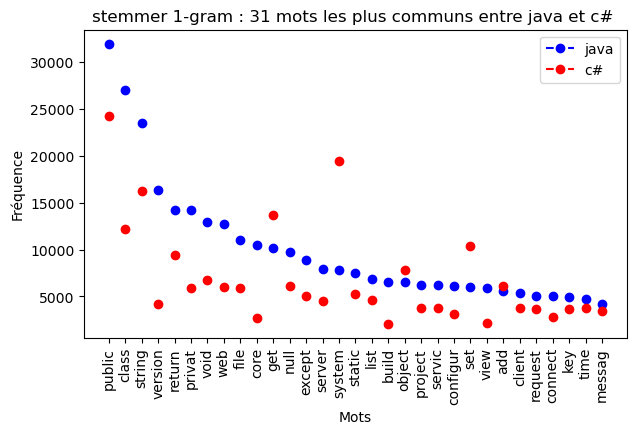

In [279]:
# Intersection mots java / c#
affichage_frequence_distribution_sous_dataframe(most_common_n_gram_in = most_common_stemmer_1_gram,
                                                name_in               = 'stemmer 1-gram',
                                                cle_1_in              = 'java', 
                                                cle_2_in              = 'c#',
                                                intersection_cles_in  = intersection_java_c_sharp_stemmer_1_gram)

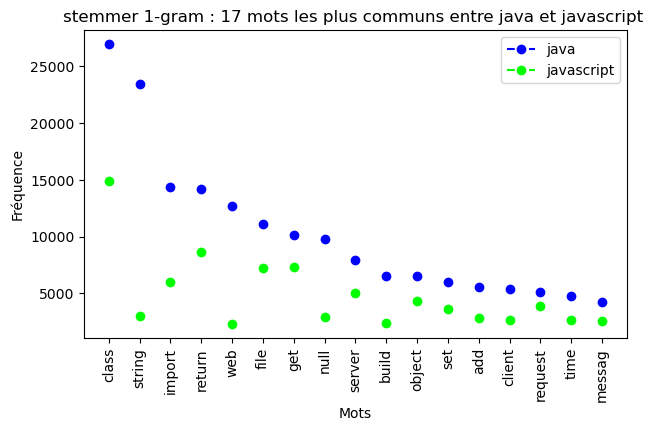

In [280]:
# Intersection mots java / javascript
affichage_frequence_distribution_sous_dataframe(most_common_n_gram_in = most_common_stemmer_1_gram,
                                                name_in               = 'stemmer 1-gram',
                                                cle_1_in              = 'java', 
                                                cle_2_in              = 'javascript',
                                                intersection_cles_in  = intersection_java_javascript_stemmer_1_gram)

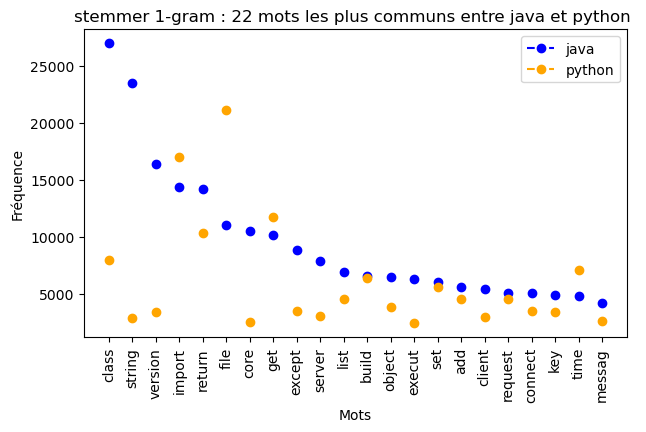

In [281]:
# Intersection mots java / python
affichage_frequence_distribution_sous_dataframe(most_common_n_gram_in = most_common_stemmer_1_gram,
                                                name_in               = 'stemmer 1-gram',
                                                cle_1_in              = 'java', 
                                                cle_2_in              = 'python',
                                                intersection_cles_in  = intersection_java_python_stemmer_1_gram)

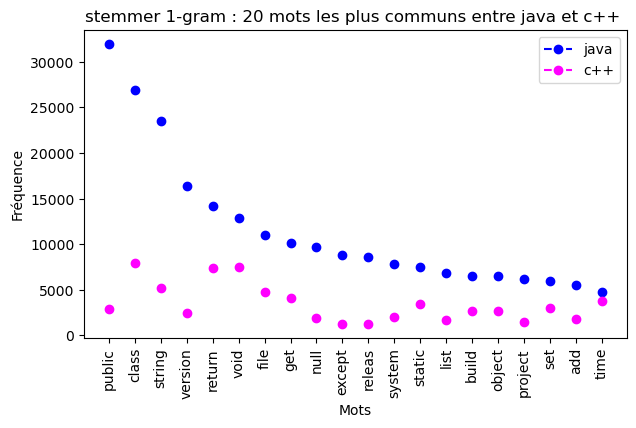

In [282]:
# Intersection mots java / c++
affichage_frequence_distribution_sous_dataframe(most_common_n_gram_in = most_common_stemmer_1_gram,
                                                name_in               = 'stemmer 1-gram',
                                                cle_1_in              = 'java', 
                                                cle_2_in              = 'c++',
                                                intersection_cles_in  = intersection_java_c_plus_plus_stemmer_1_gram)

# 7.3.2. FREQUENCE DISTRIBUTION COLONNE _STEMMER_CLEAN POUR 2-GRAM

In [283]:
# Maj paramètres communs
n_gram      = 2
operation   = '+'
colonne     = '_Stemmer_clean_final'
most_common = 50

In [284]:
# java
most_common_stemmer_2_gram['java'], most_common_stemmer_2_gram_word['java'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'java', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common)

n_gram_in	= 2 
operation_in	= + 
cle_in		= java 
colonne_in	= _Stemmer_clean_final 

50 most_common : [(('java', 'java'), 21467), (('java', 'apach'), 9256), (('public', 'void'), 8316), (('android', 'android'), 7190), (('public', 'class'), 7004), (('java', 'sun'), 5716), (('version', 'version'), 5481), (('apach', 'catalina'), 5310), (('invok', 'java'), 5116), (('java', 'android'), 4724), (('intern', 'java'), 4380), (('spring', 'boot'), 4097), (('android', 'layout'), 4057), (('class', 'public'), 3905), (('string', 'string'), 3809), (('return', 'public'), 3540), (('import', 'java'), 3509), (('public', 'static'), 3403), (('releas', 'jar'), 3327), (('class', 'privat'), 3305), (('java', 'spring'), 3234), (('jar', 'releas'), 3232), (('java', 'intern'), 3214), (('catalina', 'core'), 3163), (('core', 'java'), 3044), (('java', 'hibern'), 3021), (('web', 'java'), 2983), (('execut', 'java'), 2959), (('java', 'eclips'), 2916), (('public', 'string'), 2871), (('factori', 'java'), 2855), (('void', 'st

In [285]:
# c#
most_common_stemmer_2_gram['c#'], most_common_stemmer_2_gram_word['c#'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'c#', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common)

n_gram_in	= 2 
operation_in	= + 
cle_in		= c# 
colonne_in	= _Stemmer_clean_final 

50 most_common : [(('get', 'set'), 5613), (('system', 'system'), 4990), (('set', 'public'), 4727), (('public', 'class'), 4043), (('class', 'public'), 3620), (('public', 'string'), 3228), (('public', 'get'), 2998), (('string', 'string'), 2649), (('system', 'web'), 2553), (('public', 'void'), 2482), (('string', 'get'), 2382), (('public', 'static'), 2351), (('public', 'public'), 1619), (('static', 'void'), 1448), (('privat', 'void'), 1229), (('web', 'system'), 1156), (('return', 'public'), 1102), (('void', 'string'), 1097), (('get', 'return'), 1096), (('privat', 'static'), 1032), (('object', 'sender'), 1025), (('class', 'privat'), 1003), (('null', 'null'), 944), (('task', 'task'), 929), (('string', 'system'), 890), (('model', 'model'), 863), (('object', 'object'), 860), (('list', 'list'), 769), (('except', 'system'), 756), (('class', 'class'), 747), (('system', 'string'), 744), (('public', 'virtual'), 743),

In [286]:
# javascript
most_common_stemmer_2_gram['javascript'], most_common_stemmer_2_gram_word['javascript'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'javascript', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common)

n_gram_in	= 2 
operation_in	= + 
cle_in		= javascript 
colonne_in	= _Stemmer_clean_final 

50 most_common : [(('class', 'class'), 2548), (('function', 'return'), 2185), (('function', 'function'), 2070), (('import', 'import'), 1860), (('width', 'height'), 1577), (('function', 'consol'), 1460), (('button', 'button'), 1220), (('input', 'text'), 1079), (('return', 'function'), 1014), (('text', 'text'), 971), (('file', 'file'), 948), (('requir', 'requir'), 937), (('export', 'default'), 912), (('button', 'class'), 902), (('loader', 'loader'), 896), (('consol', 'consol'), 882), (('class', 'col'), 841), (('click', 'function'), 812), (('object', 'object'), 767), (('angular', 'angular'), 758), (('titl', 'titl'), 722), (('label', 'label'), 678), (('document', 'function'), 666), (('select', 'select'), 624), (('return', 'return'), 585), (('string', 'string'), 573), (('text', 'input'), 565), (('function', 'document'), 565), (('imag', 'imag'), 554), (('modul', 'modul'), 548), (('null', 'null'), 545),

In [287]:
# python
most_common_stemmer_2_gram['python'], most_common_stemmer_2_gram_word['python'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'python', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common)

n_gram_in	= 2 
operation_in	= + 
cle_in		= python 
colonne_in	= _Stemmer_clean_final 

50 most_common : [(('self', 'self'), 8242), (('import', 'import'), 6134), (('file', 'line'), 3877), (('file', 'local'), 3078), (('python', 'python'), 2710), (('build', 'build'), 2220), (('line', 'modul'), 2130), (('return', 'self'), 2007), (('call', 'file'), 1662), (('file', 'python'), 1630), (('model', 'model'), 1599), (('self', 'file'), 1494), (('python', 'line'), 1401), (('time', 'time'), 1384), (('file', 'file'), 1346), (('self', 'return'), 1334), (('local', 'python'), 1326), (('line', 'self'), 1190), (('model', 'add'), 1102), (('class', 'class'), 1092), (('line', 'file'), 1045), (('loss', 'loss'), 1013), (('local', 'line'), 918), (('import', 'file'), 892), (('modul', 'import'), 886), (('python', 'import'), 873), (('nan', 'nan'), 824), (('class', 'self'), 823), (('modul', 'file'), 804), (('imag', 'imag'), 771), (('core', 'line'), 750), (('size', 'size'), 694), (('self', 'get'), 677), (('path', 'p

In [288]:
# c++
most_common_stemmer_2_gram['c++'], most_common_stemmer_2_gram_word['c++'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'c++', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common)

n_gram_in	= 2 
operation_in	= + 
cle_in		= c++ 
colonne_in	= _Stemmer_clean_final 

50 most_common : [(('includ', 'includ'), 3137), (('class', 'class'), 1674), (('char', 'char'), 1412), (('boost', 'boost'), 1314), (('size', 'size'), 1267), (('void', 'void'), 1235), (('class', 'public'), 1091), (('doubl', 'doubl'), 1023), (('string', 'string'), 891), (('return', 'return'), 835), (('vector', 'vector'), 751), (('includ', 'boost'), 717), (('push', 'back'), 683), (('function', 'function'), 682), (('bin', 'bin'), 642), (('file', 'file'), 622), (('time', 'time'), 620), (('basic', 'string'), 567), (('string', 'char'), 519), (('memori', 'memori'), 491), (('local', 'includ'), 474), (('null', 'null'), 462), (('void', 'boost'), 440), (('static', 'assert'), 437), (('function', 'void'), 432), (('includ', 'string'), 410), (('gnu', 'gnu'), 398), (('public', 'void'), 397), (('text', 'refer'), 393), (('includ', 'class'), 390), (('boost', 'variant'), 389), (('includ', 'vector'), 382), (('build', 'releas'

In [ ]:
################################################################################
#   Vérification valeurs nan : valeur manquante (NaN) ou éléments du texte ?   #
################################################################################

In [289]:
# Valeurs manquantes (NaN) ?
nb_na = df.isna().sum()
nb_na[nb_na > 0]

Series([], dtype: int64)

In [290]:
# Eléments du texte ?
count = 0
for index, row in df.iterrows():
    if ((count == 0) & 
        (' nan ' in row['_Lemma_clean_final'])):
        print('index =', index, ':',
              '\n* _Text =', row['_Text'],
              '\n* _Lemma_clean_final =', row['_Lemma_clean_final'])
        break

index = 1362 : 
* _Text = Why does "dtoa.c" contain so much code? <p>I'll be the first to admit that my overall knowledge of low level programming is a bit sparse. I understand  many of the core concepts but I do not use them on a regular basis.
That being said I was absolutely astounded at how much code was needed for <a href="http://www.netlib.org/fp/dtoa.c" rel="noreferrer">dtoa.c</a>.</p>

<p>For the past couple months I have been working on an ECMAScript implementation in C# and I've been slowing filling in the holes in my engine. Last night I started working on <strong>Number.prototype.toString</strong> which is described in section <strong>15.7.4.2</strong> of the <a href="http://es5.github.io/#x15.7.4.2" rel="noreferrer">ECMAScript specification</a> <a href="http://www.ecma-international.org/publications/files/ECMA-ST/ECMA-262.pdf" rel="noreferrer">(pdf)</a>. In section <strong>9.8.1</strong>, NOTE 3 offers a link to <em>dtoa.c</em> but I was looking for a challenge so I waited

In [291]:
###################################################
#    Intersection entre les 5 sous-dataframes     #
###################################################
# https://www.cours-gratuit.com/tutoriel-python/tutoriel-python-trouver-lintersection-de-deux-listes
set_java_stemmer_2_gram        = set(most_common_stemmer_2_gram_word['java'])
set_c_sharp_stemmer_2_gram     = set(most_common_stemmer_2_gram_word['c#']) 
set_javascript_stemmer_2_gram  = set(most_common_stemmer_2_gram_word['javascript']) 
set_python_stemmer_2_gram      = set(most_common_stemmer_2_gram_word['python']) 
set_c_plus_plus_stemmer_2_gram = set(most_common_stemmer_2_gram_word['c++']) 

intersection_java_c_sharp_stemmer_2_gram     = list(set_java_stemmer_2_gram & set_c_sharp_stemmer_2_gram)
intersection_java_javascript_stemmer_2_gram  = list(set_java_stemmer_2_gram & set_javascript_stemmer_2_gram)
intersection_java_python_stemmer_2_gram      = list(set_java_stemmer_2_gram & set_python_stemmer_2_gram)
intersection_java_c_plus_plus_stemmer_2_gram = list(set_java_stemmer_2_gram & set_c_plus_plus_stemmer_2_gram)
intersection_all_stemmer_2_gram              = list(set_java_stemmer_2_gram & set_c_sharp_stemmer_2_gram & \
                                                    set_javascript_stemmer_2_gram & set_python_stemmer_2_gram & \
                                                    set_c_plus_plus_stemmer_2_gram)

print('intersection_java_c_sharp_stemmer_2_gram\t=', intersection_java_c_sharp_stemmer_2_gram)
print('intersection_java_javascript_stemmer_2_gram\t=', intersection_java_javascript_stemmer_2_gram)
print('intersection_java_python_stemmer_2_gram\t\t=', intersection_java_python_stemmer_2_gram)
print('intersection_java_c_plus_plus_stemmer_2_gram\t=', intersection_java_c_plus_plus_stemmer_2_gram)
print('intersection_all_stemmer_2_gram\t\t\t=', intersection_all_stemmer_2_gram)

intersection_java_c_sharp_stemmer_2_gram	= [('void', 'string'), ('class', 'class'), ('static', 'void'), ('privat', 'privat'), ('public', 'void'), ('string', 'string'), ('privat', 'static'), ('class', 'public'), ('class', 'privat'), ('public', 'static'), ('public', 'string'), ('return', 'public'), ('public', 'class'), ('string', 'public')]
intersection_java_javascript_stemmer_2_gram	= [('class', 'class'), ('import', 'import'), ('string', 'string')]
intersection_java_python_stemmer_2_gram		= [('class', 'class'), ('java', 'java'), ('import', 'import')]
intersection_java_c_plus_plus_stemmer_2_gram	= [('class', 'class'), ('version', 'version'), ('public', 'void'), ('string', 'string'), ('class', 'public')]
intersection_all_stemmer_2_gram			= [('class', 'class')]


In [ ]:
####################################################
#       Affichage fréquence distribution           #
####################################################
# On affiche les distributions qui ont des intersections.

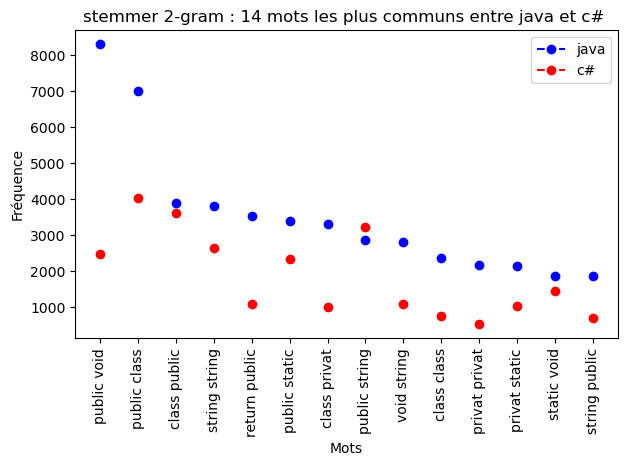

In [292]:
# Intersection mots java / c#
affichage_frequence_distribution_sous_dataframe(most_common_n_gram_in = most_common_stemmer_2_gram,
                                                name_in               = 'stemmer 2-gram',
                                                cle_1_in              = 'java', 
                                                cle_2_in              = 'c#',
                                                intersection_cles_in  = intersection_java_c_sharp_stemmer_2_gram)

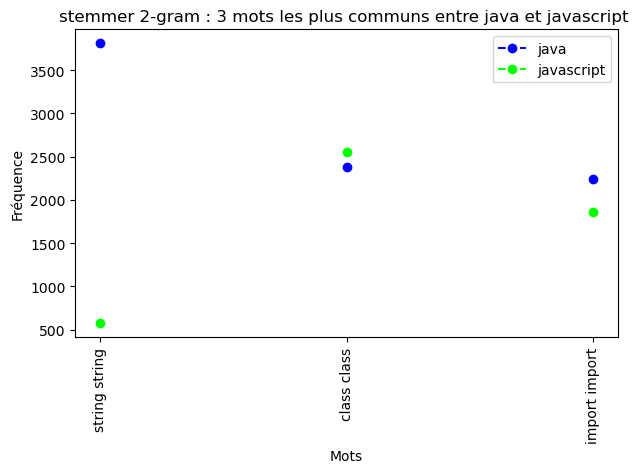

In [293]:
# Intersection mots java / javascript
affichage_frequence_distribution_sous_dataframe(most_common_n_gram_in = most_common_stemmer_2_gram,
                                                name_in               = 'stemmer 2-gram',
                                                cle_1_in              = 'java', 
                                                cle_2_in              = 'javascript',
                                                intersection_cles_in  = intersection_java_javascript_stemmer_2_gram)

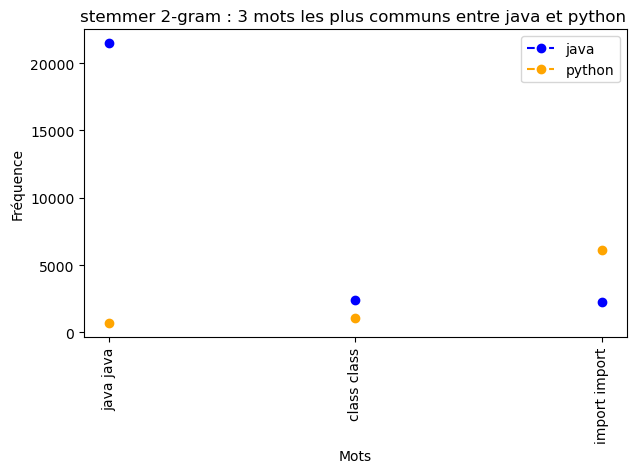

In [294]:
# Intersection mots java / python
affichage_frequence_distribution_sous_dataframe(most_common_n_gram_in = most_common_stemmer_2_gram,
                                                name_in               = 'stemmer 2-gram',
                                                cle_1_in              = 'java', 
                                                cle_2_in              = 'python',
                                                intersection_cles_in  = intersection_java_python_stemmer_2_gram)

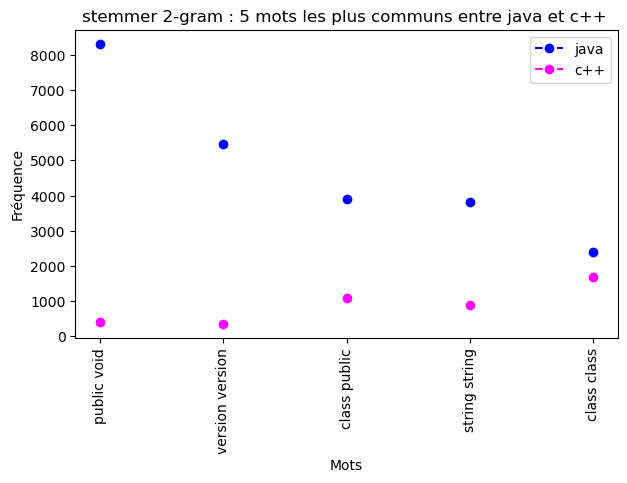

In [295]:
# Intersection mots java / c++
affichage_frequence_distribution_sous_dataframe(most_common_n_gram_in = most_common_stemmer_2_gram,
                                                name_in               = 'stemmer 2-gram',
                                                cle_1_in              = 'java', 
                                                cle_2_in              = 'c++',
                                                intersection_cles_in  = intersection_java_c_plus_plus_stemmer_2_gram)

# 7.3.3. FREQUENCE DISTRIBUTION COLONNE _LEMMA_CLEAN POUR 3-GRAM

In [296]:
# Maj paramètres communs
n_gram      = 3
operation   = '+'
colonne     = '_Lemma_clean_final'
most_common = 40

In [297]:
# java
most_common_lemma_3_gram['java'], most_common_lemma_3_gram_word['java'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'java', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common)

n_gram_in	= 3 
operation_in	= + 
cle_in		= java 
colonne_in	= _Lemma_clean_final 

40 most_common : [(('java', 'java', 'java'), 9977), (('java', 'apache', 'catalina'), 4037), (('apache', 'catalina', 'core'), 3162), (('android', 'android', 'android'), 2830), (('release', 'jar', 'release'), 2754), (('public', 'class', 'private'), 2392), (('import', 'java', 'import'), 2003), (('version', 'version', 'version'), 1980), (('java', 'factory', 'java'), 1929), (('catalina', 'core', 'java'), 1920), (('public', 'class', 'public'), 1902), (('factory', 'java', 'factory'), 1823), (('spring', 'release', 'jar'), 1743), (('boot', 'spring', 'boot'), 1671), (('java', 'android', 'java'), 1665), (('java', 'import', 'java'), 1651), (('public', 'static', 'void'), 1623), (('java', 'spring', 'release'), 1623), (('return', 'public', 'void'), 1495), (('sun', 'invoke', 'java'), 1456), (('core', 'java', 'apache'), 1441), (('java', 'apache', 'java'), 1426), (('android', 'java', 'android'), 1410), (('android', 'layou

In [298]:
# c#
most_common_lemma_3_gram['c#'], most_common_lemma_3_gram_word['c#'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'c#', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common)

n_gram_in	= 3 
operation_in	= + 
cle_in		= c# 
colonne_in	= _Lemma_clean_final 

40 most_common : [(('get', 'set', 'public'), 4186), (('public', 'class', 'public'), 2112), (('public', 'get', 'set'), 2111), (('public', 'string', 'get'), 1944), (('system', 'system', 'system'), 1936), (('string', 'get', 'set'), 1849), (('set', 'public', 'string'), 1502), (('set', 'public', 'get'), 1201), (('system', 'web', 'system'), 943), (('web', 'system', 'web'), 850), (('string', 'string', 'string'), 692), (('public', 'class', 'private'), 633), (('class', 'public', 'get'), 613), (('static', 'void', 'string'), 612), (('public', 'static', 'void'), 555), (('public', 'public', 'public'), 495), (('class', 'public', 'string'), 478), (('public', 'partial', 'class'), 468), (('set', 'public', 'class'), 468), (('void', 'object', 'sender'), 464), (('class', 'public', 'class'), 448), (('set', 'public', 'virtual'), 426), (('class', 'public', 'static'), 415), (('public', 'get', 'return'), 410), (('get', 'return', '

In [299]:
# javascript
most_common_lemma_3_gram['javascript'], most_common_lemma_3_gram_word['javascript'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'javascript', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common)

n_gram_in	= 3 
operation_in	= + 
cle_in		= javascript 
colonne_in	= _Lemma_clean_final 

40 most_common : [(('class', 'class', 'class'), 822), (('import', 'import', 'import'), 584), (('loader', 'loader', 'loader'), 445), (('input', 'text', 'input'), 424), (('document', 'ready', 'function'), 392), (('function', 'return', 'function'), 376), (('text', 'input', 'text'), 371), (('button', 'button', 'class'), 362), (('object', 'object', 'object'), 346), (('function', 'function', 'function'), 342), (('button', 'button', 'button'), 316), (('class', 'col', 'class'), 298), (('require', 'require', 'require'), 288), (('angular', 'angular', 'angular'), 280), (('return', 'function', 'return'), 262), (('null', 'null', 'null'), 243), (('text', 'text', 'text'), 229), (('class', 'row', 'class'), 220), (('size', 'size', 'size'), 216), (('path', 'require', 'path'), 196), (('label', 'label', 'input'), 193), (('console', 'console', 'console'), 191), (('input', 'text', 'class'), 186), (('class', 'col', 'col'

In [300]:
# python
most_common_lemma_3_gram['python'], most_common_lemma_3_gram_word['python'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'python', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common)

n_gram_in	= 3 
operation_in	= + 
cle_in		= python 
colonne_in	= _Lemma_clean_final 

40 most_common : [(('self', 'self', 'self'), 3447), (('import', 'import', 'import'), 2337), (('build', 'build', 'build'), 1284), (('file', 'line', 'module'), 921), (('file', 'local', 'python'), 894), (('self', 'return', 'self'), 794), (('file', 'local', 'line'), 748), (('call', 'file', 'line'), 734), (('nan', 'nan', 'nan'), 671), (('python', 'python', 'python'), 626), (('line', 'module', 'import'), 590), (('line', 'module', 'file'), 552), (('file', 'python', 'line'), 526), (('loss', 'loss', 'loss'), 486), (('time', 'time', 'time'), 481), (('self', 'self', 'return'), 409), (('local', 'python', 'line'), 388), (('module', 'import', 'file'), 380), (('self', 'file', 'local'), 358), (('return', 'self', 'self'), 354), (('java', 'java', 'java'), 351), (('model', 'add', 'activation'), 343), (('module', 'file', 'line'), 298), (('token', 'token', 'token'), 293), (('class', 'class', 'class'), 292), (('model', 'mod

In [301]:
# c++
most_common_lemma_3_gram['c++'], most_common_lemma_3_gram_word['c++'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'c++', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common)

n_gram_in	= 3 
operation_in	= + 
cle_in		= c++ 
colonne_in	= _Lemma_clean_final 

40 most_common : [(('include', 'include', 'include'), 1254), (('boost', 'boost', 'boost'), 564), (('char', 'char', 'char'), 537), (('bin', 'bin', 'bin'), 445), (('class', 'class', 'class'), 439), (('double', 'double', 'double'), 435), (('size', 'size', 'size'), 416), (('text', 'undefined', 'reference'), 384), (('basic', 'string', 'char'), 352), (('string', 'string', 'string'), 284), (('void', 'void', 'void'), 272), (('insert', 'insert', 'alt'), 270), (('internal', 'internal', 'internal'), 269), (('boost', 'variant', 'void'), 264), (('stack', 'stack', 'stack'), 259), (('void', 'boost', 'variant'), 258), (('time', 'time', 'time'), 255), (('variant', 'void', 'boost'), 255), (('include', 'include', 'string'), 231), (('return', 'return', 'return'), 226), (('char', 'allocator', 'char'), 222), (('string', 'char', 'char'), 210), (('include', 'string', 'include'), 210), (('char', 'char', 'allocator'), 203), (('lay

In [302]:
###################################################
#    Intersection entre les 5 sous-dataframes     #
###################################################
# https://www.cours-gratuit.com/tutoriel-python/tutoriel-python-trouver-lintersection-de-deux-listes
set_java_lemma_3_gram        = set(most_common_lemma_3_gram_word['java'])
set_c_sharp_lemma_3_gram     = set(most_common_lemma_3_gram_word['c#']) 
set_javascript_lemma_3_gram  = set(most_common_lemma_3_gram_word['javascript']) 
set_python_lemma_3_gram      = set(most_common_lemma_3_gram_word['python']) 
set_c_plus_plus_lemma_3_gram = set(most_common_lemma_3_gram_word['c++']) 

intersection_java_c_sharp_lemma_3_gram     = list(set_java_lemma_3_gram & set_c_sharp_lemma_3_gram)
intersection_java_javascript_lemma_3_gram  = list(set_java_lemma_3_gram & set_javascript_lemma_3_gram)
intersection_java_python_lemma_3_gram      = list(set_java_lemma_3_gram & set_python_lemma_3_gram)
intersection_java_c_plus_plus_lemma_3_gram = list(set_java_lemma_3_gram & set_c_plus_plus_lemma_3_gram)
intersection_all_lemma_3_gram              = list(set_java_lemma_3_gram & set_c_sharp_lemma_3_gram & \
                                                    set_javascript_lemma_3_gram & set_python_lemma_3_gram & \
                                                    set_c_plus_plus_lemma_3_gram)

print('intersection_java_c_sharp_lemma_3_gram\t\t=', intersection_java_c_sharp_lemma_3_gram)
print('intersection_java_javascript_lemma_3_gram\t=', intersection_java_javascript_lemma_3_gram)
print('intersection_java_python_lemma_3_gram\t\t=', intersection_java_python_lemma_3_gram)
print('intersection_java_c_plus_plus_lemma_3_gram\t=', intersection_java_c_plus_plus_lemma_3_gram)
print('intersection_all_lemma_3_gram\t\t\t=', intersection_all_lemma_3_gram)

intersection_java_c_sharp_lemma_3_gram		= [('public', 'class', 'private'), ('string', 'string', 'string'), ('public', 'static', 'void'), ('public', 'class', 'public'), ('public', 'void', 'string'), ('static', 'void', 'string')]
intersection_java_javascript_lemma_3_gram	= [('string', 'string', 'string')]
intersection_java_python_lemma_3_gram		= [('java', 'java', 'java')]
intersection_java_c_plus_plus_lemma_3_gram	= [('string', 'string', 'string')]
intersection_all_lemma_3_gram			= []


In [ ]:
####################################################
#       Affichage fréquence distribution           #
####################################################
# On affiche les distributions qui ont des intersections.

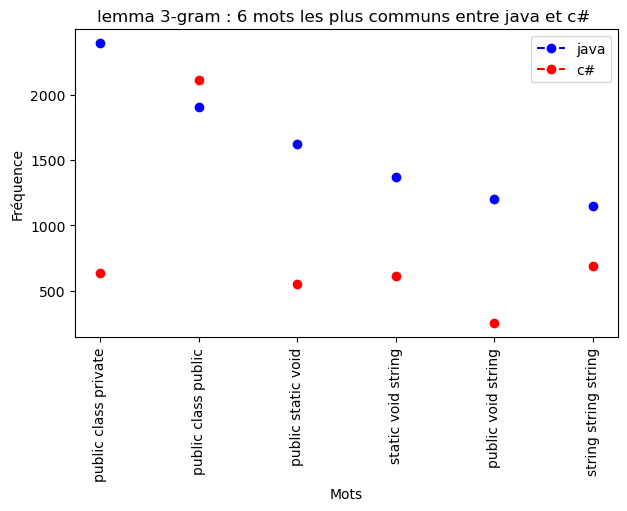

In [303]:
# Intersection mots java / c#
affichage_frequence_distribution_sous_dataframe(most_common_n_gram_in = most_common_lemma_3_gram,
                                                name_in               = 'lemma 3-gram',
                                                cle_1_in              = 'java', 
                                                cle_2_in              = 'c#',
                                                intersection_cles_in  = intersection_java_c_sharp_lemma_3_gram)

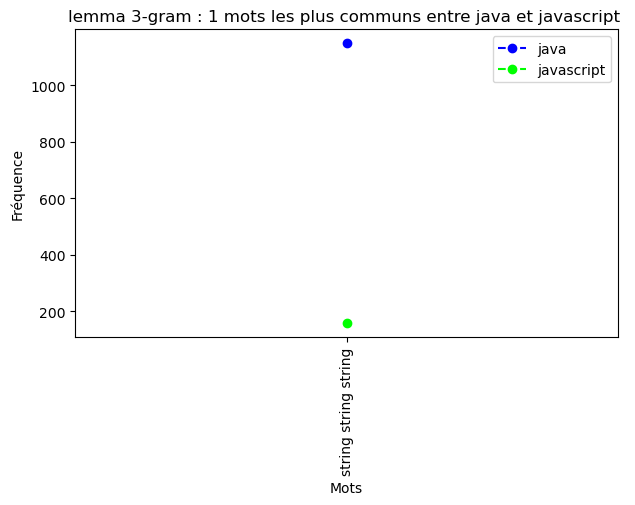

In [304]:
# Intersection mots java / javascript
affichage_frequence_distribution_sous_dataframe(most_common_n_gram_in = most_common_lemma_3_gram,
                                                name_in               = 'lemma 3-gram',
                                                cle_1_in              = 'java', 
                                                cle_2_in              = 'javascript',
                                                intersection_cles_in  = intersection_java_javascript_lemma_3_gram)

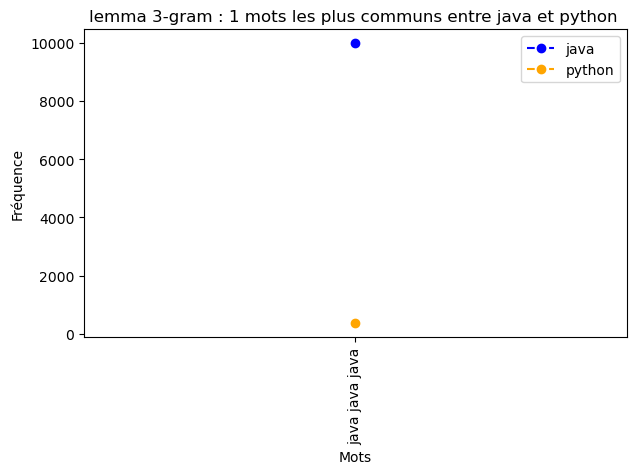

In [305]:
# Intersection mots java / python
affichage_frequence_distribution_sous_dataframe(most_common_n_gram_in = most_common_lemma_3_gram,
                                                name_in               = 'lemma 3-gram',
                                                cle_1_in              = 'java', 
                                                cle_2_in              = 'python',
                                                intersection_cles_in  = intersection_java_python_lemma_3_gram)

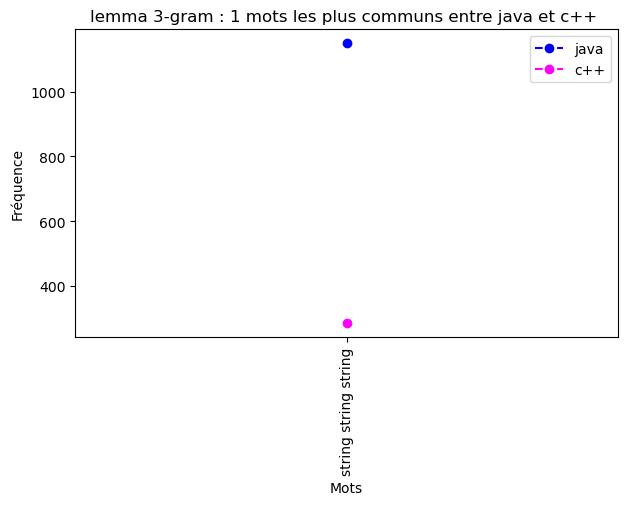

In [306]:
# Intersection mots java / c++
affichage_frequence_distribution_sous_dataframe(most_common_n_gram_in = most_common_lemma_3_gram,
                                                name_in               = 'lemma 3-gram',
                                                cle_1_in              = 'java', 
                                                cle_2_in              = 'c++',
                                                intersection_cles_in  = intersection_java_c_plus_plus_lemma_3_gram)

# 7.4. WORD CLOUD (VARIABLE CATEGORIELLE)

In [ ]:
##############################################################################  
# WordCloud : visualisation des tokens les plus présents d'une colonne       #
##############################################################################

In [307]:
#########################################################  
# WordCloud pour le dataframe, d'une colonne            #
######################################################### 
def word_cloud(count_in, colonne_in, cle_in = ''):
    
    # Affichage des 20 mots les plus fréquents du corpus
    if (cle_in != ''):
        print('20 mots les plus fréquents colonne', colonne_in, ', sous-dataframe', cle_in, ':')
    else:
        print('20 mots les plus fréquents colonne', colonne_in, ':')
    print(count_in.head(20), '\n')
    
    
    # https://ichi.pro/fr/creer-des-nuages-de-mots-personnalises-en-python-145227399773811
    wc = WordCloud(background_color = 'beige',
                   max_words        = 40,      # affichage d'au moins 40 mots
                   width            = 4000, 
                   height           = 3000)
    wc.generate_from_frequencies(count_in)
    plt.imshow(wc)
    plt.axis("off")
    if (cle_in != ''):
        plt.title('Word Cloud colonne ' + colonne_in + ', sous-dataframe ' + cle_in)
    else:
        plt.title('Word Cloud colonne ' + colonne_in)
    plt.show()

In [308]:
#########################################################  
# WordCloud pour les sous-dataframes, d'une colonne     #
######################################################### 
def word_cloud_sous_dataframe(cle_in, colonne_in):
   
    #####################################
    # Corpus au format texte            #
    #####################################
    # On reconstitue le corpus en joignant l'ensemble des lignes / documents entre eux.
    corpus_text = ' '.join(dict_df[cle_in][colonne_in])

    
    #####################################
    # Corpus au format token            #
    #####################################
    token_text = corpus_text.split()
    
    
    #############################################################
    # Nombre de fois où les tokens sont présents dans le corpus #
    #############################################################  
    count_text = pd.Series(token_text).value_counts()
        
        
    #####################################
    # Wordcloud                         #
    #####################################
    word_cloud(count_in   = count_text, 
               colonne_in = colonne_in,
               cle_in     = cle_in)

20 mots les plus fréquents colonne _Text_clean :
java        137644
android     101731
class        95023
public       78751
file         69621
string       69017
return       67360
get          66939
c            64184
function     50016
import       46770
self         43116
system       41392
void         39819
version      39817
set          37698
null         35068
server       33585
text         32617
object       32248
Name: count, dtype: int64 



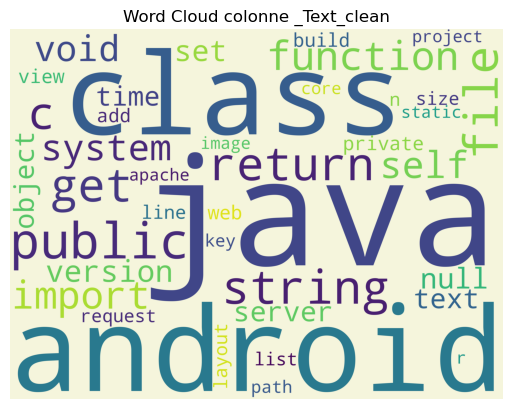

In [309]:
#########################################################
#        WordCloud dataframe, colonne _Text_clean       #
#########################################################
word_cloud(count_in   = count_text, 
           colonne_in = '_Text_clean')

20 mots les plus fréquents colonne _Stemmer_clean_final :
java        137644
android     101731
class        95023
public       78751
file         69621
string       69017
return       67360
get          66939
function     50016
import       46770
self         43116
set          42556
system       41392
void         39819
version      39817
null         35068
server       33585
build        33213
text         32617
time         32271
Name: count, dtype: int64 



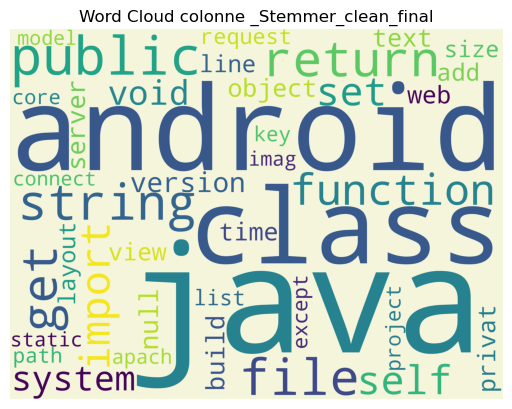

In [310]:
#########################################################
#       WordCloud dataframe, colonne _Stemmer_clean     #
#########################################################
word_cloud(count_in   = count_stemmer, 
           colonne_in = '_Stemmer_clean_final')

20 mots les plus fréquents colonne _Lemma_clean_final :
java        137644
android     101731
class        95023
public       78751
file         69621
string       69017
return       67360
get          66939
function     50016
import       46770
self         43116
system       41392
void         39819
version      39817
set          37698
null         35068
server       33585
text         32617
object       32248
time         31057
Name: count, dtype: int64 



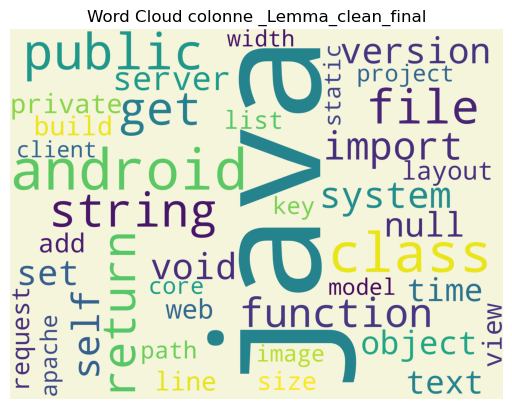

In [311]:
#########################################################
#        WordCloud dataframe, colonne _Lemma_clean      #
#########################################################
word_cloud(count_in   = count_lemma, 
           colonne_in = '_Lemma_clean_final')

20 mots les plus fréquents colonne _Stemmer_clean_final , sous-dataframe java :
java       101590
public      31965
class       26966
android     26641
string      23469
apach       17886
version     16382
spring      16066
jar         15922
import      14337
return      14209
privat      14166
void        12927
web         12683
file        11065
hibern      11000
core        10504
final       10264
get         10122
sun         10067
Name: count, dtype: int64 



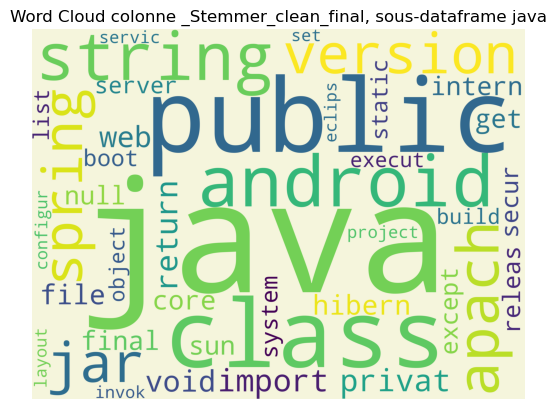

In [312]:
###########################################################
#  WordCloud sous-dataframe java, colonne _Stemmer_clean  #
###########################################################
word_cloud_sous_dataframe(cle_in     = 'java', 
                          colonne_in = '_Stemmer_clean_final')

20 mots les plus fréquents colonne _Stemmer_clean_final , sous-dataframe c# :
public     24226
system     19400
string     16276
get        13726
class      12157
set        10369
return      9425
object      7871
void        6793
add         6158
null        6155
web         5975
privat      5917
file        5849
static      5237
except      5048
task        4843
list        4597
server      4463
version     4149
Name: count, dtype: int64 



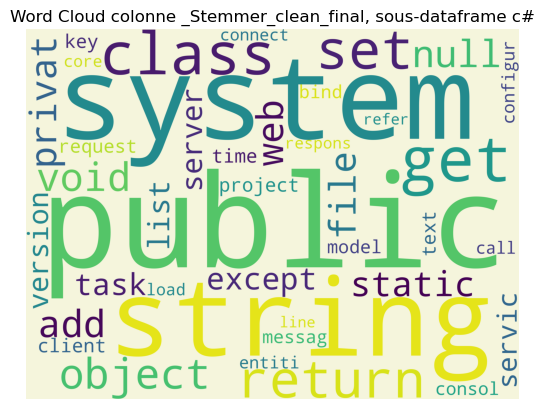

In [313]:
#########################################################
#  WordCloud sous-dataframe c#, colonne _Stemmer_clean  #
#########################################################
word_cloud_sous_dataframe(cle_in     = 'c#', 
                          colonne_in = '_Stemmer_clean_final') 

20 mots les plus fréquents colonne _Stemmer_clean_final , sous-dataframe javascript :
function    20694
class       14896
return       8657
text         8164
get          7311
file         7274
consol       6819
import       5964
button       5800
input        5311
server       5009
width        4813
document     4786
requir       4352
object       4312
load         4251
modul        4177
request      3843
height       3822
imag         3705
Name: count, dtype: int64 



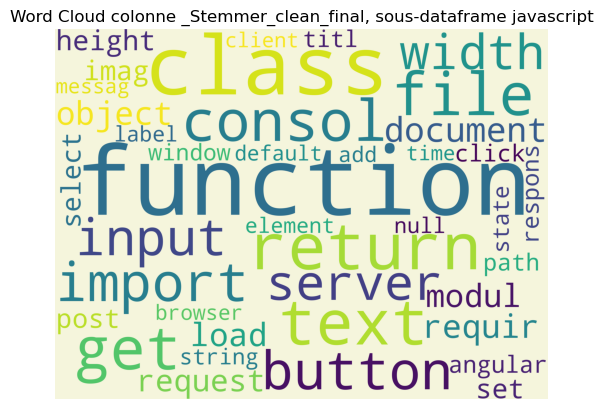

In [314]:
#################################################################
#  WordCloud sous-dataframe javascript, colonne _Stemmer_clean  #
#################################################################
word_cloud_sous_dataframe(cle_in      = 'javascript',
                          colonne_in = '_Stemmer_clean_final')

20 mots les plus fréquents colonne _Stemmer_clean_final , sous-dataframe python :
self        27711
file        21142
python      19649
import      17022
line        14557
get         11741
return      10341
model        9124
class        7927
time         7088
local        6777
build        6387
function     6004
modul        5672
set          5621
size         5129
path         4919
output       4772
input        4601
add          4569
Name: count, dtype: int64 



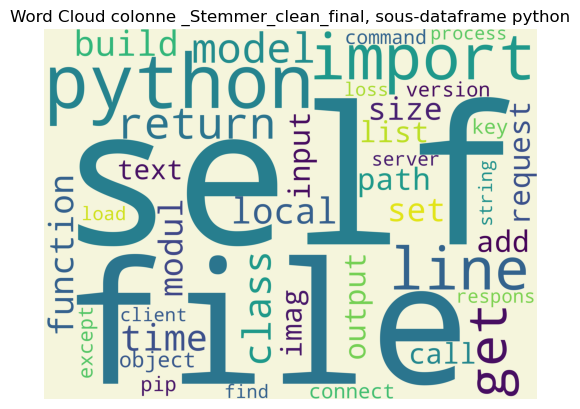

In [315]:
#############################################################
#  WordCloud sous-dataframe python, colonne _Stemmer_clean  #
#############################################################
word_cloud_sous_dataframe(cle_in      = 'python',
                          colonne_in = '_Stemmer_clean_final')

20 mots les plus fréquents colonne _Stemmer_clean_final , sous-dataframe c++ :
includ      9175
class       7963
void        7554
return      7378
function    6586
boost       6358
size        5658
string      5178
char        5113
file        4760
vector      4078
get         4076
time        3806
static      3440
memori      3273
doubl       3165
set         3026
public      2849
build       2712
object      2709
Name: count, dtype: int64 



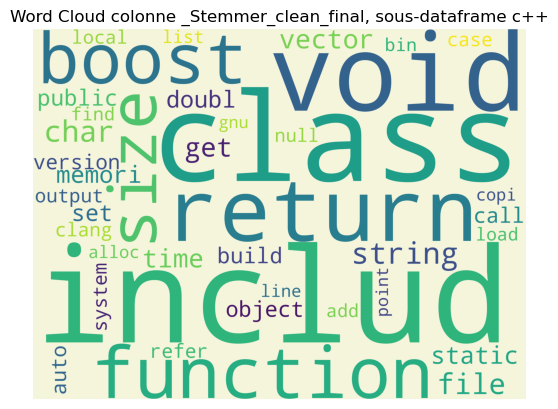

In [316]:
###########################################################
#  WordCloud sous-dataframe c++, colonne _Stemmer_clean   #
###########################################################
word_cloud_sous_dataframe(cle_in      = 'c++',
                          colonne_in = '_Stemmer_clean_final')

# 7.5. ANALYSE UNIVARIEE VARIABLES NUMERIQUES

In [317]:
# Sélection des colonnes numériques
df_numerique = df.select_dtypes(include = np.number)
var_numerique = df_numerique.columns
print('var_numerique =', var_numerique)

var_numerique = Index(['Id', 'Score', 'ViewCount', 'AnswerCount', '_len_Text_clean'], dtype='object')


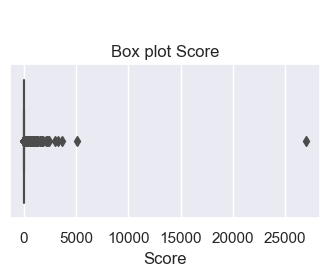

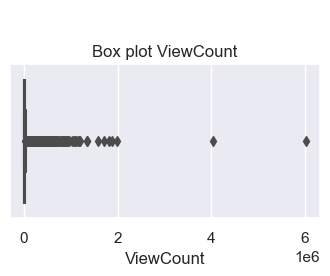

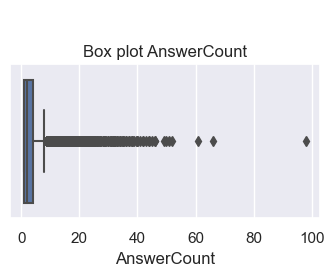

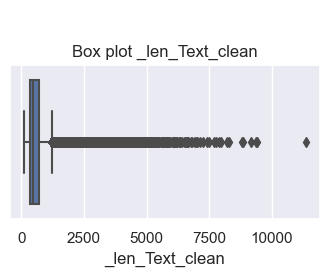

In [318]:
for col in var_numerique:
    if (col != 'Id'):
        # define figure size
        sns.set(rc = {"figure.figsize":(4, 2)}) #width=6, height=5
        plt.title('\n\nBox plot ' + col)    
        sns.boxplot(data = df, x = col)

        plt.show()    

# 8. ANALYSE BIVARIEE

# 8.1. ETUDE DE LA TAILLE DES DOCUMENTS PAR RAPPORT AUX TAGS (VARIABLE QUANTITATIVE ET VARIABLE CATEGORIELLE)

In [319]:
#####################################################################
#   Box plot pour 1 variable catégorielle et 1 variable numérique   #
#####################################################################
# https://seaborn.pydata.org/generated/seaborn.boxplot.html
def box_plot(colonne_x_numerique_in, colonne_y_categorielle_in):
    
    order_categorical_level = df.groupby(colonne_y_categorielle_in)[colonne_x_numerique_in].median().sort_values().index

    plt.figure(figsize = (6, 9))
    sns.set(font_scale = 0.6)
    
    sns.boxplot(x          = colonne_x_numerique_in, 
                y          = colonne_y_categorielle_in, 
                showfliers = False, # on supprime outliers
                orient     = 'h',
                order      = order_categorical_level, 
                data       = df)
    
    plt.title('Box plot ' + colonne_x_numerique_in + ' % ' + colonne_y_categorielle_in, fontsize = 12)
    plt.show()
    
    print('\n\n')

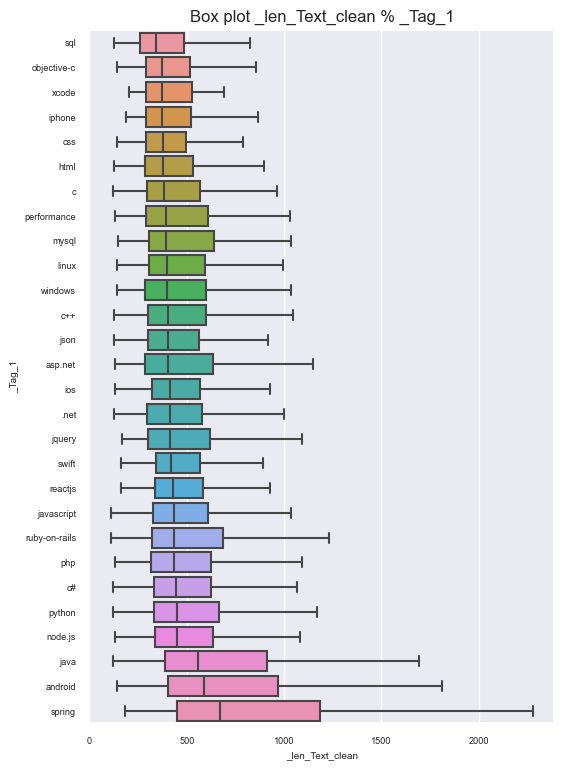

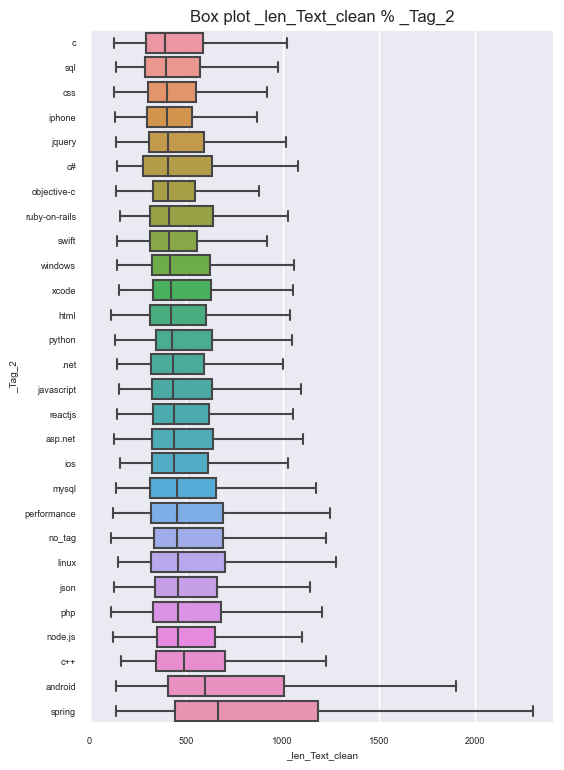

In [320]:
########################################################
# Box plot avec colonne_x_numerique = _len_Text_clean  #
########################################################
box_plot(colonne_x_numerique_in    = '_len_Text_clean',
         colonne_y_categorielle_in = '_Tag_1')

box_plot(colonne_x_numerique_in    = '_len_Text_clean',
         colonne_y_categorielle_in = '_Tag_2')

# 9. ANALYSE MULTIVARIEE

# 9.1. ANALYSE DE 3 VARIABLES NUMERIQUES

In [326]:
#######################################################################
#    Calcul du nombre de mots uniques pour les colonnes _xxx_clean    #
#######################################################################
# https://www.delftstack.com/fr/howto/python/python-count-unique-values-in-list/
# Nombre de mots uniques dans les colonnes _xxx_clean.
# on stocke ce vecteur numérique dans une colonne préfixée par _
count = 0

for index, row in df.iterrows():
    
    df.loc[index, '_unique_words_Text_clean']          = len(np.unique(df.loc[index, '_Text_clean'].split()))
    df.loc[index, '_unique_words_Lemma_clean_final']   = len(np.unique(df.loc[index, '_Lemma_clean_final'].split()))
    df.loc[index, '_unique_words_Stemmer_clean_final'] = len(np.unique(df.loc[index, '_Stemmer_clean_final'].split()))
    
    if (count < 4):
        print('index =', index, ':', '\n',
              '\t- _Text_clean\t\t\t\t=', df.loc[index, '_Text_clean'], '\n', 
              '\t- _len_Text_clean\t\t\t=', df.loc[index, '_len_Text_clean'], '\n', 
              '\t- _unique_words_Text_clean\t\t=', df.loc[index, '_unique_words_Text_clean'], '\n',  
              '\t- _Lemma_clean_final\t\t\t=', df.loc[index, '_Lemma_clean_final'], '\n',               
              '\t- _unique_words_Lemma_clean_final\t=', df.loc[index, '_unique_words_Lemma_clean_final'], '\n',
              '\t- _Stemmer_clean_final\t\t\t=', df.loc[index, '_Stemmer_clean_final'], '\n',                       
              '\t- _unique_words_Stemmer_clean_final\t=', df.loc[index, '_unique_words_Stemmer_clean_final'], '\n')
    count = count + 1

index = 0 : 
 	- _Text_clean				= performance class radio time process time process performance store configuration load input web configuration instance partial trust solution add memory disk tell time final save disk verify handle load testing performance 
 	- _len_Text_clean			= 223 
 	- _unique_words_Text_clean		= 23.0 
 	- _Lemma_clean_final			= performance class radio time process time process performance store configuration load input web configuration instance partial trust solution add memory disk tell time final save disk verify handle load testing performance 
 	- _unique_words_Lemma_clean_final	= 23.0 
 	- _Stemmer_clean_final			= perform class radio time process time process perform store configur load input web configur instanc partial trust solut add memori disk tell time final save disk handl load test perform 
 	- _unique_words_Stemmer_clean_final	= 22.0 

index = 1 : 
 	- _Text_clean				= get environment get environment setting hosting solution solution server either 

In [327]:
# summary statistics sur les colonnes de type numérique
# (transpose met les attributs en ligne pour + de lisibilité)
df.describe(include = np.number).transpose()

,count,mean,std,min,25%,50%,75%,max
Id,49493.0,3.076258e+07,1.899073e+07,19.0,14243249.0,29861672.0,45636541.0,76363078.0
Score,49493.0,1.821942e+01,1.339870e+02,6.0,7.0,9.0,15.0,27009.0
ViewCount,49493.0,1.790583e+04,5.770890e+04,67.0,2452.0,6458.0,16424.0,6024098.0
AnswerCount,49493.0,3.013638e+00,2.954516e+00,1.0,1.0,2.0,4.0,98.0
_len_Text_clean,49493.0,6.254535e+02,5.820245e+02,108.0,332.0,454.0,687.0,11356.0
_unique_words_Text_clean,49493.0,3.029416e+01,1.278563e+01,4.0,22.0,27.0,35.0,161.0
_unique_words_Lemma_clean,1.0,2.300000e+01,NaN,23.0,23.0,23.0,23.0,23.0
_unique_words_Stemmer_clean,1.0,2.200000e+01,NaN,22.0,22.0,22.0,22.0,22.0
_unique_words_Lemma_clean_final,49493.0,2.937413e+01,1.244268e+01,4.0,21.0,27.0,34.0,158.0
_unique_words_Stemmer_clean_final,49493.0,2.528095e+01,1.073358e+01,4.0,18.0,23.0,30.0,131.0


In [328]:
df.columns

Index(['CreationDate', 'Id', 'Score', 'ViewCount', 'AnswerCount', '_Text',
       '_Tag_1', '_Tag_2', '_Text_sans_html', '_Text_tokens_chaine',
       '_Text_tokens', '_Tokens_text_clean', '_Tokens_stemmer_clean',
       '_Tokens_lemma_clean', '_Text_clean', '_Stemmer_clean', '_Lemma_clean',
       '_Tokens_stemmer_clean_final', '_Tokens_lemma_clean_final',
       '_Stemmer_clean_final', '_Lemma_clean_final', '_len_Text_clean',
       '_unique_words_Text_clean', '_unique_words_Lemma_clean',
       '_unique_words_Stemmer_clean', '_unique_words_Lemma_clean_final',
       '_unique_words_Stemmer_clean_final'],
      dtype='object')

In [329]:
# Réduction du dataframe pour avoir une figure + lisible
print('df shape\t=', df.shape)

df_reduit = df[(df['AnswerCount'] <= 20) &
               (df['Score'] <= 200)]
print('df_reduit shape\t=', df_reduit.shape)

df shape	= (49493, 27)
df_reduit shape	= (49122, 27)


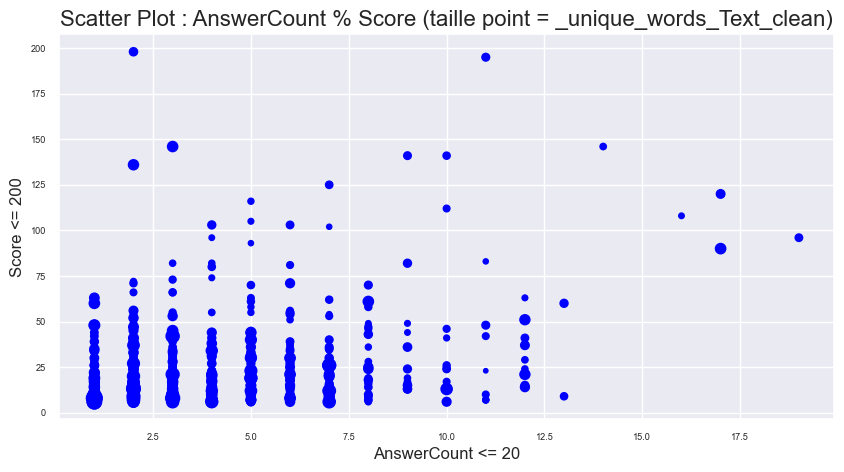

In [330]:
############################################################
# Scatter plot pour 3 variables numériques :               #
#    --> x = AnswerCount                                   #
#    --> y = Score                                         #
#    --> taille des points = _unique_words_Text_clean      #
############################################################
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
# https://www.geeksforgeeks.org/how-to-increase-the-size-of-scatter-points-in-matplotlib/  
# https://stackoverflow.com/questions/30336138/how-to-plot-a-multivariate-function-in-python

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html
# Bp de points => pour + de lisibilité, on travaille sur un sous-ensemble (2000 points)
data_subset = df_reduit.sample(n = 2000, replace = True, random_state = 1)    
    
plt.figure(figsize = (10, 5)) # 6 is width, 5 is height

x = data_subset['AnswerCount']
y = data_subset['Score'] 
points_size = data_subset['_unique_words_Text_clean'] 

plt.scatter(x, y, s = points_size, c = 'blue')

plt.title('Scatter Plot : AnswerCount % Score (taille point = _unique_words_Text_clean)', fontsize = 16)
plt.xlabel('AnswerCount <= 20', fontsize = 12)
plt.ylabel('Score <= 200', fontsize = 12)
  
plt.show()

In [341]:
# Suppression :
#  ---> de la colonne date ('CreationDate').
#  ---> des colonnes intermédiaires créées pour le calcul :
#          * de la taille du texte ('_len_Text_clean')
#          * du nombre de mots uniques ('_unique_words_xxx').
#          * des colonnes nettoyées ('Text_xxx', _xxx_clean').
df.drop(['CreationDate', 
         '_Text', '_Text_tokens_chaine', '_Text_tokens', 
         '_Tokens_text_clean', '_Tokens_stemmer_clean', '_Tokens_lemma_clean', '_Text_clean',
         '_Stemmer_clean', '_Lemma_clean',
         '_len_Text_clean',
         '_unique_words_Text_clean', '_unique_words_Lemma_clean', '_unique_words_Stemmer_clean', 
         '_unique_words_Lemma_clean_final', '_unique_words_Stemmer_clean_final'],
        axis = 1, inplace = True)

In [342]:
df.columns

Index(['Id', 'Score', 'ViewCount', 'AnswerCount', '_Tag_1', '_Tag_2',
       '_Text_sans_html', '_Tokens_stemmer_clean_final',
       '_Tokens_lemma_clean_final', '_Stemmer_clean_final',
       '_Lemma_clean_final'],
      dtype='object')

# 9.2. MATRICE DE CORRELATION

In [344]:
# Sélection des colonnes numériques
df_numerique = df.select_dtypes(include = np.number)
var_numerique = df_numerique.columns
print('var_numerique =', var_numerique)

var_numerique = Index(['Id', 'Score', 'ViewCount', 'AnswerCount'], dtype='object')


In [345]:
# matrice de corrélation
corr = df_numerique.corr()
corr

,Id,Score,ViewCount,AnswerCount
Id,1.000000,-0.031838,-0.075068,-0.130597
Score,-0.031838,1.000000,0.396343,0.197131
ViewCount,-0.075068,0.396343,1.000000,0.472946
AnswerCount,-0.130597,0.197131,0.472946,1.000000


In [346]:
#####################################################################
# matrice de corrélation : représentation graphique de la diagonale #
#####################################################################
# Valeurs minimale = -1, maximale = 1. 
# fmt = arrondi 2 chiffres après la virgule.
def affichage_matrice_correlation(df_in):
    
    corr = df_in.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    fig, ax = plt.subplots(1, 1, figsize = (7,5))
    ax = sns.heatmap(corr, mask = mask, vmin = -1, vmax = 1, cmap = 'coolwarm', annot = True, fmt = '.2f', square = True)

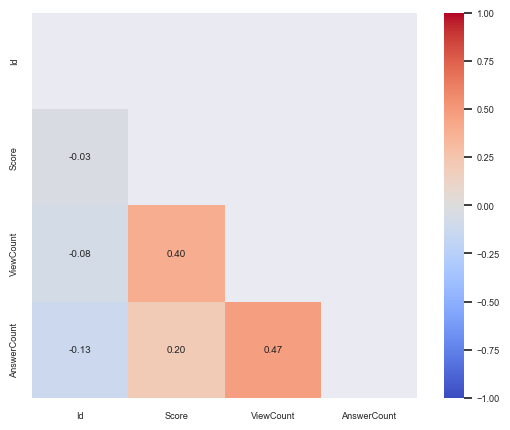

In [347]:
affichage_matrice_correlation(df_in = df_numerique)

# Il n'y a pas de corrélation entre les colonnes.

# 10. SAUVEGARDE DANS FICHIERS

In [348]:
df.columns

Index(['Id', 'Score', 'ViewCount', 'AnswerCount', '_Tag_1', '_Tag_2',
       '_Text_sans_html', '_Tokens_stemmer_clean_final',
       '_Tokens_lemma_clean_final', '_Stemmer_clean_final',
       '_Lemma_clean_final'],
      dtype='object')

In [349]:
# Suppression des colonnes numériques ('Id', 'Score', 'AnswerCount') sans intérêt pour le machine learning. 
df.drop(['Id', 'Score', 'ViewCount', 'AnswerCount'], axis = 1, inplace = True)

In [352]:
df.columns

Index(['_Tag_1', '_Tag_2', '_Text_sans_html', '_Tokens_stemmer_clean_final',
       '_Tokens_lemma_clean_final', '_Stemmer_clean_final',
       '_Lemma_clean_final'],
      dtype='object')

In [353]:
# Réinitialisation de l’index du dataFrame :
#   --> Avant sauvegarde dans fichier.
# https://www.delftstack.com/fr/howto/python-pandas/pandas-reset-index-python/
df.reset_index(inplace = True, drop = True)

In [354]:
###########################################################
#             Données nettoyées réduites                  #
###########################################################
df_light = df.copy()

In [355]:
# On enlève uniquement la colonne '_Text_sans_html'
df_light.drop(['_Text_sans_html'], axis = 1, inplace = True)

In [356]:
df_light.columns

Index(['_Tag_1', '_Tag_2', '_Tokens_stemmer_clean_final',
       '_Tokens_lemma_clean_final', '_Stemmer_clean_final',
       '_Lemma_clean_final'],
      dtype='object')

In [357]:
###########################################################
#   ENREGISTREMENT DONNEES NETTOYEES DANS DES FICHIERS    #
###########################################################
# Données nettoyées
df.to_csv(C_DATASET_CLEANED + 'QueryResults_2008_to_2023_clean.csv', 
          sep = '\t', header = True, index = False)

# Données nettoyées réduites
df_light.to_csv(C_DATASET_CLEANED + 'QueryResults_2008_to_2023_clean_light.csv', 
                sep = '\t', header = True, index = False)